In [1]:
#!pip install hyperopt datawig lightgbm pyod xgboost mxnet mlxtend category-encoders

### Download the Data

In [2]:
import os
import pandas as pd
import requests

# dataset is located in current directory
HOUSING_PATH = os.getcwd()

# function to load training dataset


def load_housing_data(filename="train.csv"):
    import numpy as np
    csv_path = os.path.join(HOUSING_PATH, filename)
    df = pd.read_csv(csv_path, dtype={'GarageYrBlt': np.float32, 'YearBuilt': np.float32, 'YrSold': np.float32, 'YearRemodAdd': np.float32,
                                      'LotFrontage': np.float32})

    return df

In [3]:
# Read files
X = load_housing_data('train_features.csv')
X_test = load_housing_data('test_features.csv')

# Save the 'Id' column
#train_ID = train['Id']
#test_ID = test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
#train.drop("Id", axis=1, inplace=True)
#test.drop("Id", axis=1, inplace=True)

In [4]:
X_test

,LotFrontage,LotArea,OverallQual,OverallCond,BsmtQual,BsmtFinType1,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id
0,-0.702839,0.477931,-0.5,1.0000,-1.0,-0.2,-0.375371,-0.211420,0.0,-0.414160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1461
1,-0.702839,0.960919,0.0,1.0000,-1.0,0.2,-0.106936,0.662617,0.0,0.448113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1462
2,0.158270,0.887079,-0.5,0.0000,0.0,0.4,-0.702144,-0.119306,0.0,-0.336888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1463
3,0.158270,0.124305,0.0,1.0000,-1.0,0.4,-0.263226,-0.123299,0.0,-0.341636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1464
4,0.821235,-1.417254,1.0,0.0000,0.0,0.2,0.789955,0.568838,0.0,0.366501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.126889,-3.391435,-1.0,1.9707,-1.0,-0.6,0.132048,-0.905166,0.0,-1.515754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2915
1455,1.126889,-3.435091,-1.0,0.0000,-1.0,-0.2,-0.324470,-0.905166,0.0,-1.515754,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,2916
1456,-0.702839,1.775852,-0.5,1.9707,-1.0,0.2,-1.344629,0.461114,0.0,0.269164,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,2917
1457,0.478915,0.228975,-0.5,0.0000,0.0,0.4,0.178181,-0.151280,0.0,-0.239563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2918


In [5]:
y=X['SalePrice'].values
X.drop('SalePrice', axis = 1, inplace = True)

Skewness: 0.153930


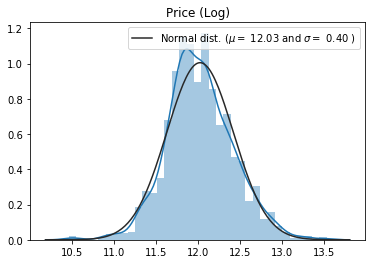

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline 
from scipy.stats import norm, skew

import seaborn as sns
import seaborn as sns
# target feature transformed
sns.distplot(y , fit=norm);
(mu, sigma) = norm.fit(y)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.title('Price (Log)');
print("Skewness: %f" % pd.DataFrame(y).skew())

In [7]:
import numpy as np
np.isnan(y).any()

False

## Select and Train a Model 

In [8]:

from keras import backend as K
from keras.losses import *
import math

# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return abs( 1 - SS_res/(SS_tot + K.epsilon()) )


from keras.losses import logcosh

from keras import regularizers
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.layers import Activation, Dense

def create_model(epochs=100, batch_size=64, dropout_rate=0.005, l=0.01, lr=0.001, loss=mean_squared_error ):
    NN_model = Sequential()
    # The Input Layer :
    NN_model.add(Dense(6, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))
    # The Hidden Layers :
    #NN_model.add(Dense(1, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    #NN_model.add(Dense(1, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    #NN_model.add(Dropout(rate =dropout_rate))
    #NN_model.add(Dense(16, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    NN_model.add(Dense(4, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    from keras import optimizers
    adam = optimizers.Adam(lr=lr)
    
    # Compile the network :
    NN_model.compile(loss=loss, optimizer=adam)

    #NN_model.summary()

    return NN_model

NN_model = create_model()
NN_model.summary()

from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn=create_model)



Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "metal_amd_radeon_pro_wx_9100.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 1380      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,413
Trainable params: 1,413
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from joblib import Parallel, delayed, parallel_backend

with parallel_backend('threading'):
    global rmse
    param_grid = [
        # try 12 (3×4) combinations of hyperparameters
        #{'n_estimators': [30, 180, 220], 'max_features': [16, 32, 64, 128]},
        # then try 6 (2×3) combinations with bootstrap set as False
        {'epochs': [100, 50, 200], 'batch_size': [64, 32, 128], 'dropout_rate': [0.005, 0.01], 'l': [0.01, 0.0001, 0.05], 'lr': [0.001, 0.01, 0.003], 
        'loss': [hinge, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error]}
        ]

    #forest_reg = RandomForestRegressor(random_state=42)
    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
    grid_search = GridSearchCV(model, param_grid, cv=3,
                                   scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs = 8)

    grid_search.fit(X, y)



Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
968/968 [==============================] - 1s 622us/step - loss: 0.2217
Epoch 2/100
968/968 [==============================] - 1s 617us/step - loss: 0.8951
Epoch 2/100
Epoch 2/100
968/968 [==============================] - 0s 106us/step - loss: 0.0040
Epoch 3/100
968/968 [==============================] - 0s 106us/step - loss: 0.0017
Epoch 3/100
968/968 [==============================] - 0s 107us/step - loss: 0.5805
Epoch 3/100
969/969 [==============================] - 1s 813us/step - loss: 0.4752
Epoch 2/100
969/969 [==============================] - 1s 824us/step - loss: 0.9201

969/969 [==============================] - 1s 833us/step - loss: 0.2024
Epoch 2/100
Epoch 2/100
Epoch 2/100
968/968 [==============================] - 0s 132us/step - loss: 0.00174/969 [>.............................] - ETA: 0s - loss: 0.751
Epoch 4/100
968/968 [==============================] - 0s 144us/step - lo

969/969 [==============================] - 0s 273us/step - loss: 6.6032e-04
Epoch 10/100
969/969 [==============================] - 0s 246us/step - loss: 2.8198e-04
Epoch 11/100
968/968 [==============================] - 0s 259us/step - loss: 6.4470e-04
Epoch 13/100
968/968 [==============================] - 0s 246us/step - loss: 6.2634e-04
Epoch 13/100
969/969 [==============================] - 0s 259us/step - loss: 7.2864e-04
Epoch 11/100
968/968 [==============================] - 0s 272us/step - loss: 6.3869e-04
Epoch 13/100
969/969 [==============================] - 0s 258us/step - loss: 6.4802e-04
Epoch 11/100
969/969 [==============================] - 0s 257us/step - loss: 0.0012
Epoch 12/100
968/968 [==============================] - 0s 257us/step - loss: 6.1175e-04
Epoch 14/100
Epoch 14/100
969/969 [==============================] - 0s 275us/step - loss: 2.5859e-04
Epoch 12/100
969/969 [==============================] - 0s 252us/step - loss: 6.6479e-04
Epoch 12/100
969/969 [===

Epoch 22/100
968/968 [==============================] - 0s 285us/step - loss: 1.4194e-04
Epoch 22/100
969/969 [==============================] - 0s 295us/step - loss: 8.3992e-04
Epoch 21/100
969/969 [==============================] - 0s 295us/step - loss: 1.1468e-04
Epoch 21/100
969/969 [==============================] - 0s 293us/step - loss: 2.7059e-04
Epoch 21/100
968/968 [==============================] - 0s 312us/step - loss: 5.0749e-04
Epoch 21/100
Epoch 23/100
968/968 [==============================] - 0s 304us/step - loss: 1.1707e-04
Epoch 23/100
969/969 [==============================] - 0s 309us/step - loss: 1.0337e-04
Epoch 22/100
969/969 [==============================] - 0s 303us/step - loss: 2.4496e-04
Epoch 22/100
968/968 [==============================] - 0s 301us/step - loss: 4.9803e-04
Epoch 22/100Epoch 24/100

969/969 [==============================] - 0s 292us/step - loss: 5.6793e-04
Epoch 22/100
969/969 [==============================] - 0s 299us/step - loss: 9.289

969/969 [==============================] - 0s 300us/step - loss: 4.5908e-05
Epoch 29/100
968/968 [==============================] - 0s 276us/step - loss: 2.1532e-05
Epoch 31/100
969/969 [==============================] - 0s 281us/step - loss: 5.7462e-04
Epoch 30/10
968/968 [==============================] - 0s 256us/step - loss: 4.3448e-04
Epoch 32/100
969/969 [==============================] - 0s 260us/step - loss: 1.0472e-04
Epoch 30/100
969/969 [==============================] - 0s 257us/step - loss: 4.0396e-05
Epoch 30/100
968/968 [==============================] - 0s 265us/step - loss: 1.7124e-05
Epoch 32/100
969/969 [==============================] - 0s 267us/step - loss: 5.2676e-04
Epoch 30/100
969/969 [==============================] - 0s 284us/step - loss: 4.2820e-04
Epoch 30/100
969/969 [==============================] - 0s 262us/step - loss: 5.5078e-04
Epoch 31/100
968/968 [==============================] - 0s 280us/step - loss: 3.3626e-04
Epoch 33/100
969/969 [=============

969/969 [==============================] - 0s 285us/step - loss: 3.4802e-05
Epoch 39/100
Epoch 39/100
969/969 [==============================] - 0s 267us/step - loss: 4.8607e-04
Epoch 39/100
969/969 [==============================] - 0s 285us/step - loss: 3.5395e-04
Epoch 39/100
968/968 [==============================] - 0s 304us/step - loss: 1.8694e-06: 0s - loss: 3.7866e
Epoch 41/100
969/969 [==============================] - 0s 298us/step - loss: 3.7661e-04
Epoch 40/100
968/968 [==============================] - 0s 271us/step - loss: 2.3502e-04
Epoch 42/100
969/969 [==============================] - 0s 266us/step - loss: 3.0490e-05
Epoch 40/100
969/969 [==============================] - 0s 289us/step - loss: 9.5741e-06
Epoch 40/100
969/969 [==============================] - 0s 298us/step - loss: 3.4698e-04
Epoch 40/100
968/968 [==============================] - 0s 277us/step - loss: 1.4383e-06
Epoch 42/100
969/969 [==============================] - 0s 282us/step - loss: 3.6109e-04
E

Epoch 48/100
969/969 [==============================] - 0s 328us/step - loss: 2.9796e-04
Epoch 48/100
969/969 [==============================] - 0s 319us/step - loss: 2.5799e-04
Epoch 49/100
968/968 [==============================] - 0s 316us/step - loss: 1.5992e-04
Epoch 51/100
968/968 [==============================] - 0s 307us/step - loss: 3.4522e-04
Epoch 51/100
969/969 [==============================] - 0s 289us/step - loss: 8.5026e-06
Epoch 49/100
969/969 [==============================] - 0s 287us/step - loss: 4.4523e-04
Epoch 49/100
969/969 [==============================] - 0s 294us/step - loss: 2.9253e-04
Epoch 49/100
969/969 [==============================] - 0s 324us/step - loss: 2.0436e-06
Epoch 51/100
Epoch 49/100 64/969 [>.............................] - ETA: 0s - loss: 2.8955e-04
969/969 [==============================] - 0s 308us/step - loss: 2.4737e-04
Epoch 50/100
968/968 [==============================] - 0s 288us/step - loss: 1.5304e-04
Epoch 52/100
969/969 [======

969/969 [==============================] - 0s 325us/step - loss: 4.1455e-04
Epoch 57/100
968/968 [==============================] - 0s 314us/step - loss: 1.0385e-08
Epoch 59/100
968/968 [==============================] - 0s 302us/step - loss: 1.0695e-04
Epoch 60/100
968/968 [==============================] - 0s 285us/step - loss: 3.1875e-04
Epoch 60/100
969/969 [==============================] - 0s 303us/step - loss: 2.0336e-06
Epoch 58/100
969/969 [==============================] - 0s 302us/step - loss: 2.4877e-049 [============================>.] - ETA: 0s - loss: 2.4879e-
Epoch 58/100
969/969 [==============================] - 0s 299us/step - loss: 3.4340e-07
Epoch 58/100
969/969 [==============================] - 0s 286us/step - loss: 1.6915e-04
Epoch 59/100
969/969 [==============================] - 0s 292us/step - loss: 1.7184e-06
Epoch 59/100
969/969 [==============================] - 0s 290us/step - loss: 2.4437e-04
Epoch 59/100
969/969 [==============================] - 0s 30

969/969 [==============================] - 0s 292us/step - loss: 1.2005e-04
Epoch 67/100
969/969 [==============================] - 0s 280us/step - loss: 2.1186e-04
Epoch 67/100
969/969 [==============================] - 0s 289us/step - loss: 4.5053e-08
Epoch 67/100
968/968 [==============================] - 0s 295us/step - loss: 3.6569e-10
Epoch 69/100
969/969 [==============================] - 0s 293us/step - loss: 1.1496e-040/100

Epoch 68/100
968/968 [==============================] - 0s 281us/step - loss: 2.9374e-04
Epoch 70/100
969/969 [==============================] - 0s 285us/step - loss: 2.0809e-04
Epoch 68/100
969/969 [==============================] - 0s 285us/step - loss: 3.5389e-08
Epoch 68/100
968/968 [==============================] - 0s 285us/step - loss: 2.5642e-10
Epoch 70/100
968/968 [==============================] - 0s 294us/step - loss: 6.4304e-05
Epoch 71/100
968/968 [==============================] - 0s 292us/step - loss: 2.9138e-04
Epoch 71/100
969/969 [======

969/969 [==============================] - 0s 293us/step - loss: 1.7987e-04
Epoch 76/100
969/969 [==============================] - 0s 315us/step - loss: 4.5600e-09
Epoch 76/100
969/969 [==============================] - 0s 309us/step - loss: 3.4635e-04
Epoch 76/100
968/968 [==============================] - 0s 306us/step - loss: 4.3866e-05
Epoch 79/100
969/969 [==============================] - 0s 310us/step - loss: 7.7265e-05
Epoch 77/100
969/969 [==============================] - 0s 328us/step - loss: 5.9235e-08
Epoch 79/10
969/969 [==============================] - 0s 309us/step - loss: 1.7657e-04
Epoch 77/100
969/969 [==============================] - 0s 294us/step - loss: 3.4292e-04
Epoch 77/100
969/969 [==============================] - 0s 299us/step - loss: 4.8180e-08
Epoch 78/100
969/969 [==============================] - 0s 292us/step - loss: 2.6422e-09
Epoch 78/100
968/968 [==============================] - 0s 265us/step - loss: 5.8772e-12
Epoch 80/100
969/969 [=============

968/968 [==============================] - 0s 318us/step - loss: 2.8032e-05

969/969 [==============================] - 0s 297us/step - loss: 5.1083e-05
Epoch 86/100
969/969 [==============================] - 0s 299us/step - loss: 8.5242e-09
Epoch 86/100
968/968 [==============================] - 0s 300us/step - loss: 2.5272e-04
Epoch 88/100
969/969 [==============================] - 0s 297us/step - loss: 1.4895e-04
Epoch 86/100
969/969 [==============================] - 0s 281us/step - loss: 2.5904e-10
Epoch 86/100
968/968 [==============================] - 0s 272us/step - loss: 2.0684e-13
Epoch 88/100
256/969 [======>.......................] - ETA: 0s - loss: 7.3426e-09969/969 [==============================] - 0s 300us/step - loss: 3.1280e-04
Epoch 86/10
969/969 [==============================] - 0s 287us/step - loss: 6.7946e-09
Epoch 87/100
969/969 [==============================] - 0s 291us/step - loss: 1.4610e-04
Epoch 87/100
968/968 [==============================] - 0s 280us/s

Epoch 94/100
969/969 [==============================] - 0s 326us/step - loss: 3.3050e-05
Epoch 95/100
968/968 [==============================] - 0s 324us/step - loss: 1.7465e-05
Epoch 97/100
969/969 [==============================] - 0s 300us/step - loss: 1.0147e-09 0s - 
Epoch 95/100
969/969 [==============================] - 0s 294us/step - loss: 1.2626e-04
Epoch 95/100
968/968 [==============================] - 0s 309us/step - loss: 2.3279e-04
Epoch 97/100
968/968 [==============================] - 0s 322us/step - loss: 3.2285e-15
Epoch 97/100
969/969 [==============================] - 0s 309us/step - loss: 2.8718e-04
Epoch 95/100
969/969 [==============================] - 0s 308us/step - loss: 3.1440e-05
Epoch 96/100
968/968 [==============================] - 0s 319us/step - loss: 1.6539e-05
Epoch 98/100
969/969 [==============================] - 0s 302us/step - loss: 7.9106e-10
Epoch 96/100
969/969 [==============================] - 0s 323us/step - loss: 1.2427e-04
Epoch 96/100
96

968/968 [==============================] - 0s 304us/step - loss: 12.3506
Epoch 4/100
968/968 [==============================] - 0s 305us/step - loss: 141.9645
Epoch 5/100
969/969 [==============================] - 0s 300us/step - loss: 13.1318
Epoch 4/100
969/969 [==============================] - 0s 297us/step - loss: 9.4513
Epoch 4/100
969/969 [==============================] - 0s 293us/step - loss: 138.2652
Epoch 5/100
968/968 [==============================] - 0s 300us/step - loss: 4.5119
Epoch 7/100
Epoch 5/100
968/968 [==============================] - 0s 289us/step - loss: 139.9782
Epoch 6/100
969/969 [==============================] - 0s 298us/step - loss: 132.2007
Epoch 6/100
969/969 [==============================] - 0s 277us/step - loss: 131.2933
Epoch 5/100
Epoch 6/100
969/969 [==============================] - 0s 302us/step - loss: 0.0014
Epoch 8/100
969/969 [==============================] - 0s 292us/step - loss: 120.7971
Epoch 7/100
969/969 [=============================

969/969 [==============================] - 0s 312us/step - loss: 0.7074
Epoch 13/100
969/969 [==============================] - 0s 299us/step - loss: 3.7107
Epoch 14/100
969/969 [==============================] - 0s 305us/step - loss: 0.5988
Epoch 13/100
968/968 [==============================] - 0s 288us/step - loss: 0.5569
Epoch 14/100
969/969 [==============================] - 0s 277us/step - loss: 0.0010
Epoch 16/100
968/968 [==============================] - 0s 293us/step - loss: 21.2845
Epoch 15/100
969/969 [==============================] - 0s 269us/step - loss: 0.5243
Epoch 14/100
968/968 [==============================] - 0s 294us/step - loss: 0.4934
Epoch 15/100
968/968 [==============================] - 0s 268us/step - loss: 9.8983
Epoch 16/100
969/969 [==============================] - 0s 307us/step - loss: 3.1881
Epoch 16/100
969/969 [==============================] - 0s 300us/step - loss: 0.5344
Epoch 16/100
Epoch 15/100
969/969 [==============================] - 0s 292us

Epoch 23/100
969/969 [==============================] - 0s 281us/step - loss: 0.2335
Epoch 22/100
968/968 [==============================] - 0s 282us/step - loss: 1.2918
Epoch 22/100
969/969 [==============================] - 0s 283us/step - loss: 6.9462e-04
Epoch 25/100
968/968 [==============================] - 0s 322us/step - loss: 0.2377
Epoch 23/100
968/968 [==============================] - 0s 289us/step - loss: 2.8041
Epoch 24/100
969/969 [==============================] - 0s 281us/step - loss: 2.2567
Epoch 24/100
969/969 [==============================] - 0s 308us/step - loss: 0.25259 [======>.......................] - ETA: 0s - loss: 6.7323e
Epoch 23/100
969/969 [==============================] - 0s 312us/step - loss: 2.2424
Epoch 24/100
969/969 [==============================] - 0s 299us/step - loss: 0.2144
Epoch 23/100
968/968 [==============================] - 0s 321us/step - loss: 1.1825 0s - loss: 2
Epoch 23/100
968/968 [==============================] - 0s 295us/step - l

969/969 [==============================] - 0s 289us/step - loss: 4.1993e-04
Epoch 35/100
968/968 [==============================] - 0s 295us/step - loss: 2.0281
Epoch 34/100
969/969 [==============================] - 0s 287us/step - loss: 1.5283
Epoch 34/100
969/969 [==============================] - 0s 300us/step - loss: 0.1292
Epoch 33/100
969/969 [==============================] - 0s 282us/step - loss: 0.1114
Epoch 33/100
969/969 [==============================] - 0s 299us/step - loss: 1.4610
Epoch 34/100
969/969 [==============================] - 0s 302us/step - loss: 3.9839e-04=========>.................] - ETA: 0s - loss: 1.4778
Epoch 36/100
968/968 [==============================] - 0s 291us/step - loss: 0.1214
Epoch 34/100
968/968 [==============================] - 0s 289us/step - loss: 1.9669
Epoch 35/100
969/969 [==============================] - 0s 295us/step - loss: 1.4757
Epoch 35/100
969/969 [==============================] - 0s 295us/step - loss: 0.1199
Epoch 34/100
969/

969/969 [==============================] - 0s 325us/step - loss: 0.0818
Epoch 43/100
Epoch 42/100
969/969 [==============================] - 0s 331us/step - loss: 0.9979
Epoch 43/100
968/968 [==============================] - 0s 332us/step - loss: 0.3395
Epoch 42/100
968/968 [==============================] - 0s 313us/step - loss: 0.0840
Epoch 43/100
969/969 [==============================] - 0s 336us/step - loss: 1.0685
Epoch 44/100
968/968 [==============================] - 0s 321us/step - loss: 1.48933/100

704/969 [====================>.........] - ETA: 0s - loss: 0.9463Epoch 44/100
Epoch 45/100
969/969 [==============================] - 0s 294us/step - loss: 0.9582
Epoch 44/100
968/968 [==============================] - 0s 292us/step - loss: 0.3214
Epoch 43/100
968/968 [==============================] - 0s 278us/step - loss: 0.0799
Epoch 44/10
969/969 [==============================] - 0s 296us/step - loss: 1.0324
Epoch 45/100
969/969 [==============================] - 0s 291us/st

969/969 [==============================] - 0s 299us/step - loss: 0.0572
Epoch 52/100
969/969 [==============================] - 0s 310us/step - loss: 0.7963
Epoch 53/100
969/969 [==============================] - 0s 303us/step - loss: 0.0564
Epoch 52/100
968/968 [==============================] - 0s 308us/step - loss: 0.2273
Epoch 52/100
968/968 [==============================] - 0s 310us/step - loss: 0.0606
Epoch 53/100
969/969 [==============================] - 0s 289us/step - loss: 1.3850e-04==================>.........] - ETA: 0s - loss: 0.
Epoch 55/100
968/968 [==============================] - 0s 305us/step - loss: 1.09730/969 [============================>.] - ETA: 0s - loss: 0.0
Epoch 54/100
969/969 [==============================] - 0s 305us/step - loss: 0.0547
Epoch 53/100
968/968 [==============================] - 0s 268us/step - loss: 0.2186
Epoch 53/100
969/969 [==============================] - 0s 280us/step - loss: 0.0554
Epoch 53/10
969/969 [============================

969/969 [==============================] - 0s 297us/step - loss: 0.6167
Epoch 62/100
969/969 [==============================] - 0s 293us/step - loss: 0.0453
Epoch 62/100
969/969 [==============================] - 0s 304us/step - loss: 8.0974e-05
Epoch 64/100
968/968 [==============================] - 0s 281us/step - loss: 0.1644
Epoch 62/100
969/969 [==============================] - 0s 286us/step - loss: 0.4850
Epoch 63/100
969/969 [==============================] - 0s 301us/step - loss: 0.0440
Epoch 63/100
968/968 [==============================] - 0s 287us/step - loss: 0.0500
Epoch 63/100
969/969 [==============================] - 0s 288us/step - loss: 0.5852
Epoch 64/100
968/968 [==============================] - 0s 303us/step - loss: 0.8227
Epoch 64/100
969/969 [==============================] - 0s 292us/step - loss: 0.0539
Epoch 63/100
969/969 [==============================] - 0s 271us/step - loss: 7.1602e-05
Epoch 66/100
968/968 [==============================] - 0s 286us/step 

969/969 [==============================] - 0s 299us/step - loss: 0.0409
Epoch 70/100
968/968 [==============================] - 0s 297us/step - loss: 0.0425
Epoch 71/100
969/969 [==============================] - 0s 298us/step - loss: 0.0404

Epoch 72/100
Epoch 71/100
968/968 [==============================] - 0s 297us/step - loss: 0.6630
Epoch 72/100
969/969 [==============================] - 0s 271us/step - loss: 0.3738
Epoch 72/100
969/969 [==============================] - 0s 292us/step - loss: 0.0405
Epoch 71/100
968/968 [==============================] - 0s 280us/step - loss: 0.0413
Epoch 72/100
969/969 [==============================] - 0s 297us/step - loss: 4.3102e-05

969/969 [==============================] - 0s 302us/step - loss: 0.0401
Epoch 72/100
968/968 [==============================] - 0s 276us/step - loss: 0.6469
Epoch 73/100
969/969 [==============================] - 0s 285us/step - loss: 0.3640
Epoch 73/100
968/968 [==============================] - 0s 290us/step -

968/968 [==============================] - 0s 294us/step - loss: 0.0378
Epoch 82/100
Epoch 80/100
969/969 [==============================] - 0s 301us/step - loss: 0.0348
Epoch 80/100
969/969 [==============================] - 0s 294us/step - loss: 0.3903
Epoch 81/100
968/968 [==============================] - 0s 297us/step - loss: 0.5348
Epoch 81/100
969/969 [==============================] - 0s 295us/step - loss: 0.2970
Epoch 81/100
969/969 [==============================] - 0s 301us/step - loss: 0.0359
Epoch 80/100
969/969 [==============================] - 0s 288us/step - loss: 2.3543e-05
Epoch 83/100
968/968 [==============================] - 0s 325us/step - loss: 0.03719 [>.............................] - ETA: 0s - loss: 2.2643e
Epoch 81/100
969/969 [==============================] - 0s 293us/step - loss: 0.0355
Epoch 81/10
969/969 [==============================] - 0s 290us/step - loss: 0.3830
Epoch 82/100
968/968 [==============================] - 0s 285us/step - loss: 0.5218
Ep

969/969 [==============================] - 0s 287us/step - loss: 0.0352
Epoch 88/100
969/969 [==============================] - 0s 276us/step - loss: 1.3288e-05
Epoch 91/100
969/969 [==============================] - 0s 271us/step - loss: 0.3254
Epoch 90/100
968/968 [==============================] - 0s 292us/step - loss: 0.0337
Epoch 89/100
969/969 [==============================] - 0s 272us/step - loss: 1.2341e-05
Epoch 92/100
969/969 [==============================] - 0s 291us/step - loss: 0.3192
Epoch 91/100
968/968 [==============================] - 0s 292us/step - loss: 0.0335
Epoch 90/100
968/968 [==============================] - 0s 275us/step - loss: 0.4317
Epoch 91/100
969/969 [==============================] - 0s 298us/step - loss: 1.1454e-05
Epoch 93/100
969/969 [==============================] - 0s 288us/step - loss: 0.0319
Epoch 90/100
968/968 [==============================] - 0s 282us/step - loss: 0.0333
Epoch 91/100
969/969 [==============================] - 0s 307us/s

969/969 [==============================] - 0s 290us/step - loss: 0.0308TA: 0s - loss: 0.07
Epoch 98/100
968/968 [==============================] - 0s 281us/step - loss: 0.3698
Epoch 99/100
960/969 [============================>.] - ETA: 0s - loss: 6.1791e-06 - 0s 297us/step - loss: 0.0308
Epoch 98/100
969/969 [==============================] - 0s 293us/step - loss: 0.2694
Epoch 100/100
968/968 [==============================] - 0s 289us/step - loss: 0.0311
Epoch 99/100
969/969 [==============================] - 0s 308us/step - loss: 0.0303
Epoch 99/100
969/969 [==============================] - 0s 298us/step - loss: 0.1987
Epoch 100/100
969/969 [==============================] - 0s 311us/step - loss: 0.0311
Epoch 99/100
968/968 [==============================] - 0s 291us/step - loss: 0.0321
Epoch 100/100
969/969 [==============================] - 0s 297us/step - loss: 0.0296
Epoch 100/100
969/969 [==============================] - 0s 234us/step - loss: 0.0337
Epoch 100/100
969/969 [===

969/969 [==============================] - 0s 307us/step - loss: 1.3367
Epoch 16/100
968/968 [==============================] - 0s 322us/step - loss: 0.7834

969/969 [==============================] - 0s 321us/step - loss: 1.4662
Epoch 17/100
969/969 [==============================] - 0s 304us/step - loss: 1.2229
Epoch 6/100
969/969 [==============================] - 0s 308us/step - loss: 11.8792
Epoch 6/100
Epoch 6/100
969/969 [==============================] - 0s 330us/step - loss: 11.5430
Epoch 6/100
969/969 [==============================] - 0s 289us/step - loss: 1.2107
Epoch 17/100
968/968 [==============================] - 0s 299us/step - loss: 0.6365
Epoch 8/100
969/969 [==============================] - 0s 295us/step - loss: 0.9472
Epoch 7/100
969/969 [==============================] - 0s 304us/step - loss: 0.8323
Epoch 7/100
969/969 [==============================] - 0s 312us/step - loss: 1.0940
Epoch 18/100
968/968 [==============================] - 0s 300us/step - loss: 0.56

Epoch 15/100
969/969 [==============================] - 0s 356us/step - loss: 0.5495
Epoch 26/100
969/969 [==============================] - 0s 338us/step - loss: 0.70229 [>.............................] - ETA: 0s - loss: 0.543
Epoch 27/100
968/968 [==============================] - 0s 445us/step - loss: 1.48138 [==========================>...] - ETA: 0s - loss: 1. - ETA: 0s - loss
Epoch 17/100
968/968 [==============================] - 1s 556us/step - loss: 0.2624
Epoch 18/100
969/969 [==============================] - 1s 524us/step - loss: 0.6598
Epoch 28/100
768/968 [======================>.......] - ETA: 0s - loss: 1.4211969/969 [==============================] - 1s 609us/step - loss: 0.5177
Epoch 27/100
968/968 [==============================] - 0s 491us/step - loss: 1.4282
Epoch 18/100
969/969 [==============================] - 0s 378us/step - loss: 0.229017/10

Epoch 17/100
969/969 [==============================] - 0s 360us/step - loss: 0.6249
Epoch 17/100
Epoch 29/100
968/968

969/969 [==============================] - 0s 292us/step - loss: 1.2834
Epoch 25/100
968/968 [==============================] - 0s 290us/step - loss: 0.2029
Epoch 27/100
969/969 [==============================] - 0s 303us/step - loss: 0.2967
Epoch 36/100
969/969 [==============================] - 0s 278us/step - loss: 1.0544
Epoch 25/100
968/968 [==============================] - 0s 298us/step - loss: 1.0191
Epoch 27/100
969/969 [==============================] - 0s 305us/step - loss: 0.2050
Epoch 26/100
969/969 [==============================] - 0s 294us/step - loss: 1.2358
Epoch 26/100
968/968 [==============================] - 0s 303us/step - loss: 0.1885
Epoch 28/100
969/969 [==============================] - 0s 292us/step - loss: 1.0187
Epoch 26/100
969/969 [==============================] - 0s 310us/step - loss: 0.2873
Epoch 37/100
968/968 [==============================] - 0s 294us/step - loss: 0.9835
Epoch 28/100
969/969 [==============================] - 0s 290us/step - loss: 

969/969 [==============================] - 0s 304us/step - loss: 0.7795
Epoch 34/100
968/968 [==============================] - 0s 309us/step - loss: 0.74329 [==================>...........] - ETA: 0s - loss: 0.1
Epoch 36/100
969/969 [==============================] - 0s 335us/step - loss: 0.1755
Epoch 35/100
969/969 [==============================] - 0s 301us/step - loss: 0.2776
Epoch 47/100
969/969 [==============================] - 0s 311us/step - loss: 0.1887
Epoch 46/100
968/968 [==============================] - 0s 314us/step - loss: 0.1645
Epoch 37/100
968/968 [==============================] - 0s 294us/step - loss: 0.7199
Epoch 37/100
969/969 [==============================] - 0s 317us/step - loss: 0.8571
Epoch 36/100
Epoch 36/100
969/969 [==============================] - 0s 280us/step - loss: 0.2699
Epoch 48/100
969/969 [==============================] - 0s 272us/step - loss: 0.7282
Epoch 47/100
Epoch 36/100
968/968 [==============================] - 0s 294us/step - loss: 0.1

969/969 [==============================] - 0s 315us/step - loss: 0.1329
Epoch 55/100
968/968 [==============================] - 0s 336us/step - loss: 0.5481
Epoch 46/100
969/969 [==============================] - 0s 329us/step - loss: 0.1271
Epoch 45/100
969/969 [==============================] - 0s 329us/step - loss: 0.1364
Epoch 45/100
968/968 [==============================] - 0s 302us/step - loss: 0.1404
Epoch 47/100
969/969 [==============================] - 0s 291us/step - loss: 0.1283
Epoch 56/100
256/969 [======>.......................] - ETA: 0s - loss: 0.130668/968 [==============================] - 0s 304us/step - loss: 0.5330
Epoch 47/100
969/969 [==============================] - 0s 306us/step - loss: 0.5538
Epoch 45/100
969/969 [==============================] - 0s 328us/step - loss: 0.1351
Epoch 46/100
969/969 [==============================] - 0s 315us/step - loss: 0.1934
Epoch 58/100
969/969 [==============================] - 0s 307us/step - loss: 0.6138
Epoch 46/100


969/969 [==============================] - 0s 285us/step - loss: 0.1395
Epoch 54/100
969/969 [==============================] - 0s 294us/step - loss: 0.1550
Epoch 66/100
968/968 [==============================] - 0s 289us/step - loss: 0.1410
Epoch 56/100
969/969 [==============================] - 0s 312us/step - loss: 0.0974
Epoch 65/100
968/968 [==============================] - 0s 300us/step - loss: 0.4318
Epoch 56/100
969/969 [==============================] - 0s 309us/step - loss: 0.4402
Epoch 54/100
969/969 [==============================] - 0s 304us/step - loss: 0.4849
Epoch 55/100
969/969 [==============================] - 0s 320us/step - loss: 0.1214
Epoch 55/100
968/968 [==============================] - 0s 302us/step - loss: 0.1613
Epoch 57/100
969/969 [==============================] - 0s 313us/step - loss: 0.4310
Epoch 55/100
969/969 [==============================] - 0s 311us/step - loss: 0.4703
Epoch 56/100
968/968 [==============================] - 0s 335us/step - loss: 

969/969 [==============================] - 0s 284us/step - loss: 0.1267
Epoch 64/100
968/968 [==============================] - 0s 280us/step - loss: 0.1353
Epoch 66/100
969/969 [==============================] - 0s 298us/step - loss: 0.0799
Epoch 75/100
969/969 [==============================] - 0s 299us/step - loss: 0.1298
Epoch 64/100
969/969 [==============================] - 0s 298us/step - loss: 0.3822
Epoch 65/100
969/969 [==============================] - 0s 290us/step - loss: 0.1207
Epoch 77/100
969/969 [==============================] - 0s 285us/step - loss: 0.1187
Epoch 65/100
968/968 [==============================] - 0s 290us/step - loss: 0.1270
Epoch 67/100
969/969 [==============================] - 0s 297us/step - loss: 0.0780
Epoch 76/100
969/969 [==============================] - 0s 279us/step - loss: 0.3767
Epoch 66/100
969/969 [==============================] - 0s 297us/step - loss: 0.3489
Epoch 65/100
969/969 [==============================] - 0s 290us/step - loss: 

969/969 [==============================] - 0s 297us/step - loss: 0.1261
Epoch 73/100
969/969 [==============================] - 0s 281us/step - loss: 0.0998
Epoch 86/100
969/969 [==============================] - 0s 287us/step - loss: 0.3222
Epoch 74/100
969/969 [==============================] - 0s 301us/step - loss: 0.1262
Epoch 74/100
448/969 [============>.................] - ETA: 0s - loss: 0.2951
Epoch 85/100
968/968 [==============================] - 0s 284us/step - loss: 0.3022
Epoch 76/100
969/969 [==============================] - 0s 297us/step - loss: 0.0987
Epoch 87/100
969/969 [==============================] - 0s 303us/step - loss: 0.2912
Epoch 74/100
969/969 [==============================] - 0s 297us/step - loss: 0.1523
Epoch 75/100
969/969 [==============================] - 0s 308us/step - loss: 0.0663
Epoch 86/100
969/969 [==============================] - 0s 314us/step - loss: 0.1246
Epoch 75/100
968/968 [==============================] - 0s 309us/step - loss: 0.298

969/969 [==============================] - 0s 283us/step - loss: 0.1111
Epoch 85/100
Epoch 83/100
969/969 [==============================] - 0s 301us/step - loss: 0.0847 [======>.......................] - ETA: 0s - loss: 0.058
Epoch 96/100
969/969 [==============================] - 0s 289us/step - loss: 0.2425
Epoch 84/100
Epoch 83/100
968/968 [==============================] - 0s 295us/step - loss: 0.13279 [>.............................] - ETA: 0s - loss: 0.0
Epoch 86/100
969/969 [==============================] - 0s 290us/step - loss: 0.0602
Epoch 95/100
896/969 [==========================>...] - ETA: 0s - loss: 0.0830Epoch 86/100
Epoch 84/100
256/969 [======>.......................] - ETA: 0s - loss: 0.0594Epoch 97/100
969/969 [============================== - 0s 294us/step - loss: 0.1039
969/969 [==============================] - 0s 293us/step - loss: 0.2384
Epoch 85/100
Epoch 84/100
969/969 [==============================] - 0s 279us/step - loss: 0.0597
Epoch 96/100
969/969 [====

Epoch 2/100
969/969 [==============================] - 0s 285us/step - loss: 0.2057
Epoch 93/100
968/968 [==============================] - 0s 283us/step - loss: 0.1396
Epoch 96/100
969/969 [==============================] - 0s 293us/step - loss: 0.2351
Epoch 95/100
968/968 [============================== - 0s 285us/step - loss: 0.2276
969/969 [==============================] - 0s 273us/step - loss: 0.1354
Epoch 94/100
969/969 [==============================] - 0s 281us/step - loss: 11.7348
Epoch 3/100
969/969 [==============================] - 0s 299us/step - loss: 0.1105
Epoch 95/100
968/968 [==============================] - 0s 284us/step - loss: 0.2241
Epoch 97/100
969/969 [==============================] - 0s 294us/step - loss: 0.1041
Epoch 95/100
968/968 [==============================] - 0s 274us/step - loss: 3.9785
Epoch 6/100
969/969 [==============================] - 0s 302us/step - loss: 0.19879 [==========>...................] - ETA: 0s - lo
Epoch 95/100
968/968 [==========


Epoch 2/100
969/969 [==============================] - 0s 182us/step - loss: 0.5760
Epoch 17/100
968/968 [==============================] - 0s 184us/step - loss: 0.5394
Epoch 19/100
969/969 [==============================] - 0s 223us/step - loss: 1.2495
Epoch 9/100
968/968 [==============================] - 0s 217us/step - loss: 69.7251
Epoch 3/100
968/968 [==============================] - 0s 218us/step - loss: 99.6969
Epoch 3/100
969/969 [==============================] - 1s 1ms/step - loss: 98.0278

969/969 [==============================] - 1s 1ms/step - loss: 99.9444
Epoch 2/100
Epoch 2/100
969/969 [==============================] - 0s 299us/step - loss: 1.1129
Epoch 10/100
968/968 [==============================] - 0s 291us/step - loss: 99.3560
Epoch 4/100
969/969 [==============================] - 0s 299us/step - loss: 99.5693
Epoch 3/100
969/969 [==============================] - 0s 298us/step - loss: 99.8084
Epoch 3/100
969/969 [==============================] - 0s 315us/step

969/969 [==============================] - 0s 318us/step - loss: 98.7427
Epoch 11/100
Epoch 11/100
969/969 [==============================] - 0s 296us/step - loss: 31.1436
Epoch 11/100
969/969 [==============================] - 0s 294us/step - loss: 0.3065
Epoch 27/100
969/969 [==============================] - 0s 287us/step - loss: 0.5178
Epoch 19/100640/969 [==================>...........] - ETA: 0s - loss: 14.9631
969/969 [==============================] - 0s 279us/step - loss: 2.9306
Epoch 12/100
969/969 [==============================] - 0s 287us/step - loss: 98.6095
Epoch 12/10
969/969 [==============================] - 0s 297us/step - loss: 14.5809
Epoch 12/100
969/969 [==============================] - 0s 308us/step - loss: 0.2908
Epoch 30/100
Epoch 28/100
968/968 [==============================] - 0s 284us/step - loss: 3.0089
Epoch 14/100
969/969 [==============================] - 0s 312us/step - loss: 0.4931
Epoch 20/100
969/969 [==============================] - 0s 286us/ste

968/968 [==============================] - 0s 297us/step - loss: 0.2464
Epoch 37/100
969/969 [==============================] - 0s 299us/step - loss: 0.2071
Epoch 36/100
968/968 [==============================] - 0s 290us/step - loss: 10.1229
Epoch 22/100
969/969 [==============================] - 0s 314us/step - loss: 0.3125
Epoch 28/100
968/968 [==============================] - 0s 284us/step - loss: 1.9899
Epoch 22/100
969/969 [==============================] - 0s 309us/step - loss: 1.6922
Epoch 21/100
969/969 [==============================] - 0s 293us/step - loss: 97.4110
Epoch 21/100
968/968 [==============================] - 0s 305us/step - loss: 0.2333
Epoch 38/100
968/968 [==============================] - 0s 288us/step - loss: 9.7619
Epoch 23/100
969/969 [==============================] - 0s 273us/step - loss: 0.2963
Epoch 29/100
968/968 [==============================] - 0s 292us/step - loss: 1.6852
Epoch 23/100
969/969 [==============================] - 0s 286us/step - loss

969/969 [==============================] - 0s 282us/step - loss: 0.1786
Epoch 46/100
968/968 [==============================] - 0s 308us/step - loss: 0.1834
Epoch 47/100
969/969 [==============================] - 0s 303us/step - loss: 0.2172
Epoch 38/100
969/969 [==============================] - 0s 281us/step - loss: 6.0055
Epoch 31/100
969/969 [==============================] - 0s 290us/step - loss: 1.2464
Epoch 31/100
Epoch 31/100
969/969 [==============================] - 0s 277us/step - loss: 0.1613
Epoch 47/100
968/968 [==============================] - 0s 279us/step - loss: 0.18439 [==================>...........] - ETA: 0s - loss: 0.210
Epoch 48/100
969/969 [==============================] - 0s 269us/step - loss: 5.7954
Epoch 32/100
969/969 [==============================] - 0s 283us/step - loss: 1.1866
Epoch 32/100
969/969 [==============================] - 0s 294us/step - loss: 95.9467
Epoch 32/100
256/969 [======>.......................] - ETA: 0s - loss: 0.2209 - 0s 295us/

968/968 [==============================] - 0s 279us/step - loss: 1.2732
Epoch 41/100
969/969 [==============================] - 0s 296us/step - loss: 0.1398
Epoch 56/100
968/968 [==============================] - 0s 278us/step - loss: 5.2689
Epoch 42/100
969/969 [==============================] - 0s 287us/step - loss: 4.2651
Epoch 41/100
969/969 [==============================] - 0s 285us/step - loss: 0.1631
Epoch 48/100
969/969 [==============================] - 0s 305us/step - loss: 1.1212
Epoch 41/100
968/968 [==============================] - 0s 296us/step - loss: 1.1762
Epoch 42/100
969/969 [==============================] - 0s 301us/step - loss: 94.7480
Epoch 41/100
968/968 [==============================] - 0s 293us/step - loss: 5.1205
Epoch 43/100
968/968 [==============================] - 0s 331us/step - loss: 0.1518
Epoch 58/100
969/969 [==============================] - 0s 299us/step - loss: 1.2043
Epoch 42/100
968/968 [==============================] - 0s 309us/step - loss

969/969 [==============================] - 0s 284us/step - loss: 0.1595
Epoch 57/100
969/969 [==============================] - 0s 293us/step - loss: 0.1381
Epoch 66/100
968/968 [==============================] - 0s 306us/step - loss: 0.1326
Epoch 67/100
969/969 [==============================] - 0s 270us/step - loss: 0.1707
Epoch 58/100
969/969 [==============================] - 0s 277us/step - loss: 93.4168
Epoch 51/100
969/969 [==============================] - 0s 287us/step - loss: 3.1832
Epoch 51/100
968/968 [==============================] - 0s 298us/step - loss: 1.0156
Epoch 52/100
969/969 [==============================] - 0s 289us/step - loss: 1.1197
Epoch 51/100
969/969 [==============================] - 0s 316us/step - loss: 0.1442
Epoch 67/100
969/969 [==============================] - 0s 287us/step - loss: 0.1458
Epoch 59/100
969/969 [==============================] - 0s 278us/step - loss: 3.1100
Epoch 52/100
968/968 [==============================] - 0s 292us/step - loss:

968/968 [==============================] - 0s 315us/step - loss: 1.1790
Epoch 60/100
969/969 [==============================] - 0s 292us/step - loss: 0.1238
Epoch 75/100
968/968 [==============================] - 0s 295us/step - loss: 0.1366
Epoch 76/10
256/968 [======>.......................] - ETA: 0s - loss: 0.1210Epoch 60/100
Epoch 60/100
968/968 [==============================] - 0s 285us/step - loss: 3.1948
Epoch 62/100
968/968 [==============================] - 0s 299us/step - loss: 1.0867
Epoch 61/100
969/969 [==============================] - 0s 300us/step - loss: 0.1170
Epoch 76/100
968/968 [==============================] - 0s 302us/step - loss: 0.1284
Epoch 77/100
969/969 [==============================] - 0s 296us/step - loss: 0.1430
Epoch 68/100
969/969 [==============================] - 0s 292us/step - loss: 2.5157
Epoch 61/100
Epoch 61/100
968/968 [==============================] - 0s 298us/step - loss: 3.2059
Epoch 63/100
969/969 [==============================] - 0s 

969/969 [==============================] - 0s 287us/step - loss: 0.9372
Epoch 69/100
969/969 [==============================] - 0s 291us/step - loss: 0.1216: 0s - loss: 0.1
Epoch 85/100
968/968 [==============================] - 0s 284us/step - loss: 0.1203
Epoch 86/100
969/969 [==============================] - 0s 294us/step - loss: 0.1323
Epoch 77/100
968/968 [==============================] - 0s 278us/step - loss: 2.6352
Epoch 72/10
969/969 [==============================] - 0s 301us/step - loss: 2.0478
Epoch 70/100
968/968 [==============================] - 0s 306us/step - loss: 1.1666
Epoch 71/100
969/969 [==============================] - 0s 330us/step - loss: 0.12399 [============>.................] - ETA: 0s - loss: 1.
Epoch 86/100
969/969 [==============================] - 0s 306us/step - loss: 0.1315
Epoch 78/100
968/968 [==============================] - 0s 320us/step - loss: 2.6423
Epoch 73/100
969/969 [==============================] - 0s 361us/step - loss: 2.00639 [======

969/969 [==============================] - 0s 291us/step - loss: 1.0845
Epoch 79/100
969/969 [==============================] - 0s 304us/step - loss: 1.7171
Epoch 79/10
968/968 [==============================] - 0s 298us/step - loss: 0.8647
Epoch 80/100
969/969 [==============================] - 0s 278us/step - loss: 0.1073
Epoch 95/100
968/968 [==============================] - 0s 297us/step - loss: 2.2849
Epoch 82/100
968/968 [==============================] - 0s 289us/step - loss: 0.1378
Epoch 87/100
Epoch 96/100
969/969 [==============================] - 0s 304us/step - loss: 89.5559
Epoch 80/100
969/969 [==============================] - 0s 291us/step - loss: 1.0259
Epoch 80/100
969/969 [==============================] - 0s 286us/step - loss: 1.69490s - loss: 89.4
Epoch 80/100
969/969 [==============================] - 0s 282us/step - loss: 0.1129
Epoch 96/100
968/968 [==============================] - 0s 314us/step - loss: 0.9297
Epoch 81/100
968/968 [===========================

969/969 [==============================] - 0s 291us/step - loss: 88.2249
Epoch 90/100
969/969 [==============================] - 0s 321us/step - loss: 1.1093
Epoch 90/100
969/969 [==============================] - 0s 319us/step - loss: 1.4400
Epoch 90/10
968/968 [==============================] - 0s 305us/step - loss: 0.8634
Epoch 91/100
969/969 [==============================] - 0s 299us/step - loss: 0.1131
Epoch 98/100
968/968 [==============================] - 0s 302us/step - loss: 93.3868
Epoch 4/100
969/969 [==============================] - 0s 325us/step - loss: 88.0918
Epoch 91/100
969/969 [==============================] - 0s 313us/step - loss: 11.8227
Epoch 5/100
969/969 [==============================] - 0s 296us/step - loss: 0.9421
Epoch 91/1
969/969 [==============================] - 0s 309us/step - loss: 1.4063
Epoch 91/100
968/968 [==============================] - 0s 301us/step - loss: 1.1474
Epoch 92/100
969/969 [==============================] - 0s 296us/step - loss: 0

969/969 [==============================] - 0s 272us/step - loss: 86.8937
Epoch 100/100
969/969 [==============================] - 0s 272us/step - loss: 1.2356
Epoch 100/100
969/969 [==============================] - 0s 281us/step - loss: 1.2234
Epoch 100/100
768/969 [======================>.......] - ETA: 0s - loss: 27.4573Epoch 14/100
Epoch 1/100
969/969 [==============================] - 0s 287us/step - loss: 25.3324
Epoch 6/100
969/969 [==============================] - 0s 258us/step - loss: 2.2752
Epoch 15/100
968/968 [==============================] - 0s 239us/step - loss: 5.7334
Epoch 15/100
969/969 [==============================] - 0s 265us/step - loss: 99.7894 [======================>.......] - ETA: 0s - loss: 14.79
Epoch 2/100
969/969 [==============================] - 0s 245us/step - loss: 14.1806
Epoch 7/100
969/969 [==============================] - 0s 245us/step - loss: 2.1680
Epoch 16/100
968/968 [==============================] - 0s 226us/step - loss: 5.0374
Epoch 1/100

969/969 [==============================] - 0s 299us/step - loss: 1.3050e-05
Epoch 5/100
969/969 [==============================] - 0s 284us/step - loss: 7.1311
Epoch 15/100
968/968 [==============================] - 0s 281us/step - loss: 2.3115
Epoch 28/100
969/969 [==============================] - 0s 294us/step - loss: 2.5385
Epoch 20/100
968/968 [==============================] - 0s 296us/step - loss: 1.9595e-05
Epoch 7/100
969/969 [==============================] - 0s 291us/step - loss: 1.2574e-05
Epoch 6/100
969/969 [==============================] - 0s 292us/step - loss: 1.3459e-05
Epoch 6/100
969/969 [==============================] - 0s 292us/step - loss: 1.3013
Epoch 29/100
969/969 [==============================] - 0s 283us/step - loss: 6.3622
Epoch 16/100
968/968 [==============================] - 0s 282us/step - loss: 2.1963
Epoch 29/100
969/969 [==============================] - 0s 286us/step - loss: 2.3296ETA: 0s - loss: 2.0
Epoch 21/100
968/968 [=======================

968/968 [==============================] - 0s 317us/step - loss: 1.8420e-05[========================>.....] - ETA: 0s - loss: 1.3540e-0
Epoch 16/100
969/969 [==============================] - 0s 289us/step - loss: 1.1986e-05
Epoch 15/100
969/969 [==============================] - 0s 307us/step - loss: 1.1681
Epoch 38/100
969/969 [==============================] - 0s 323us/step - loss: 1.3539e-05
Epoch 15/100
968/968 [==============================] - 0s 309us/step - loss: 1.4386
Epoch 38/100
969/969 [==============================] - 0s 296us/step - loss: 1.3864TA: 0s - loss
Epoch 30/100
968/968 [==============================] - 0s 297us/step - loss: 1.8322e-05
Epoch 17/100
969/969 [==============================] - 0s 300us/step - loss: 1.1910e-05
Epoch 16/100
969/969 [==============================] - 0s 300us/step - loss: 1.0980
Epoch 39/100
969/969 [==============================] - 0s 294us/step - loss: 2.7045
Epoch 16/100
Epoch 26/100
968/968 [==============================] - 0

969/969 [==============================] - 0s 285us/step - loss: 1.1418e-05
Epoch 24/100
969/969 [==============================] - 0s 282us/step - loss: 1.4040
Epoch 47/100
969/969 [==============================] - 0s 294us/step - loss: 1.8030
Epoch 34/100
968/968 [==============================] - 0s 275us/step - loss: 1.2141
Epoch 47/100
968/968 [==============================] - 0s 287us/step - loss: 1.0647e-05
Epoch 26/100
968/968 [==============================] - 0s 278us/step - loss: 1.7580e-05

969/969 [==============================] - 0s 279us/step - loss: 1.2263
Epoch 48/100
969/969 [==============================] - 0s 274us/step - loss: 1.3491e-05
Epoch 25/100
969/969 [==============================] - 0s 284us/step - loss: 1.8241
Epoch 35/100
968/968 [==============================] - 0s 293us/step - loss: 1.1339
Epoch 48/100
968/968 [==============================] - 0s 302us/step - loss: 1.0617e-05
Epoch 40/100
Epoch 27/100
969/969 [==============================] - 

969/969 [==============================] - 0s 302us/step - loss: 1.3436e-05
Epoch 34/100
969/969 [==============================] - 0s 286us/step - loss: 1.2931
Epoch 44/100
968/968 [==============================] - 0s 275us/step - loss: 1.0407e-05
Epoch 36/100
832/969 [========================>.....] - ETA: 0s - loss: 1.1043e-05
Epoch 58/100
969/969 [==============================] - 0s 287us/step - loss: 0.96948/969 [============>.................] - ETA: 0s - loss: 1.22
Epoch 49/100
969/969 [==============================] - 0s 270us/step - loss: 1.1041e-05
Epoch 35/100
968/968 [==============================] - 0s 276us/step - loss: 1.0052
Epoch 58/100
968/968 [==============================] - 0s 285us/step - loss: 1.0388e-05
Epoch 37/100
969/969 [==============================] - 0s 288us/step - loss: 0.9849
Epoch 59/100
968/968 [==============================] - 0s 307us/step - loss: 1.6883e-05
Epoch 37/100
969/969 [==============================] - 0s 295us/step - loss: 1.1019

969/969 [==============================] - 0s 306us/step - loss: 0.9211
Epoch 67/100
969/969 [==============================] - 0s 295us/step - loss: 1.0888e-05
Epoch 58/100
Epoch 44/100
968/968 [==============================] - 0s 315us/step - loss: 1.6428e-05
Epoch 45/100
969/969 [==============================] - 0s 293us/step - loss: 1.1071
Epoch 54/100
969/969 [==============================] - 0s 302us/step - loss: 1.3363e-05
Epoch 44/100
968/968 [==============================] - 0s 285us/step - loss: 0.9767
Epoch 67/100
968/968 [==============================] - 0s 286us/step - loss: 1.0239e-05
Epoch 46/100
969/969 [==============================] - 0s 284us/step - loss: 0.8894
Epoch 59/100
969/969 [==============================] - 0s 300us/step - loss: 1.0876e-05
Epoch 45/100
968/968 [==============================] - 0s 283us/step - loss: 1.6371e-05
Epoch 46/100
969/969 [==============================] - 0s 282us/step - loss: 1.0691
Epoch 55/100
968/968 [===================

969/969 [==============================] - 0s 321us/step - loss: 1.3288e-05
Epoch 53/100
968/968 [==============================] - 0s 316us/step - loss: 1.0102e-05
Epoch 55/100
969/969 [==============================] - 0s 301us/step - loss: 0.9334
Epoch 77/100
969/969 [==============================] - 0s 313us/step - loss: 0.8718
Epoch 68/100
969/969 [==============================] - 0s 314us/step - loss: 1.0783e-05
Epoch 54/100
968/968 [==============================] - 0s 320us/step - loss: 1.5852e-05
Epoch 55/100
969/969 [==============================] - 0s 316us/step - loss: 1.0162
Epoch 64/100
969/969 [============================== - 0s 311us/step - loss: 1.3279e-05
704/968 [====================>.........] - ETA: 0s - loss: 1.5801e-05 - 0s 298us/step - loss: 0.8911
Epoch 77/100
969/969 [==============================] - 0s 298us/step - loss: 0.8607
Epoch 78/100
969/969 [==============================] - 0s 292us/step - loss: 1.0774e-05
Epoch 69/100
968/968 [=================

968/968 [==============================] - 0s 291us/step - loss: 0.8109
Epoch 85/100
320/968 [========>.....................] - ETA: 0s - loss: 9.9595e-06Epoch 77/100
Epoch 63/100
969/969 [==============================] - 0s 290us/step - loss: 1.3193e-05
Epoch 63/100
969/969 [==============================] - 0s 268us/step - loss: 0.7919
Epoch 87/100
969/969 [==============================] - 0s 280us/step - loss: 1.0698e-05
Epoch 64/100
968/968 [==============================] - 0s 284us/step - loss: 1.5240e-05
Epoch 65/100
512/969 [==============>...............] - ETA: 0s - loss: 1.0692e-05969/969 [==============================] - 0s 279us/step - loss: 0.9125
Epoch 74/100
968/968 [==============================] - 0s 287us/step - loss: 0.8231
Epoch 87/100
969/969 [==============================] - 0s 284us/step - loss: 1.0690e-050

Epoch 65/100
969/969 [==============================] - 0s 305us/step - loss: 0.8173
Epoch 79/100
968/968 [==============================] - 0s 297us/

969/969 [==============================] - 0s 292us/step - loss: 0.7659
Epoch 86/100
968/968 [==============================] - 0s 287us/step - loss: 1.4717e-05
Epoch 73/100
969/969 [==============================] - 0s 297us/step - loss: 0.8289
Epoch 82/100
969/969 [==============================] - 0s 311us/step - loss: 1.3100e-05
Epoch 72/100
968/968 [==============================] - 0s 282us/step - loss: 9.8270e-06
Epoch 74/100
968/968 [==============================] - 0s 275us/step - loss: 0.8906
Epoch 95/100
969/969 [==============================] - 0s 284us/step - loss: 1.2031
Epoch 96/100
969/969 [==============================] - 0s 280us/step - loss: 0.7875
Epoch 87/100
968/968 [==============================] - 0s 299us/step - loss: 1.4650e-05
Epoch 74/100
969/969 [==============================] - 0s 289us/step - loss: 0.8151
Epoch 83/100
968/968 [==============================] - 0s 292us/step - loss: 9.8131e-06
Epoch 75/100
969/969 [==============================] - 0s

969/969 [==============================] - 0s 290us/step - loss: 0.8280
Epoch 96/100
969/969 [==============================] - 0s 281us/step - loss: 0.8948
Epoch 92/100
969/969 [==============================] - 0s 297us/step - loss: 2.7025e-05
Epoch 4/100
969/969 [==============================] - 0s 289us/step - loss: 2.6503e-05
Epoch 82/100
968/968 [==============================] - 0s 282us/step - loss: 9.6920e-06
Epoch 84/100
968/968 [==============================] - 0s 269us/step - loss: 1.3951e-05
Epoch 84/100
969/969 [==============================] - 0s 306us/step - loss: 0.9185
Epoch 97/100
969/969 [==============================] - 0s 280us/step - loss: 0.8739
Epoch 93/100
969/969 [==============================] - 0s 283us/step - loss: 1.2974e-05
Epoch 4/100
Epoch 83/100
968/968 [==============================] - 0s 291us/step - loss: 9.6790e-06
Epoch 85/100
968/968 [==============================] - 0s 287us/step - loss: 1.3879e-05
Epoch 85/100
969/969 [================

968/968 [==============================] - 0s 294us/step - loss: 1.3287e-05
Epoch 93/100
968/968 [==============================] - 0s 299us/step - loss: 1.1263e-05
Epoch 4/100
969/969 [==============================] - 0s 309us/step - loss: 2.2508e-059 [==========================>...] - ETA: 0s - loss: 1.2875e
Epoch 14/100
969/969 [==============================] - 0s 305us/step - loss: 1.2874e-05
Epoch 91/100
969/969 [==============================] - 0s 288us/step - loss: 2.4786e-05
Epoch 13/100
968/968 [==============================] - 0s 286us/step - loss: 9.5660e-06 [======>.......................] - ETA: 0s - loss: 1.2866e
Epoch 94/100
969/969 [==============================] - 0s 309us/step - loss: 1.0460e-05
968/968 [==============================] - 0s 285us/step - loss: 1.3211e-05
Epoch 93/100
Epoch 94/100
969/969 [==============================] - 0s 263us/step - loss: 1.2862e-05
Epoch 15/100
Epoch 92/100
968/968 [==============================] - 0s 288us/step - loss: 9.

969/969 [==============================] - 0s 280us/step - loss: 1.4630e-05
Epoch 9/100
968/968 [==============================] - 0s 254us/step - loss: 1.2280e-05
Epoch 23/100
Epoch 14/100
576/969 [================>.............] - ETA: 0s - loss: 0.8010e-969/969 [==============================] - 0s 272us/step - loss: 1.4511e-05
Epoch 10/100
969/969 [==============================] - 0s 254us/step - loss: 0.5994
Epoch 2/100
969/969 [==============================] - 0s 231us/step - loss: 2.0156e-05
Epoch 25/100
969/969 [==============================] - 0s 242us/step - loss: 2.1107e-05
Epoch 24/100
968/968 [==============================] - 0s 255us/step - loss: 1.2256e-05
Epoch 15/100
576/969 [================>.............] - ETA: 0s - loss: 0.0049e-0969/969 [==============================] - 0s 244us/step - loss: 1.4395e-05
Epoch 11/100
969/969 [==============================] - 0s 249us/step - loss: 0.0029 ETA: 3s - loss: 145.540
Epoch 3/100
Epoch 1/100
969/969 [=================

968/968 [==============================] - 0s 312us/step - loss: 1.2012e-05
Epoch 24/100
968/968 [==============================] - 0s 314us/step - loss: 118.7388
Epoch 8/100
969/969 [==============================] - 0s 280us/step - loss: 1.3546e-05
Epoch 20/100
969/969 [==============================] - 0s 296us/step - loss: 119.8386
Epoch 8/100
969/969 [==============================] - 0s 278us/step - loss: 142.3933
Epoch 8/100
969/969 [==============================] - 0s 275us/step - loss: 1.3878e-05
Epoch 12/100
969/969 [==============================] - 0s 289us/step - loss: 1.9484e-05
Epoch 34/100
968/968 [==============================] - 0s 301us/step - loss: 102.7931
Epoch 9/100
969/969 [==============================] - 0s 304us/step - loss: 1.3476e-05
Epoch 21/10
969/969 [==============================] - 0s 289us/step - loss: 142.0133......] - ETA: 0s - loss: 92.0502 - ETA: 0s - loss: 1.862
Epoch 9/100
969/969 [==============================] - 0s 302us/step - loss: 105.

969/969 [==============================] - 0s 310us/step - loss: 1.3009e-05 [======>.......................] - ETA: 0s - loss: 3.545
Epoch 21/100
969/969 [==============================] - 0s 297us/step - loss: 1.8339e-05
Epoch 43/100
969/969 [==============================] - 0s 297us/step - loss: 1.2982e-05
Epoch 30/100
968/968 [==============================] - 0s 316us/step - loss: 1.1700e-05
Epoch 34/100
968/968 [==============================] - 0s 294us/step - loss: 3.4103
Epoch 18/100
969/969 [==============================] - 0s 291us/step - loss: 138.6266
Epoch 18/100
969/969 [==============================] - 0s 281us/step - loss: 1.7537e-05
Epoch 45/100
969/969 [==============================] - 0s 301us/step - loss: 1.8216e-05
Epoch 44/100
968/968 [==============================] - 0s 297us/step - loss: 1.1667e-050s - loss: 1.8137e
Epoch 35/100
968/968 [==============================] - 0s 302us/step - loss: 3.2567
Epoch 19/100
969/969 [==============================] - 0s

969/969 [==============================] - 0s 306us/step - loss: 1.7247e-05
Epoch 53/100
Epoch 52/100
969/969 [==============================] - 0s 291us/step - loss: 1.2616e-05
Epoch 43/100
Epoch 39/100
968/968 [==============================] - 0s 300us/step - loss: 2.3211TA: 0s - loss: 1.2592e
Epoch 27/100
969/969 [==============================] - 0s 299us/step - loss: 68.2012
Epoch 27/100
969/969 [==============================] - 0s 291us/step - loss: 2.5707
Epoch 27/100
969/969 [==============================] - 0s 283us/step - loss: 1.2627e-05
Epoch 31/100
969/969 [==============================] - 0s 272us/step - loss: 1.7126e-05
Epoch 53/100
969/969 [==============================] - 0s 291us/step - loss: 1.6545e-05
Epoch 54/10
969/969 [==============================] - 0s 289us/step - loss: 1.2579e-05
Epoch 40/100
968/968 [==============================] - 0s 301us/step - loss: 1.1361e-05
Epoch 44/100
968/968 [==============================] - 0s 288us/step - loss: 2.2304
Ep

256/968 [======>.......................] - ETA: 0s - loss: 1.4772Epoch 63/100
Epoch 40/100
969/969 [==============================] - 0s 306us/step - loss: 1.2263e-05
Epoch 49/100
969/969 [==============================] - 0s 300us/step - loss: 3.0702
Epoch 37/100
968/968 [==============================] - 0s 317us/step - loss: 1.5511
Epoch 37/100
969/969 [==============================] - 0s 288us/step - loss: 1.5454e-05
Epoch 64/100
969/969 [==============================] - 0s 298us/step - loss: 1.5922e-05
Epoch 63/100
969/969 [==============================] - 0s 284us/step - loss: 1.2230e-05
Epoch 50/100
968/968 [==============================] - 0s 290us/step - loss: 1.1004e-05
Epoch 54/10
969/969 [==============================] - 0s 279us/step - loss: 2.9771
Epoch 38/100
968/968 [==============================] - 0s 283us/step - loss: 1.4892
Epoch 38/10
969/969 [==============================] - 0s 283us/step - loss: 1.8823
Epoch 38/100
969/969 [==============================] 

Epoch 62/100
Epoch 46/100
969/969 [==============================] - 0s 289us/step - loss: 1.5186
Epoch 46/100
969/969 [==============================] - 0s 290us/step - loss: 1.4464e-05
Epoch 73/100
969/969 [==============================] - 0s 288us/step - loss: 1.2229e-05
Epoch 50/100
969/969 [==============================] - 0s 274us/step - loss: 1.1944e-05
Epoch 59/100
969/969 [==============================] - 0s 279us/step - loss: 2.3096
Epoch 47/100
969/969 [==============================] - 0s 285us/step - loss: 1.4353e-05
Epoch 74/100
969/969 [==============================] - 0s 307us/step - loss: 1.4803
Epoch 47/100
969/969 [==============================] - 0s 284us/step - loss: 1.2212e-05
Epoch 51/100
969/969 [==============================] - 0s 285us/step - loss: 1.1914e-05
Epoch 60/100
969/969 [==============================] - 0s 288us/step - loss: 1.4733e-059 [>.............................] - ETA: 0s - loss: 1.1897e-0
Epoch 73/100
969/969 [========================

968/968 [==============================] - 0s 282us/step - loss: 0.7790
Epoch 55/100
969/969 [==============================] - 0s 303us/step - loss: 1.2024
Epoch 55/100
969/969 [==============================] - 0s 292us/step - loss: 1.2074e-05
Epoch 59/100
969/969 [==============================] - 0s 300us/step - loss: 1.8419
Epoch 56/100
968/968 [==============================] - 0s 293us/step - loss: 1.0338e-05
Epoch 72/100
969/969 [==============================] - 0s 315us/step - loss: 1.3352e-05
Epoch 83/100
969/969 [==============================] - 0s 317us/step - loss: 1.1709
Epoch 56/10
969/969 [==============================] - 0s 304us/step - loss: 1.3691e-05
Epoch 82/100
969/969 [==============================] - 0s 309us/step - loss: 1.7956
Epoch 57/100
968/968 [==============================] - 0s 289us/step - loss: 1.0301e-05
Epoch 73/100
969/969 [==============================] - 0s 312us/step - loss: 1.3241e-05
Epoch 57/100
Epoch 84/100
969/969 [====================

969/969 [==============================] - 0s 289us/step - loss: 1.2348e-05
Epoch 92/100
968/968 [==============================] - 0s 297us/step - loss: 0.5610
Epoch 65/100
969/969 [==============================] - 0s 291us/step - loss: 1.1409e-05
Epoch 78/100
968/968 [==============================] - 0s 284us/step - loss: 9.9654e-06
Epoch 82/100
969/969 [==============================] - 0s 276us/step - loss: 0.9428
Epoch 65/100
969/969 [==============================] - 0s 297us/step - loss: 1.1911e-05
Epoch 69/100...........................] - ETA: 0s - loss: 9.9446e-0
969/969 [==============================] - 0s 295us/step - loss: 1.2689e-05
Epoch 91/100
969/969 [==============================] - 0s 290us/step - loss: 1.4513
Epoch 66/100
968/968 [==============================] - 0s 290us/step - loss: 0.5439
Epoch 66/100
969/969 [==============================] - 0s 285us/step - loss: 1.1383e-05
Epoch 79/100
968/968 [==============================] - 0s 289us/step - loss: 9.928

968/968 [==============================] - 0s 287us/step - loss: 9.6333e-06

969/969 [==============================] - 0s 283us/step - loss: 1.1842
Epoch 75/100
969/969 [==============================] - 0s 283us/step - loss: 1.1156e-05
Epoch 88/100
968/968 [==============================] - 0s 302us/step - loss: 0.4229
Epoch 75/100
969/969 [==============================] - 0s 280us/step - loss: 1.1755e-05
Epoch 79/100
969/969 [==============================] - 0s 288us/step - loss: 0.7487
Epoch 75/100
969/969 [==============================] - 0s 287us/step - loss: 1.1593
Epoch 76/100
969/969 [==============================] - 0s 268us/step - loss: 1.1131e-05
Epoch 89/100
968/968 [==============================] - 0s 252us/step - loss: 0.4121
Epoch 76/100
969/969 [==============================] - 0s 265us/step - loss: 1.1739e-05
Epoch 80/100
969/969 [==============================] - 0s 268us/step - loss: 1.1340
Epoch 77/100
968/968 [==============================] - 0s 280us/step 

320/969 [========>.....................] - ETA: 0s - loss: 0.9068Epoch 9/100
Epoch 97/100
969/969 [==============================] - 0s 278us/step - loss: 1.1616e-05
Epoch 88/100
968/968 [==============================] - 0s 295us/step - loss: 0.3395
Epoch 84/100
969/969 [==============================] - 0s 271us/step - loss: 1.3086
Epoch 8/100
969/969 [==============================] - 0s 268us/step - loss: 0.9535
Epoch 85/100
969/969 [==============================] - 0s 267us/step - loss: 1.0915e-05
Epoch 98/100
969/969 [==============================] - 0s 264us/step - loss: 1.1601e-05- loss
Epoch 89/100
968/968 [==============================] - 0s 263us/step - loss: 0.3324
Epoch 85/100
969/969 [==============================] - 0s 255us/step - loss: 0.9344
Epoch 86/100
969/969 [==============================] - 0s 268us/step - loss: 1.0527
Epoch 9/100
968/968 [==============================] - 0s 266us/step - loss: 0.9832969 [============================>.] - ETA: 0s - loss: 1.0

968/968 [==============================] - 0s 288us/step - loss: 0.2723
Epoch 94/100
969/969 [==============================] - 0s 297us/step - loss: 0.2759
Epoch 18/100
969/969 [==============================] - 0s 326us/step - loss: 0.7773
Epoch 95/100
968/968 [==============================] - 0s 304us/step - loss: 0.3132
Epoch 20/100
968/968 [==============================] - 0s 302us/step - loss: 50.1958
Epoch 6/10
969/969 [==============================] - 0s 286us/step - loss: 1.1447e-05
Epoch 99/100
969/969 [==============================] - 0s 282us/step - loss: 0.9969
Epoch 10/100
960/969 [============================>.] - ETA: 0s - loss: 0.4876Epoch 96/100
Epoch 19/100
968/968 [==============================] - 0s 302us/step - loss: 0.2663
Epoch 95/100
969/969 [==============================] - 0s 282us/step - loss: 0.4904
Epoch 21/100
Epoch 95/100
968/968 [==============================] - 0s 295us/step - loss: 8.9165
Epoch 7/100
969/969 [==============================] - 0

Epoch 29/100
Epoch 20/100
968/968 [==============================] - 0s 261us/step - loss: 0.1375
Epoch 31/100
969/969 [==============================] - 0s 262us/step - loss: 126.9043[========>.....................] - ETA: 0s - loss: 0.1
Epoch 4/100
968/968 [==============================] - 0s 246us/step - loss: 1.5070
Epoch 17/100
969/969 [==============================] - 0s 276us/step - loss: 4.6240
Epoch 8/100
969/969 [==============================] - 0s 251us/step - loss: 0.2344
Epoch 21/1
968/968 [==============================] - 0s 266us/step - loss: 0.1314
Epoch 32/100
969/969 [==============================] - 0s 285us/step - loss: 89.0742
Epoch 5/100
969/969 [==============================] - 0s 322us/step - loss: 3.3630
Epoch 9/100
969/969 [==============================] - 0s 327us/step - loss: 0.2173
Epoch 22/100
969/969 [==============================] - 0s 307us/step - loss: 0.0960
Epoch 31/100
969/969 [==============================] - 0s 290us/step - loss: 30.3540


969/969 [==============================] - 0s 314us/step - loss: 1.4893
Epoch 18/100
969/969 [==============================] - 0s 287us/step - loss: 0.1064
Epoch 31/100
968/968 [==============================] - 0s 295us/step - loss: 10.2231
Epoch 10/100
969/969 [==============================] - 0s 316us/step - loss: 0.0622
Epoch 40/100
969/969 [==============================] - 0s 289us/step - loss: 1.5647
Epoch 15/100
969/969 [==============================] - 0s 284us/step - loss: 0.0999
Epoch 32/100
969/969 [==============================] - 0s 311us/step - loss: 7.8553
Epoch 11/100
969/969 [==============================] - 0s 297us/step - loss: 0.0548
Epoch 41/100
968/968 [==============================] - 0s 294us/step - loss: 0.0774
Epoch 42/100
968/968 [==============================] - 0s 294us/step - loss: 0.6160
Epoch 29/10
969/969 [==============================] - 0s 308us/step - loss: 1.4241
Epoch 16/10
969/969 [==============================] - 0s 314us/step - loss: 0

969/969 [==============================] - 0s 295us/step - loss: 0.7406
Epoch 28/10
968/968 [==============================] - 0s 308us/step - loss: 1.2716
Epoch 20/100
968/968 [==============================] - 0s 297us/step - loss: 0.0536
Epoch 51/100
968/968 [==============================] - 0s 283us/step - loss: 0.3821
Epoch 38/100
969/969 [==============================] - 0s 288us/step - loss: 0.0571
Epoch 42/100
960/968 [============================>.] - ETA: 0s - loss: 1.2173Epoch 51/100Epoch 20/100

968/968 [==============================] - 0s 281us/step - loss: 1.2180
Epoch 21/100
969/969 [==============================] - 0s 292us/step - loss: 0.63239 [============>.................] - ETA: 0s - loss: 0.0448/969 [============>.................] - ETA: 0s - loss:
Epoch 26/100
969/969 [==============================] - 0s 282us/step - loss: 0.0549
Epoch 43/100
969/969 [==============================] - 0s 274us/step - loss: 0.6529
Epoch 30/100
969/969 [======================

968/968 [==============================] - 0s 295us/step - loss: 0.8718
Epoch 29/100
968/968 [==============================] - 0s 270us/step - loss: 0.2600
Epoch 47/100
968/968 [==============================] - 0s 292us/step - loss: 0.0411
Epoch 60/100
969/969 [==============================] - 0s 299us/step - loss: 0.0397
Epoch 51/100
969/969 [==============================] - 0s 293us/step - loss: 0.7069
Epoch 29/100
968/968 [==============================] - 0s 301us/step - loss: 0.8369
Epoch 30/100
968/968 [==============================] - 0s 299us/step - loss: 0.2495
Epoch 48/100
968/968 [==============================] - 0s 293us/step - loss: 0.0418
Epoch 61/100
969/969 [==============================] - 0s 278us/step - loss: 0.3422
Epoch 35/100
969/969 [==============================] - 0s 288us/step - loss: 0.6700
Epoch 30/100
969/969 [==============================] - 0s 278us/step - loss: 0.0315
Epoch 61/100
968/968 [==============================] - 0s 296us/step - loss: 

969/969 [==============================] - ETA: 0s - loss: 0.022 - 0s 316us/step - loss: 0.2258
Epoch 43/100
969/969 [==============================] - 0s 329us/step - loss: 0.0300
Epoch 60/10
969/969 [==============================] - 0s 299us/step - loss: 0.2876
Epoch 47/100
968/968 [==============================] - 0s 318us/step - loss: 0.1814
Epoch 57/100
969/969 [==============================] - 0s 330us/step - loss: 0.4705
Epoch 38/100
969/969 [==============================] - 0s 341us/step - loss: 0.0246
Epoch 69/100
968/968 [==============================] - 0s 315us/step - loss: 0.0297
Epoch 70/100
968/968 [==============================] - 0s 318us/step - loss: 0.5856
Epoch 39/100
969/969 [==============================] - 0s 294us/step - loss: 0.2130
Epoch 44/100
969/969 [==============================] - 0s 300us/step - loss: 0.2763
Epoch 48/100
968/968 [==============================] - 0s 304us/step - loss: 0.1743
Epoch 58/100
969/969 [==============================] -

969/969 [==============================] - 0s 313us/step - loss: 0.1472: 0s - loss: 0.140
Epoch 53/100
969/969 [==============================] - 0s 306us/step - loss: 0.1977
Epoch 57/10
969/969 [==============================] - 0s 297us/step - loss: 0.0243
Epoch 70/100
969/969 [==============================] - 0s 302us/step - loss: 0.3281
Epoch 48/100
968/968 [==============================] - 0s 286us/step - loss: 0.0239
Epoch 80/100
968/968 [==============================] - 0s 312us/step - loss: 0.1316
Epoch 67/100
968/968 [==============================] - 0s 312us/step - loss: 0.4233
Epoch 49/100
969/969 [==============================] - 0s 303us/step - loss: 0.1376
Epoch 54/100
969/969 [==============================] - 0s 302us/step - loss: 0.1917
Epoch 58/10
969/969 [==============================] - 0s 285us/step - loss: 0.0252
Epoch 80/100
968/968 [==============================] - 0s 303us/step - loss: 0.0240
Epoch 81/100
968/968 [==============================] - 0s 30

968/968 [==============================] - 0s 307us/step - loss: 0.1022
Epoch 76/100
969/969 [==============================] - 0s 289us/step - loss: 0.2548
Epoch 57/100
968/968 [==============================] - 0s 305us/step - loss: 0.3426 0s - loss: 0.
Epoch 58/100
969/969 [==============================] - 0s 300us/step - loss: 0.1434
Epoch 67/100
969/969 [==============================] - 0s 300us/step - loss: 0.0185
Epoch 80/100
968/968 [==============================] - 0s 274us/step - loss: 0.0203
Epoch 90/100
968/968 [==============================] - 0s 307us/step - loss: 0.1001
Epoch 77/100
969/969 [==============================] - 0s 298us/step - loss: 0.2416
Epoch 58/100
968/968 [==============================] - 0s 296us/step - loss: 0.3322
Epoch 59/100
969/969 [==============================] - 0s 283us/step - loss: 0.0946
Epoch 64/100
969/969 [==============================] - 0s 280us/step - loss: 0.0173
Epoch 81/100
969/969 [==============================] - 0s 283u

969/969 [==============================] - 0s 293us/step - loss: 0.0150
Epoch 89/10
968/968 [==============================] - 0s 309us/step - loss: 0.0785
Epoch 86/100
969/969 [==============================] - 0s 302us/step - loss: 0.1957
Epoch 67/100
969/969 [==============================] - 0s 303us/step - loss: 0.0702
Epoch 73/100
969/969 [==============================] - 0s 288us/step - loss: 0.1060
Epoch 77/100
968/968 [==============================] - 0s 284us/step - loss: 0.2714
Epoch 68/100
969/969 [==============================] - 0s 287us/step - loss: 0.0161
Epoch 90/10
968/968 [==============================] - 0s 287us/step - loss: 0.0756: 0s - loss: 0.01
Epoch 87/100
968/968 [==============================] - 0s 280us/step - loss: 0.0158
Epoch 100/100
969/969 [==============================] - 0s 315us/step - loss: 0.0160
Epoch 99/100
969/969 [==============================] - 0s 295us/step - loss: 0.1846
Epoch 68/100
969/969 [==============================] - 0s 290

968/968 [==============================] - 0s 291us/step - loss: 0.2253
Epoch 78/100
969/969 [==============================] - 0s 284us/step - loss: 0.0129
Epoch 100/100
969/969 [==============================] - 0s 296us/step - loss: 11.25880s - loss: 0.01
Epoch 8/100
969/969 [==============================] - 0s 288us/step - loss: 0.0516
Epoch 84/100
968/968 [==============================] - 0s 284us/step - loss: 0.2231
Epoch 79/100
969/969 [==============================] - 0s 300us/step - loss: 0.0791
Epoch 88/100
968/968 [==============================] - 0s 296us/step - loss: 0.0592
Epoch 98/100
969/969 [==============================] - 0s 275us/step - loss: 0.1481
Epoch 8/100
Epoch 79/100
969/969 [==============================] - 0s 282us/step - loss: 0.0505
Epoch 85/100
968/968 [==============================] - 0s 291us/step - loss: 0.2205
Epoch 80/100
969/969 [==============================] - 0s 268us/step - loss: 0.0767
Epoch 89/100704/969 [====================>........

969/969 [==============================] - 0s 293us/step - loss: 1.3158
Epoch 5/100
969/969 [==============================] - 0s 300us/step - loss: 0.0646
Epoch 97/100
969/969 [==============================] - 0s 290us/step - loss: 1.3875
Epoch 18/100
969/969 [==============================] - 0s 281us/step - loss: 0.0416 [==================>...........] - ETA: 0s - loss: 1.0112
Epoch 94/100
968/968 [==============================] - 0s 309us/step - loss: 0.1887
Epoch 89/100
969/969 [==============================] - 0s 298us/step - loss: 0.6393
Epoch 9/100
969/969 [==============================] - 0s 290us/step - loss: 0.9718
Epoch 6/100
969/969 [==============================] - 0s 279us/step - loss: 0.0632
Epoch 98/100
969/969 [==============================] - 0s 283us/step - loss: 1.3336
Epoch 19/100
969/969 [==============================] - 0s 306us/step - loss: 0.1322
Epoch 89/100
969/969 [==============================] - 0s 283us/step - loss: 0.0401
Epoch 95/100
968/968 [

968/968 [==============================] - 0s 299us/step - loss: 10.5940
Epoch 5/10
969/969 [==============================] - 0s 282us/step - loss: 0.1171
Epoch 98/100
969/969 [==============================] - 0s 299us/step - loss: 11.9997
Epoch 2/100
968/968 [==============================] - 0s 321us/step - loss: 0.1639
Epoch 99/100
969/969 [==============================] - 0s 319us/step - loss: 0.2261
Epoch 16/100
969/969 [==============================] - 0s 303us/step - loss: 0.9780
Epoch 29/100
968/968 [==============================] - 0s 328us/step - loss: 7.7877
Epoch 6/100
Epoch 28/1
969/969 [==============================] - 0s 296us/step - loss: 0.1182
Epoch 99/100
969/969 [==============================] - 0s 320us/step - loss: 11.8522
Epoch 3/10
968/968 [==============================] - 0s 304us/step - loss: 0.1623
Epoch 100/100
969/969 [==============================] - 0s 313us/step - loss: 0.2090
Epoch 17/100
969/969 [==============================] - 0s 296us/step

969/969 [==============================] - 0s 307us/step - loss: 0.1976
Epoch 27/100
969/969 [==============================] - 0s 301us/step - loss: 0.8945
Epoch 13/100
969/969 [==============================] - 0s 310us/step - loss: 0.1707
Epoch 30/100
969/969 [==============================] - 0s 293us/step - loss: 0.7171
Epoch 40/100
968/968 [==============================] - 0s 303us/step - loss: 0.6042
Epoch 17/100
969/969 [==============================] - 0s 303us/step - loss: 1.6199
Epoch 8/100
969/969 [==============================] - 0s 318us/step - loss: 0.1775
Epoch 28/100
969/969 [==============================] - 0s 283us/step - loss: 0.1520
Epoch 31/100
969/969 [==============================] - 0s 285us/step - loss: 0.6972
Epoch 41/100
968/968 [==============================] - 0s 287us/step - loss: 0.5365
Epoch 18/100
 64/968 [>.............................] - ETA: 0s - loss: 0.5541
Epoch 40/100
969/969 [==============================] - 0s 306us/step - loss: 0.1510

969/969 [==============================] - 0s 312us/step - loss: 0.1787
Epoch 36/100
968/968 [==============================] - 0s 310us/step - loss: 0.3195
Epoch 26/100
969/969 [==============================] - 0s 304us/step - loss: 0.7090
Epoch 17/100
969/969 [==============================] - 0s 287us/step - loss: 0.5556
Epoch 14/100
Epoch 50/10
969/969 [==============================] - 0s 293us/step - loss: 0.4359
Epoch 23/100
969/969 [==============================] - 0s 314us/step - loss: 0.1513
Epoch 37/100
969/969 [==============================] - 0s 310us/step - loss: 0.1353
Epoch 40/100
969/969 [==============================] - 0s 281us/step - loss: 0.5395
Epoch 15/100
Epoch 51/10
969/969 [==============================] - 0s 299us/step - loss: 0.4089
Epoch 24/100
969/969 [==============================] - 0s 273us/step - loss: 0.1438
Epoch 38/100
968/968 [==============================] - 0s 283us/step - loss: 0.3160
Epoch 28/100
969/969 [==============================]

968/968 [==============================] - 0s 300us/step - loss: 8.0886
Epoch 23/100
969/969 [==============================] - 0s 307us/step - loss: 0.2703
Epoch 32/100
969/969 [==============================] - 0s 288us/step - loss: 0.1240
Epoch 46/100
968/968 [==============================] - 0s 297us/step - loss: 0.2221 [====================>.........] - ETA: 0s - loss: 0.4370
Epoch 36/100
969/969 [==============================] - 0s 278us/step - loss: 0.3955
Epoch 27/100
969/969 [==============================] - 0s 286us/step - loss: 0.2533
Epoch 33/100
968/968 [==============================] - 0s 298us/step - loss: 7.7822
Epoch 24/100448/969 [============>.................] - ETA: 0s - loss: 0.3673
969/969 [==============================] - 0s 290us/step - loss: 0.1304
Epoch 47/100
969/969 [==============================] - 0s 277us/step - loss: 0.3722
Epoch 28/100
968/968 [==============================] - 0s 302us/step - loss: 0.2223
Epoch 37/100
969/969 [==================

969/969 [==============================] - 0s 298us/step - loss: 0.3737
Epoch 68/100
969/969 [==============================] - 0s 308us/step - loss: 0.1181
Epoch 58/100
968/968 [==============================] - 0s 287us/step - loss: 1.5476
Epoch 67/100
969/969 [==============================] - 0s 294us/step - loss: 0.2630
Epoch 36/100
969/969 [==============================] - 0s 280us/step - loss: 0.1260

Epoch 56/100
969/969 [==============================] - 0s 296us/step - loss: 0.3655
Epoch 69/100
969/969 [==============================] - 0s 307us/step - loss: 0.1033
Epoch 59/100
968/968 [==============================] - 0s 297us/step - loss: 5.1120
Epoch 34/100
256/968 [======>.......................] - ETA: 0s - loss: 0.1545Epoch 70/100
Epoch 43/100
968/968 [==============================] - 0s 299us/step - loss: 1.2309
Epoch 69/100
969/969 [==============================] - 0s 289us/step - loss: 0.1064
Epoch 60/100
969/969 [==============================] - 0s 312us/step 

968/968 [==============================] - 0s 282us/step - loss: 3.7845
Epoch 42/100
969/969 [==============================] - 0s 310us/step - loss: 0.3098
Epoch 78/100
968/968 [==============================] - 0s 287us/step - loss: 0.3180
Epoch 77/100
969/969 [==============================] - 0s 293us/step - loss: 0.1618
Epoch 68/100
969/969 [==============================] - 0s 283us/step - loss: 0.1539
Epoch 51/100
969/969 [==============================] - 0s 304us/step - loss: 0.1957
Epoch 46/10
969/969 [==============================] - 0s 284us/step - loss: 0.1183
Epoch 66/100
968/968 [==============================] - 0s 286us/step - loss: 0.1371
Epoch 55/100
969/969 [==============================] - 0s 290us/step - loss: 0.3051
Epoch 79/100
968/968 [==============================] - 0s 301us/step - loss: 3.6613
Epoch 43/100
968/968 [==============================] - 0s 310us/step - loss: 0.3097
Epoch 78/100
969/969 [==============================] - 0s 280us/step - loss: 0

969/969 [==============================] - 0s 298us/step - loss: 0.1216
Epoch 75/100
969/969 [==============================] - 0s 295us/step - loss: 0.2634
Epoch 88/100
968/968 [==============================] - 0s 296us/step - loss: 2.8477
Epoch 52/100
969/969 [==============================] - 0s 296us/step - loss: 0.0962
Epoch 78/100
968/968 [==============================] - 0s 320us/step - loss: 0.3044
Epoch 87/100
969/969 [==============================] - 0s 300us/step - loss: 0.1241
Epoch 61/100
320/969 [========>.....................] - ETA: 0s - loss: 0.1083 64/969 [>.............................] - ETA: 0s - loss969/969 [==============================] - 0s 284us/step - loss: 0.1145
Epoch 76/100
969/969 [==============================] - 0s 284us/step - loss: 0.2581
Epoch 89/100
969/969 [==============================] - 0s 284us/step - loss: 0.1131
Epoch 53/100
Epoch 79/100
968/968 [==============================] - 0s 278us/step - loss: 0.3043
Epoch 88/100
969/969 [======

968/968 [==============================] - 0s 300us/step - loss: 0.1201
Epoch 73/100
968/968 [==============================] - 0s 278us/step - loss: 0.3044
Epoch 96/100
969/969 [==============================] - 0s 280us/step - loss: 0.0974
Epoch 87/100
969/969 [==============================] - 0s 304us/step - loss: 0.1195
Epoch 70/100
969/969 [==============================] - 0s 286us/step - loss: 0.2248
Epoch 98/100
969/969 [==============================] - 0s 291us/step - loss: 0.1273
Epoch 85/100
969/969 [==============================] - 0s 287us/step - loss: 0.1217
Epoch 65/100
968/968 [==============================] - 0s 296us/step - loss: 2.2850
Epoch 62/100
968/968 [==============================] - 0s 279us/step - loss: 0.1101
Epoch 74/100
968/968 [==============================] - 0s 293us/step - loss: 0.3043
Epoch 97/100
969/969 [==============================] - 0s 291us/step - loss: 0.1135
Epoch 71/100
969/969 [==============================] - 0s 287us/step - loss: 

Epoch 95/100
968/968 [==============================] - 0s 320us/step - loss: 1.8874
Epoch 72/100
969/969 [==============================] - 0s 299us/step - loss: 0.1068
Epoch 98/100
969/969 [==============================] - 0s 308us/step - loss: 0.1200
Epoch 81/100
969/969 [==============================] - 0s 298us/step - loss: 98.5992
Epoch 5/100
969/969 [==============================] - 0s 301us/step - loss: 97.6141
Epoch 5/100
969/969 [==============================] - 0s 289us/step - loss: 0.1223
Epoch 96/100
968/968 [==============================] - 0s 301us/step - loss: 0.0987
Epoch 85/100
968/968 [==============================] - 0s 300us/step - loss: 1.8863
Epoch 73/100
969/969 [==============================] - 0s 307us/step - loss: 0.1002
Epoch 99/100
969/969 [==============================] - 0s 308us/step - loss: 95.5784
Epoch 6/100
968/968 [==============================] - 0s 302us/step - loss: 0.1059
Epoch 86/10
968/968 [==============================] - 0s 282us/s

969/969 [==============================] - 0s 283us/step - loss: 12.8253
Epoch 3/100
Epoch 15/100
969/969 [==============================] - 0s 281us/step - loss: 12.2419
Epoch 15/100
968/968 [==============================] - 0s 291us/step - loss: 0.1013
Epoch 95/100
968/968 [==============================] - 0s 327us/step - loss: 1.5529
Epoch 83/100
968/968 [==============================] - 0s 309us/step - loss: 10.2029
Epoch 6/100
969/969 [==============================] - 0s 302us/step - loss: 0.0972
Epoch 92/100
969/969 [==============================] - 0s 324us/step - loss: 11.8085
Epoch 16/100
968/968 [==============================] - 0s 318us/step - loss: 0.0956
Epoch 96/100
969/969 [==============================] - 0s 303us/step - loss: 0.1038
Epoch 87/10
968/968 [==============================] - 0s 310us/step - loss: 7.8441
Epoch 7/100
969/969 [==============================] - 0s 327us/step - loss: 11.2204
Epoch 17/100
969/969 [==============================] - 0s 324us

968/968 [==============================] - 0s 262us/step - loss: 2.3398
Epoch 16/100
969/969 [==============================] - 0s 259us/step - loss: 0.0957
Epoch 96/100
969/969 [==============================] - 0s 265us/step - loss: 2.6039
Epoch 14/100
969/969 [==============================] - 0s 263us/step - loss: 7.1086
Epoch 26/100
Epoch 26/100
969/969 [==============================] - 0s 268us/step - loss: 21.0736
Epoch 4/100
968/968 [==============================] - 0s 269us/step - loss: 1.3623
Epoch 94/100
968/968 [==============================] - 0s 287us/step - loss: 2.0288
Epoch 17/100
969/969 [==============================] - 0s 272us/step - loss: 0.1044
Epoch 97/100
969/969 [==============================] - 0s 260us/step - loss: 2.2939
Epoch 15/100
Epoch 1/100
969/969 [==============================] - 0s 265us/step - loss: 7.6126
Epoch 27/100
969/969 [==============================] - 0s 268us/step - loss: 6.7810
Epoch 27/100
969/969 [==============================]

969/969 [==============================] - 0s 315us/step - loss: 2.9779
Epoch 14/100
968/968 [==============================] - 0s 267us/step - loss: 1.5298
Epoch 27/100
969/969 [==============================] - 0s 306us/step - loss: 99.7710
Epoch 2/100
969/969 [==============================] - 0s 318us/step - loss: 1.4345
Epoch 25/100
968/968 [==============================] - 0s 290us/step - loss: 11.4662
Epoch 11/100
969/969 [==============================] - 0s 305us/step - loss: 5.4761
Epoch 37/100
969/969 [==============================] - 0s 286us/step - loss: 91.2523
Epoch 5/100
969/969 [==============================] - 0s 293us/step - loss: 98.93310s - loss: 2.8 - ETA: 0s - loss: 4.2
Epoch 3/100
969/969 [==============================] - 0s 295us/step - loss: 1.2966
Epoch 26/100
968/968 [==============================] - 0s 309us/step - loss: 10.3241
Epoch 12/100
969/969 [==============================] - 0s 293us/step - loss: 79.9009
Epoch 6/100
969/969 [==================

969/969 [==============================] - 0s 308us/step - loss: 1.5468
Epoch 23/10
969/969 [==============================] - 0s 327us/step - loss: 10.5673
Epoch 11/100
968/968 [==============================] - 0s 318us/step - loss: 5.1547
Epoch 20/100
969/969 [==============================] - 0s 303us/step - loss: 4.2202
Epoch 46/100
969/969 [==============================] - 0s 319us/step - loss: 8.4064
Epoch 14/100
968/968 [==============================] - 0s 316us/step - loss: 1.3299
Epoch 37/100
969/969 [==============================] - 0s 318us/step - loss: 1.7358
Epoch 24/100
969/969 [==============================] - 0s 323us/step - loss: 1.1578
Epoch 35/100
968/968 [==============================] - 0s 301us/step - loss: 4.8011
Epoch 21/100
969/969 [==============================] - 0s 302us/step - loss: 7.6497
Epoch 15/100
969/969 [==============================] - 0s 314us/step - loss: 2.9850
Epoch 47/10
969/969 [==============================] - 0s 308us/step - loss: 

969/969 [==============================] - 0s 313us/step - loss: 3.3709
Epoch 55/10
969/969 [==============================] - 0s 297us/step - loss: 5.5731
Epoch 20/100
969/969 [==============================] - 0s 306us/step - loss: 3.6535
Epoch 23/100
969/969 [==============================] - 0s 316us/step - loss: 2.3184
Epoch 55/100
968/968 [==============================] - 0s 292us/step - loss: 1.0512 
Epoch 46/100
969/969 [==============================] - 0s 299us/step - loss: 1.1597 [====================>.........] - ETA: 0s - loss: 5.21
Epoch 33/100
969/969 [==============================] - 0s 293us/step - loss: 1.0464
Epoch 44/100
969/969 [==============================] - 0s 287us/step - loss: 5.1911
Epoch 21/100
969/969 [==============================] - 0s 294us/step - loss: 3.4686
Epoch 24/100
832/969 [========================>.....] - ETA: 0s - loss: 2.1598968/968 [==============================] - 0s 293us/step - loss: 2.5869
Epoch 31/100
969/969 [====================

968/968 [==============================] - 0s 327us/step - loss: 2.0012
Epoch 38/100
969/969 [==============================] - 0s 325us/step - loss: 1.8094
Epoch 64/100
969/969 [==============================] - 0s 311us/step - loss: 2.7303
Epoch 29/100
Epoch 64/100
969/969 [==============================] - 0s 321us/step - loss: 2.1064
Epoch 32/100
968/968 [==============================] - 0s 321us/step - loss: 0.9041
Epoch 55/10
968/968 [==============================] - 0s 308us/step - loss: 1.9502
Epoch 39/100
969/969 [==============================] - 0s 298us/step - loss: 1.7885
Epoch 65/100
969/969 [==============================] - 0s 325us/step - loss: 3.2926
Epoch 30/100
969/969 [==============================] - 0s 316us/step - loss: 1.9744
Epoch 33/100
969/969 [==============================] - 0s 317us/step - loss: 1.0916
Epoch 43/100
969/969 [==============================] - 0s 323us/step - loss: 0.9639
Epoch 54/100
969/969 [==============================] - 0s 313us/s

969/969 [==============================] - 0s 307us/step - loss: 0.9239
Epoch 42/100
Epoch 51/100
969/969 [==============================] - 0s 307us/step - loss: 2.1478
Epoch 39/100
969/969 [==============================] - 0s 290us/step - loss: 1.3979
Epoch 75/100
968/968 [==============================] - 0s 286us/step - loss: 1.4336
Epoch 49/100
969/969 [==============================] - 0s 294us/step - loss: 0.8435
Epoch 63/100
969/969 [==============================] - 0s 285us/step - loss: 1.2010
Epoch 52/100
969/969 [==============================] - 0s 299us/step - loss: 1.3510
Epoch 75/100
Epoch 40/100
Epoch 43/100
969/969 [==============================] - 0s 286us/step - loss: 1.0977
Epoch 64/100
969/969 [==============================] - 0s 307us/step - loss: 1.2843
Epoch 76/100
Epoch 53/100
969/969 [==============================] - 0s 297us/step - loss: 1.2387
Epoch 44/10
969/969 [==============================] - 0s 304us/step - loss: 1.9804
Epoch 41/100
448/969 [=====

969/969 [==============================] - 0s 313us/step - loss: 1.1162 [>.............................] - ETA: 0s - loss: 1.
Epoch 71/100
969/969 [==============================] - 0s 309us/step - loss: 1.9014
Epoch 83/100
969/969 [==============================] - 0s 308us/step - loss: 0.9419
Epoch 60/100
969/969 [==============================] - 0s 305us/step - loss: 1.0985
Epoch 51/10
969/969 [==============================] - 0s 318us/step - loss: 1.5653
Epoch 48/100
968/968 [==============================] - 0s 299us/step - loss: 1.1422
Epoch 58/100
968/968 [==============================] - 0s 308us/step - loss: 1.0458
Epoch 74/100
969/969 [==============================] - 0s 313us/step - loss: 1.1910
Epoch 84/100
969/969 [==============================] - 0s 309us/step - loss: 1.3661
Epoch 72/100
969/969 [==============================] - 0s 303us/step - loss: 1.8649
Epoch 84/100
969/969 [==============================] - 0s 299us/step - loss: 1.1499
Epoch 61/100
969/969 [===

969/969 [==============================] - 0s 310us/step - loss: 1.0590
Epoch 70/100
969/969 [==============================] - 0s 295us/step - loss: 1.2757
Epoch 58/100
968/968 [==============================] - 0s 288us/step - loss: 0.8745
Epoch 84/100
968/968 [==============================] - ETA: 0s - loss: 0.907 - 0s 286us/step - loss: 1.0279
Epoch 68/100
969/969 [==============================] - 0s 297us/step - loss: 0.8946
Epoch 82/100
969/969 [==============================] - 0s 285us/step - loss: 1.0378
Epoch 71/100
969/969 [==============================] - 0s 294us/step - loss: 1.0508
Epoch 62/100
969/969 [==============================] - 0s 277us/step - loss: 1.2228
Epoch 59/100
969/969 [==============================] - 0s 312us/step - loss: 1.0220
Epoch 95/100
969/969 [==============================] - 0s 273us/step - loss: 0.8442
Epoch 83/100
969/969 [==============================] - 0s 307us/step - loss: 1.6015
Epoch 95/100
969/969 [==============================] 

969/969 [==============================] - 0s 247us/step - loss: 0.9128
Epoch 81/100
969/969 [==============================] - 0s 245us/step - loss: 0.9741
Epoch 72/100
968/968 [==============================] - 0s 276us/step - loss: 1.0246
Epoch 95/100
968/968 [==============================] - 0s 264us/step - loss: 0.8751
Epoch 79/100
969/969 [==============================] - 0s 276us/step - loss: 0.8015
Epoch 93/100512/969 [==============>...............] - ETA: 0s - loss: 1.0386
969/969 [==============================] - 0s 281us/step - loss: 0.9073
Epoch 73/100
968/968 [==============================] - 0s 296us/step - loss: 1.1620
Epoch 96/100
968/968 [==============================] - 0s 278us/step - loss: 0.9230
Epoch 80/100
969/969 [==============================] - 0s 281us/step - loss: 0.8715
Epoch 94/100
969/969 [==============================] - 0s 303us/step - loss: 0.8460
Epoch 74/100
969/969 [==============================] - 0s 302us/step - loss: 1.0870
Epoch 71/100


Epoch 80/100
969/969 [==============================] - 0s 292us/step - loss: 0.8073
Epoch 83/100
968/968 [==============================] - 0s 290us/step - loss: 0.8317
Epoch 90/100
969/969 [==============================] - 0s 294us/step - loss: 0.2213
Epoch 4/100
968/968 [==============================] - 0s 307us/step - loss: 0.0021
Epoch 10/100
969/969 [==============================] - 0s 287us/step - loss: 0.8743: 0s - loss: 0.8
Epoch 93/100
969/969 [==============================] - 0s 303us/step - loss: 0.9500
Epoch 81/100
968/968 [==============================] - 0s 278us/step - loss: 0.8405
Epoch 91/100
968/968 [==============================] - 0s 299us/step - loss: 0.0062
Epoch 3/100
969/969 [==============================] - 0s 294us/step - loss: 0.0048
Epoch 5/100
969/969 [==============================] - 0s 295us/step - loss: 0.0052
Epoch 10/100
968/968 [==============================] - 0s 296us/step - loss: 0.0020
Epoch 11/100
969/969 [============================

969/969 [==============================] - 0s 280us/step - loss: 0.0035
Epoch 13/100
968/968 [==============================] - 0s 281us/step - loss: 0.0014
Epoch 19/100
968/968 [==============================] - 0s 292us/step - loss: 0.8249
Epoch 100/100
969/969 [==============================] - 0s 305us/step - loss: 0.7743
Epoch 93/100
969/969 [==============================] - 0s 286us/step - loss: 0.0034
Epoch 14/100
969/969 [==============================] - 0s 287us/step - loss: 0.0038
Epoch 19/100
968/968 [==============================] - 0s 281us/step - loss: 0.0014
Epoch 20/100
969/969 [==============================] - 0s 281us/step - loss: 0.9092
Epoch 91/100
968/968 [==============================] - 0s 284us/step - loss: 2.7818e-04
Epoch 13/100
969/969 [==============================] - 0s 283us/step - loss: 0.7726
Epoch 94/100
969/969 [==============================] - 0s 272us/step - loss: 0.0033
Epoch 15/100
969/969 [==============================] - 0s 300us/step - l

968/968 [==============================] - 0s 320us/step - loss: 2.7998e-06
Epoch 21/10
969/969 [==============================] - 0s 316us/step - loss: 0.0027
Epoch 28/100
968/968 [==============================] - 0s 296us/step - loss: 9.2620e-04
Epoch 29/100
969/969 [==============================] - 0s 302us/step - loss: 2.7380e-09
Epoch 10/100
968/968 [==============================] - 0s 276us/step - loss: 1.4192e-06
Epoch 22/100
969/969 [==============================] - 0s 277us/step - loss: 5.5651e-04
Epoch 8/10
969/969 [==============================] - 0s 285us/step - loss: 0.0024
Epoch 24/100
969/969 [==============================] - 0s 288us/step - loss: 0.0026
Epoch 29/100
968/968 [==============================] - 0s 285us/step - loss: 8.8458e-04
Epoch 30/100
969/969 [==============================] - 0s 280us/step - loss: 5.0759e-10
Epoch 11/100
969/969 [==============================] - 0s 277us/step - loss: 0.0023
Epoch 25/100
969/969 [==============================]

969/969 [==============================] - 0s 307us/step - loss: 0.0017
Epoch 38/100
968/968 [==============================] - 1s 634us/step - loss: 0.0015
Epoch 9/100
969/969 [==============================] - 0s 296us/step - loss: 1.5401e-16
Epoch 20/100
969/969 [==============================] - 0s 287us/step - loss: 3.4043e-06
Epoch 34/100
Epoch 18/10
968/968 [==============================] - 0s 292us/step - loss: 5.5411e-04
Epoch 40/100
969/969 [==============================] - 0s 302us/step - loss: 2.8806e-17
Epoch 21/10
969/969 [==============================] - 0s 277us/step - loss: 0.0011
Epoch 9/100
969/969 [==============================] - 0s 289us/step - loss: 1.7598e-06
Epoch 35/100
Epoch 19/100
969/969 [==============================] - 0s 289us/step - loss: 0.0016
Epoch 40/100
969/969 [==============================] - 0s 286us/step - loss: 6.1063e-18
Epoch 22/100
969/969 [==============================] - 0s 293us/step - loss: 9.4591e-04
Epoch 10/100
968/968 [=====

968/968 [==============================] - 0s 322us/step - loss: 3.7877e-04
Epoch 48/100
968/968 [==============================] - 0s 299us/step - loss: 3.3281e-04
Epoch 18/100
969/969 [==============================] - 0s 290us/step - loss: 4.3632e-23
Epoch 29/100
969/969 [==============================] - 0s 298us/step - loss: 3.9991e-04
Epoch 17/100
969/969 [==============================] - 0s 301us/step - loss: 0.0011
Epoch 48/100
968/968 [==============================] - 0s 308us/step - loss: 3.6106e-04
Epoch 49/100
968/968 [==============================] - 0s 284us/step - loss: 2.8589e-04
Epoch 19/100
968/968 [==============================] - 0s 282us/step - loss: 7.8817e-150s - loss: 3.4940e-0
Epoch 42/100
969/969 [==============================] - 0s 285us/step - loss: 0.0010
Epoch 28/100
Epoch 44/100
969/969 [==============================] - 0s 278us/step - loss: 3.5131e-04
Epoch 18/100
969/969 [==============================] - 0s 293us/step - loss: 0.0011
Epoch 49/100


968/968 [==============================] - 0s 292us/step - loss: 3.9988e-20
Epoch 50/100
969/969 [==============================] - 0s 284us/step - loss: 1.6729e-13
Epoch 36/100
969/969 [==============================] - 0s 294us/step - loss: 1.1718e-04
Epoch 26/100
969/969 [==============================] - 0s 301us/step - loss: 7.3655e-04
Epoch 57/100
968/968 [==============================] - 0s 296us/step - loss: 2.4712e-04
Epoch 58/100
968/968 [==============================] - 0s 298us/step - loss: 7.2637e-05
Epoch 28/100
969/969 [==============================] - 0s 307us/step - loss: 2.2221e-30
Epoch 39/100
969/969 [==============================] - 0s 291us/step - loss: 4.4564e-14
Epoch 37/100
969/969 [==============================] - 0s 291us/step - loss: 7.0533e-04
Epoch 51/100
Epoch 53/100
969/969 [==============================] - 0s 300us/step - loss: 1.0129e-04
Epoch 27/100
969/969 [==============================] - 0s 306us/step - loss: 6.9944e-04
Epoch 58/100
969/969 

969/969 [==============================] - 0s 303us/step - loss: 3.2551e-20
Epoch 45/100
969/969 [==============================] - 0s 323us/step - loss: 3.3492e-36
Epoch 59/100
969/969 [==============================] - 0s 300us/step - loss: 5.0627e-04
Epoch 61/100
969/969 [==============================] - 0s 303us/step - loss: 2.9208e-05
Epoch 35/100
968/968 [==============================] - 0s 288us/step - loss: 1.7302e-04
Epoch 67/100
968/968 [==============================] - 0s 303us/step - loss: 1.6959e-05 [========================>.....] - ETA: 0s - loss: 1.3533e-
Epoch 37/100
969/969 [==============================] - 0s 292us/step - loss: 4.8324e-04
Epoch 46/100
969/969 [==============================] - 0s 301us/step - loss: 6.3320e-37
Epoch 62/100
968/968 [==============================] - 0s 310us/step - loss: 9.2633e-28
Epoch 48/100
Epoch 60/100
968/968 [==============================] - 0s 296us/step - loss: 1.6657e-04
Epoch 68/100
969/969 [============================

968/968 [==============================] - 0s 307us/step - loss: 2.9519e-34
Epoch 54/100
Epoch 68/100
969/969 [==============================] - 0s 300us/step - loss: 3.4968e-04
Epoch 44/100
Epoch 70/100
968/968 [==============================] - 0s 269us/step - loss: 1.2274e-04
Epoch 76/10
969/969 [==============================] - 0s 316us/step - loss: 3.2185e-04
Epoch 75/100
969/969 [==============================] - 0s 301us/step - loss: 6.9579e-28
Epoch 55/100
968/968 [==============================] - 0s 302us/step - loss: 6.8208e-35
Epoch 69/100
969/969 [==============================] - 0s 320us/step - loss: 4.9873e-06
Epoch 45/100
968/968 [==============================] - 0s 321us/step - loss: 1.1770e-04
Epoch 76/100
968/968 [==============================] - 0s 314us/step - loss: 2.9921e-06
Epoch 47/100
969/969 [==============================] - 0s 312us/step - loss: 0.0000e+00
Epoch 58/100
968/968 [==============================] - 0s 295us/step - loss: 3.6738e-359 [=======

969/969 [==============================] - 0s 300us/step - loss: 0.0000e+00
Epoch 66/100
969/969 [==============================] - 0s 296us/step - loss: 7.1423e-34
Epoch 64/100
969/969 [==============================] - 0s 278us/step - loss: 2.4100e-04
Epoch 80/100
969/969 [==============================] - 0s 290us/step - loss: 8.1927e-079 [======>.......................] - ETA: 0s - loss: 0.0000e+
Epoch 54/100
968/968 [==============================] - 0s 296us/step - loss: 8.6933e-05
Epoch 86/100
969/969 [==============================] - 0s 303us/step - loss: 1.3419e-36
Epoch 67/100
969/969 [==============================] - 0s 289us/step - loss: 3.3842e-35
Epoch 65/100
969/969 [==============================] - 0s 279us/step - loss: 1.8996e-04
Epoch 86/100
969/969 [==============================] - 0s 298us/step - loss: 2.2708e-04
Epoch 81/100
969/969 [==============================] - 0s 308us/step - loss: 6.6158e-07
Epoch 55/100
968/968 [==============================] - 0s 292

968/968 [==============================] - 0s 339us/step - loss: 1.0557e-07
Epoch 64/100
968/968 [==============================] - 0s 314us/step - loss: 0.0000e+00
Epoch 87/100
969/969 [==============================] - 0s 311us/step - loss: 1.6216e-04
Epoch 94/100
Epoch 89/100
969/969 [==============================] - 0s 294us/step - loss: 1.7623e-10 0s - loss: 1.2685e
Epoch 76/100
968/968 [==============================] - 0s 316us/step - loss: 8.4922e-08
Epoch 65/100
968/968 [==============================] - 0s 304us/step - loss: 0.0000e+00
Epoch 88/100
969/969 [==============================] - 0s 287us/step - loss: 0.0000e+00
Epoch 74/100
969/969 [==============================] - 0s 302us/step - loss: 1.2493e-04
Epoch 95/100
969/969 [==============================] - 0s 296us/step - loss: 8.5323e-08
Epoch 64/100
969/969 [==============================] - 0s 302us/step - loss: 3.5938e-11
Epoch 77/100
968/968 [==============================] - 0s 300us/step - loss: 0.0000e+00
Ep

969/969 [==============================] - 0s 261us/step - loss: 1.1325e-08
Epoch 72/100
969/969 [==============================] - 0s 284us/step - loss: 0.6631
Epoch 2/100
968/968 [==============================] - 0s 264us/step - loss: 0.0000e+00
Epoch 97/100
968/968 [==============================] - 0s 297us/step - loss: 1.0566e-08
Epoch 74/100
969/969 [==============================] - 0s 280us/step - loss: 1.1692e-04
Epoch 99/100
969/969 [==============================] - 0s 255us/step - loss: 0.0000e+00
Epoch 83/100
969/969 [==============================] - 0s 273us/step - loss: 8.6762e-09
Epoch 73/100
968/968 [==============================] - 0s 274us/step - loss: 0.0000e+00
Epoch 98/100
704/969 [====================>.........] - ETA: 0s - loss: 1.1762e-04969/969 [==============================] - 0s 284us/step - loss: 0.0084
Epoch 3/100
969/969 [==============================] - 0s 260us/step - loss: 0.0000e+00
Epoch 84/100
969/969 [==============================] - 0s 295u

Epoch 5/100
Epoch 93/100
969/969 [==============================] - 0s 298us/step - loss: 138.3725
Epoch 6/100
969/969 [==============================] - 0s 273us/step - loss: 5.0332e-10
Epoch 83/100
256/969 [======>.......................] - ETA: 0s - loss: 2.1477e-25Epoch 13/100
Epoch 85/100
968/968 [==============================] - 0s 281us/step - loss: 78.1637
Epoch 10/100
969/969 [==============================] - 0s 281us/step - loss: 0.0000e+00
Epoch 94/100
969/969 [==============================] - 0s 300us/step - loss: 3.7147e-10
Epoch 84/100
969/969 [==============================] - 0s 294us/step - loss: 1.3332e-25
Epoch 97/100
968/968 [==============================] - 0s 277us/step - loss: 55.6303
Epoch 14/100
Epoch 11/100
968/968 [==============================] - 0s 292us/step - loss: 4.4755e-10
 - ETA: 0s - loss: 0.0000e+00Epoch 86/10
969/969 [==============================] - 0s 299us/step - loss: 134.2693
Epoch 95/100
Epoch 7/100
969/969 [============================

968/968 [==============================] - 0s 291us/step - loss: 55.7529
Epoch 94/100
Epoch 3/100
968/968 [==============================] - 0s 290us/step - loss: 3.4039
Epoch 19/100
969/969 [==============================] - 0s 257us/step - loss: 15.7958
Epoch 15/100
969/969 [==============================] - 0s 290us/step - loss: 11.2492
Epoch 93/100Epoch 16/100

968/968 [==============================] - 0s 271us/step - loss: 9.6249
Epoch 4/100
968/968 [==============================] - 0s 283us/step - loss: 3.0525e-11
Epoch 95/100
968/968 [==============================] - 0s 283us/step - loss: 3.2816
Epoch 20/100
969/969 [==============================] - 0s 292us/step - loss: 8.0311
Epoch 16/100
969/969 [==============================] - 0s 300us/step - loss: 6.4438ch 94/100

Epoch 17/100
968/968 [==============================] - 0s 291us/step - loss: 4.3130
Epoch 5/100
Epoch 24/100
968/968 [==============================] - 0s 313us/step - loss: 2.2255e-11
Epoch 96/100
969/969

968/968 [==============================] - 0s 289us/step - loss: 0.5788
Epoch 13/100
969/969 [==============================] - 0s 295us/step - loss: 140.3802
Epoch 2/100
969/969 [==============================] - 0s 288us/step - loss: 0.5283
Epoch 11/100
969/969 [==============================] - 0s 307us/step - loss: 2.9017
Epoch 25/100
969/969 [==============================] - 0s 255us/step - loss: 2.8732
Epoch 26/100
968/968 [==============================] - 0s 275us/step - loss: 2.3476
Epoch 30/100
968/968 [==============================] - 0s 302us/step - loss: 0.5203
Epoch 14/100
969/969 [==============================] - 0s 278us/step - loss: 85.1113
Epoch 3/100
969/969 [==============================] - 0s 273us/step - loss: 2.8160
Epoch 12/100
Epoch 26/100
968/968 [==============================] - 0s 298us/step - loss: 144.0637
Epoch 2/100
968/968 [==============================] - 0s 290us/step - loss: 2.2750
Epoch 31/100
969/969 [==============================] - 0s 293u

969/969 [==============================] - 0s 276us/step - loss: 2.2544
Epoch 35/100
969/969 [==============================] - 0s 292us/step - loss: 2.2535
Epoch 34/100
968/968 [==============================] - 0s 278us/step - loss: 1.7721
Epoch 39/100
969/969 [==============================] - 0s 277us/step - loss: 3.4358e-06
Epoch 42/100
968/968 [==============================] - 0s 285us/step - loss: 3.3021
Epoch 10/100
968/968 [==============================] - 0s 291us/step - loss: 0.2661
Epoch 23/100
969/969 [==============================] - 0s 282us/step - loss: 0.1787
Epoch 21/100
969/969 [==============================] - 0s 283us/step - loss: 2.1988
Epoch 36/100
969/969 [==============================] - 0s 278us/step - loss: 2.1916
Epoch 35/100
968/968 [==============================] - 0s 261us/step - loss: 1.7220
Epoch 40/100
968/968 [==============================] - 0s 286us/step - loss: 2.8689
Epoch 43/100
Epoch 11/100
968/968 [==============================] - 0s 29

969/969 [==============================] - 0s 301us/step - loss: 0.1378
Epoch 30/100
969/969 [==============================] - 0s 288us/step - loss: 1.7090
Epoch 44/100
968/968 [==============================] - 0s 283us/step - loss: 1.3187
Epoch 49/100
969/969 [==============================] - 0s 299us/step - loss: 1.9424e-07
Epoch 52/100
832/969 [========================>.....] - ETA: 0s - loss: 1.6911Epoch 46/100
Epoch 22/100
969/969 [==============================] - 0s 296us/step - loss: 0.1347
Epoch 31/100
969/969 [==============================] - 0s 290us/step - loss: 1.6553
Epoch 45/100
968/968 [==============================] - 0s 292us/step - loss: 1.2840
Epoch 50/100
968/968 [==============================] - 0s 291us/step - loss: 1.2659
Epoch 21/100
969/969 [==============================] - 0s 284us/step - loss: 1.4282e-07
Epoch 53/100
968/968 [==============================] - 0s 288us/step - loss: 0.1683
Epoch 34/100
969/969 [==============================] - 0s 285us

968/968 [============================== - 0s 282us/step - loss: 0.1401
969/969 [==============================] - 0s 291us/step - loss: 0.1947
Epoch 31/100
969/969 [==============================] - 0s 293us/step - loss: 0.1165
Epoch 40/100
968/968 [==============================] - 0s 281us/step - loss: 1.0039
Epoch 59/100
968/968 [==============================] - 0s 280us/step - loss: 0.6959
Epoch 30/100
969/969 [==============================] - 0s 289us/step - loss: 7.4645e-09
Epoch 62/100
968/968 [==============================] - 0s 298us/step - loss: 0.1368
Epoch 43/100
969/969 [==============================] - 0s 290us/step - loss: 1.3380
Epoch 56/100
968/968 [==============================] - 0s 287us/step - loss: 0.6581
Epoch 31/100
968/968 [==============================] - 0s 299us/step - loss: 0.1333
Epoch 44/100
969/969 [==============================] - 0s 287us/step - loss: 1.3067
Epoch 57/100
969/969 [==============================] - 0s 279us/step - loss: 0.1791
Epo

969/969 [==============================] - 0s 315us/step - loss: 0.9840
Epoch 63/100
969/969 [==============================] - 0s 328us/step - loss: 2.7032e-10
Epoch 71/100
968/968 [==============================] - 0s 351us/step - loss: 0.1168
Epoch 52/100
969/969 [==============================] - 0s 310us/step - loss: 0.1439
Epoch 41/100
969/969 [==============================] - 0s 322us/step - loss: 1.0894
Epoch 65/100
968/968 [==============================] - 0s 300us/step - loss: 0.7848
Epoch 69/100
968/968 [==============================] - 0s 297us/step - loss: 0.4377
Epoch 40/100
969/969 [==============================] - 0s 298us/step - loss: 1.8238e-10
Epoch 72/100
968/968 [==============================] - 0s 304us/step - loss: 0.1138
Epoch 53/100
969/969 [==============================] - 0s 272us/step - loss: 0.9301
Epoch 65/100
969/969 [==============================] - 0s 291us/step - loss: 0.1020
Epoch 42/100
Epoch 51/100
969/969 [==============================] - 0

969/969 [==============================] - 0s 287us/step - loss: 0.7363
Epoch 59/10
969/969 [==============================] - 0s 295us/step - loss: 0.8922
Epoch 74/100
969/969 [==============================] - 0s 294us/step - loss: 4.1488e-12
Epoch 81/100
 64/969 [>.............................]968/968 [==============================] - ETA: 0s - loss: 0.1356 - 0s 292us/step - loss: 0.6491
Epoch 78/100
968/968 [==============================] - 0s 293us/step - loss: 0.3334
Epoch 49/100
968/968 [==============================] - 0s 289us/step - loss: 0.10109 [============>.................] - ETA: 0s -
Epoch 62/100
969/969 [==============================] - 0s 290us/step - loss: 0.0867
Epoch 60/100
969/969 [==============================] - 0s 295us/step - loss: 0.7192
Epoch 74/100
969/969 [==============================] - 0s 284us/step - loss: 0.8749
Epoch 75/100
969/969 [==============================] - 0s 280us/step - loss: 0.1192
Epoch 51/100
968/968 [===========================

969/969 [==============================] - 0s 294us/step - loss: 0.5591
Epoch 83/100
969/969 [==============================] - 0s 303us/step - loss: 0.0789
Epoch 69/100
969/969 [==============================] - 0s 292us/step - loss: 0.1044
Epoch 60/100
969/969 [==============================] - 0s 285us/step - loss: 0.7301
Epoch 84/100
968/968 [==============================] - 0s 311us/step - loss: 0.5391
Epoch 88/100
968/968 [==============================] - 0s 301us/step - loss: 0.2578968 [==================>...........] - ETA: 0s - loss: 0.092
Epoch 59/100
968/968 [==============================] - 0s 304us/step - loss: 0.0911
Epoch 72/100
969/969 [==============================] - 0s 305us/step - loss: 0.5439
Epoch 84/10
969/969 [==============================] - 0s 310us/step - loss: 2.1481e-14
Epoch 92/100
968/968 [==============================] - 0s 287us/step - loss: 0.2533
Epoch 60/100
968/968 [==============================]- ETA: 0s - loss: 0.71526e-1464/968 [>.........

969/969 [==============================] - 0s 307us/step - loss: 0.6205
Epoch 93/100
969/969 [==============================] - 0s 284us/step - loss: 2.8632e-16
Epoch 100/100
968/968 [==============================] - 0s 303us/step - loss: 0.4697
Epoch 97/100
968/968 [==============================] - 0s 298us/step - loss: 0.2182
Epoch 68/100
969/969 [==============================] - 0s 286us/step - loss: 0.4392
Epoch 93/100
968/968 [==============================] - 0s 283us/step - loss: 0.4604
Epoch 98/100
968/968 [==============================] - 0s 283us/step - loss: 0.2137
Epoch 69/100
969/969 [==============================] - 0s 291us/step - loss: 0.0697
Epoch 80/100
768/968 [======================>.......] - ETA: 0s - loss: 0.2145
Epoch 82/100
969/969 [==============================] - 0s 291us/step - loss: 0.6011
Epoch 71/100
Epoch 95/100
968/968 [==============================] - 0s 278us/step - loss: 0.4560
Epoch 99/100
969/969 [==============================] - 0s 284us


969/969 [==============================] - 0s 245us/step - loss: 86.4791
Epoch 91/100
968/968 [==============================] - 0s 260us/step - loss: 0.1816
Epoch 6/100
Epoch 79/100
969/969 [==============================] - 0s 264us/step - loss: 2.9485
Epoch 9/100
969/969 [==============================] - 0s 281us/step - loss: 0.0620
Epoch 90/100
968/968 [==============================] - 0s 277us/step - loss: 0.1789
Epoch 7/100
968/968 [==============================] - 0s 286us/step - loss: 0.0704
Epoch 80/100
Epoch 92/100
969/969 [==============================] - 0s 262us/step - loss: 0.0620
Epoch 91/100
968/968 [==============================] - 0s 258us/step - loss: 0.0712
Epoch 93/100
969/969 [==============================] - 0s 274us/step - loss: 7.0092

Epoch 8/100
 64/968 [>.............................] - ETA: 0s - loss: 0.0713 - 0s 282us/step - loss: 0.1769
Epoch 81/100
969/969 [==============================] - 0s 246us/step - loss: 2.3409
Epoch 11/100
969/969 [======

968/968 [==============================] - 0s 293us/step - loss: 0.1594
Epoch 90/100
969/969 [==============================] - 0s 285us/step - loss: 11.1125
Epoch 9/100
968/968 [==============================] - 0s 297us/step - loss: 9.4755
Epoch 10/100
969/969 [==============================] - 0s 278us/step - loss: 0.0735
Epoch 92/100
969/969 [==============================] - 0s 268us/step - loss: 1.0035
Epoch 21/100
968/968 [==============================] - 0s 283us/step - loss: 0.1544
Epoch 91/100
969/969 [==============================] - 0s 251us/step - loss: 10.6226
Epoch 10/100
969/969 [==============================] - 0s 274us/step - loss: 0.0717
Epoch 22/100
Epoch 93/100
969/969 [==============================] - 0s 273us/step - loss: 1.4161
Epoch 19/100
969/969 [==============================] - 0s 275us/step - loss: 9.96332/100

Epoch 11/100
969/969 [==============================] - 0s 303us/step - loss: 12.0275
Epoch 2/100
Epoch 1/100
968/968 [=======================

969/969 [==============================] - 0s 315us/step - loss: 0.5584
Epoch 31/100
640/968 [==================>...........] - ETA: 0s - loss: 0.1371Epoch 28/100
 - ETA: 0s - loss: 7.2871========>.....] - ETA: 0s - loss: 0.573969/969 [==============================] - 0s 295us/step - loss: 1.4705
968/968 [==============================] - 0s 299us/step - loss: 1.3023
Epoch 21/100
969/969 [==============================] - 0s 299us/step - loss: 7.1521
Epoch 11/100
969/969 [==============================] - 0s 276us/step - loss: 0.7053
Epoch 29/100
Epoch 1/100
969/969 [==============================] - 0s 290us/step - loss: 1.4154
Epoch 21/10
968/968 [==============================] - 0s 314us/step - loss: 1.2584
Epoch 22/100
968/968 [==============================] - 0s 270us/step - loss: 0.5099
Epoch 11/100
969/969 [==============================] - 0s 272us/step - loss: 0.6651
Epoch 33/100
Epoch 30/100
969/969 [==============================] - 0s 275us/step - loss: 1.3658
Epoch 22/1

448/969 [============>.................] - ETA: 0s - loss: 0.6609Epoch 20/100
Epoch 8/100
969/969 [==============================] - 0s 288us/step - loss: 0.4465
Epoch 38/100
969/969 [==============================] - 0s 300us/step - loss: 0.3784
Epoch 41/100
969/969 [==============================] - 0s 285us/step - loss: 1.0279
Epoch 30/100
969/969 [==============================] - 0s 303us/step - loss: 0.6293
Epoch 10/100
968/968 [==============================] - 0s 295us/step - loss: 0.2930
Epoch 20/100
969/969 [==============================] - 0s 294us/step - loss: 1.1988
Epoch 9/100
969/969 [==============================] - 0s 291us/step - loss: 0.3648
Epoch 42/100
969/969 [==============================] - 0s 286us/step - loss: 0.5355
Epoch 11/100
968/968 [==============================] - 0s 293us/step - loss: 0.25688 [==================>...........] - ETA: 0s - lo
Epoch 21/100
969/969 [==============================] - 0s 278us/step - loss: 1.1558
Epoch 22/100
969/969 [==

969/969 [==============================] - 0s 289us/step - loss: 0.8804
Epoch 30/100
968/968 [==============================] - 0s 311us/step - loss: 0.7334
Epoch 40/100
969/969 [==============================] - 0s 288us/step - loss: 0.2980
Epoch 18/100
969/969 [==============================] - 0s 287us/step - loss: 0.2848
Epoch 51/100
969/969 [==============================] - 0s 298us/step - loss: 0.3103
Epoch 48/100
969/969 [==============================] - 0s 322us/step - loss: 0.7330
Epoch 40/100
969/969 [==============================] - 0s 293us/step - loss: 0.8535
Epoch 31/100
968/968 [==============================] - 0s 279us/step - loss: 0.7161
Epoch 41/100
969/969 [==============================] - 0s 286us/step - loss: 0.2868
Epoch 19/100
969/969 [==============================] - 0s 303us/step - loss: 0.3007
Epoch 49/100
969/969 [==============================] - 0s 289us/step - loss: 0.7149
Epoch 41/100
969/969 [==============================] - 0s 309us/step - loss: 

969/969 [==============================] - 0s 314us/step - loss: 0.2459
Epoch 57/100
968/968 [==============================] - 0s 282us/step - loss: 0.5795
Epoch 50/100
968/968 [==============================] - 0s 292us/step - loss: 0.2285
Epoch 39/100
969/969 [==============================] - 0s 296us/step - loss: 0.6507
Epoch 40/10
969/969 [==============================] - 0s 291us/step - loss: 0.2281
Epoch 61/100
969/969 [==============================] - 0s 290us/step - loss: 0.2064
Epoch 30/100
969/969 [==============================] - 0s 288us/step - loss: 0.2398
Epoch 58/100
969/969 [==============================] - 0s 275us/step - loss: 0.5787
Epoch 50/100
969/969 [==============================] - 0s 288us/step - loss: 0.2124
Epoch 29/100
968/968 [==============================] - 0s 290us/step - loss: 0.5641
Epoch 51/100
968/968 [==============================] - 0s 297us/step - loss: 0.2418
Epoch 40/100
969/969 [==============================] - 0s 294us/step - loss: 0

969/969 [==============================] - 0s 288us/step - loss: 0.5044
Epoch 50/100
969/969 [==============================] - 0s 293us/step - loss: 0.1832
Epoch 40/100
969/969 [==============================] - 0s 296us/step - loss: 0.1963
Epoch 60/100
Epoch 68/100
969/969 [==============================] - 0s 291us/step - loss: 0.1883
Epoch 39/100
968/968 [==============================] - 0s 279us/step - loss: 0.1548
Epoch 61/100
Epoch 50/100
969/969 [==============================] - 0s 288us/step - loss: 0.4902
Epoch 51/100
969/969 [==============================] - 0s 305us/step - loss: 0.2003
Epoch 61/100
Epoch 41/100
968/968 [==============================] - 0s 291us/step - loss: 0.1536
Epoch 51/100
969/969 [==============================] - 0s 272us/step - loss: 0.1895
Epoch 73/100
969/969 [==============================] - 0s 310us/step - loss: 0.4767
Epoch 52/100
969/969 [==============================] - 0s 289us/step - loss: 0.4374
Epoch 62/100
969/969 [=================

969/969 [==============================] - 0s 304us/step - loss: 0.20578 [==================>...........] - ETA: 0s - loss: 0.
Epoch 48/100
969/969 [==============================] - 0s 292us/step - loss: 0.3729
Epoch 70/100
969/969 [==============================] - 0s 285us/step - loss: 0.3911
Epoch 60/100
969/969 [==============================] - 0s 265us/step - loss: 0.1689
Epoch 78/100
969/969 [==============================] - 0s 289us/step - loss: 0.1744
Epoch 50/100
968/968 [==============================] - 0s 293us/step - loss: 0.1335
Epoch 60/100
969/969 [==============================] - 0s 285us/step - loss: 0.1694
Epoch 82/100
968/968 [==============================] - 0s 285us/step - loss: 0.3987
Epoch 71/100
969/969 [==============================] - 0s 301us/step - loss: 0.3689
969/969 [==============================] - 0s 284us/step - loss: 0.1559
Epoch 51/100
969/969 [==============================] - 0s 284us/step - loss: 0.1665 0s - loss: 0
Epoch 50/100
968/968 [

Epoch 87/100
968/968 [==============================] - 0s 285us/step - loss: 0.3576
Epoch 79/100
Epoch 79/100
969/969 [==============================] - 0s 283us/step - loss: 0.3349
Epoch 69/100
969/969 [==============================] - 0s 304us/step - loss: 0.1472 [======>.......................] - ETA: 0s 640/969 [==================>...........] - ETA: 0s - loss: 0.201
Epoch 59/100
968/968 [==============================] - 0s 310us/step - loss: 0.1674
Epoch 69/100
969/969 [==============================] - 0s 284us/step - loss: 0.15209 [==================>...........] - ETA: 0s - loss: 0.
Epoch 88/100
969/969 [==============================] - 0s 300us/step - loss: 0.1547
Epoch 91/100
969/969 [==============================] - 0s 304us/step - loss: 0.2015
Epoch 58/100
968/968 [==============================] - 0s 291us/step - loss: 0.3537
Epoch 80/100
969/969 [==============================] - 0s 310us/step - loss: 0.3290
Epoch 70/100
969/969 [==============================] - 0s 

448/968 [============>.................] - ETA: 0s - loss: 0.1319Epoch 89/100
Epoch 79/100
969/969 [==============================] - 0s 297us/step - loss: 0.1589
Epoch 69/100
968/968 [==============================] - 0s 289us/step - loss: 0.1303
Epoch 79/100
969/969 [==============================] - 0s 278us/step - loss: 0.1381
Epoch 98/100
969/969 [==============================] - 0s 304us/step - loss: 0.2739
Epoch 68/100
969/969 [==============================] - 0s 290us/step - loss: 0.2827
Epoch 80/100
968/968 [==============================] - 0s 294us/step - loss: 0.3153
Epoch 90/100
968/968 [==============================] - 0s 277us/step - loss: 0.1324
Epoch 70/100
Epoch 80/100
969/969 [==============================] - 0s 280us/step - loss: 0.1361
Epoch 99/1
969/969 [==============================] - 0s 281us/step - loss: 0.2697
Epoch 91/100
969/969 [==============================] - 0s 299us/step - loss: 0.2797
Epoch 81/100
969/969 [==============================] - 0s 28

969/969 [==============================] - 0s 296us/step - loss: 0.1314
Epoch 79/100
969/969 [==============================] - 0s 305us/step - loss: 0.1634
Epoch 78/100
969/969 [==============================] - 0s 298us/step - loss: 7.0107
Epoch 6/100
969/969 [==============================] - 0s 296us/step - loss: 0.2500
Epoch 100/100
968/968 [==============================] - 0s 307us/step - loss: 1.4072
Epoch 9/100
968/968 [==============================] - 0s 292us/step - loss: 0.2844
Epoch 100/100
969/969 [==============================] - 0s 285us/step - loss: 0.2479
Epoch 90/100
968/968 [==============================] - 0s 286us/step - loss: 0.1222
Epoch 90/100
968/968 [==============================] - 0s 286us/step - loss: 1.2541
Epoch 10/100
969/969 [==============================] - 0s 295us/step - loss: 0.2445
Epoch 91/100
969/969 [==============================] - 0s 280us/step - loss: 0.1266
Epoch 81/100
968/968 [==============================] - 0s 270us/step - loss: 

969/969 [==============================] - 0s 295us/step - loss: 0.1341
Epoch 90/100
968/968 [==============================] - 0s 301us/step - loss: 0.1565: 0s - loss:
Epoch 100/100
968/968 [==============================] - 0s 308us/step - loss: 98.5454
Epoch 5/100
969/969 [==============================] - 0s 302us/step - loss: 0.1407
Epoch 89/100
969/969 [==============================] - 0s 288us/step - loss: 1.5569
Epoch 9/100
969/969 [==============================] - 0s 299us/step - loss: 0.1397
Epoch 91/100
968/968 [==============================] - 0s 280us/step - loss: 97.1564
Epoch 6/10
968/968 [==============================] - 0s 283us/step - loss: 0.5574
Epoch 21/100
969/969 [==============================] - 0s 286us/step - loss: 0.1319
Epoch 90/100
969/969 [==============================] - 0s 286us/step - loss: 1.3702
Epoch 10/100
969/969 [==============================] - 0s 276us/step - loss: 0.1446
Epoch 92/100
968/968 [==============================] - 0s 282us/s

969/969 [==============================] - 0s 303us/step - loss: 0.1153
Epoch 16/100
968/968 [==============================] - 0s 304us/step - loss: 0.3556
Epoch 31/100
969/969 [==============================] - 0s 278us/step - loss: 0.1334
Epoch 100/100
969/969 [==============================] - 0s 302us/step - loss: 0.6204
Epoch 20/100
969/969 [==============================] - 0s 272us/step - loss: 0.4248
Epoch 28/100
969/969 [==============================] - 0s 292us/step - loss: 99.1424
Epoch 8/100
968/968 [==============================] - 0s 263us/step - loss: 11.4818
Epoch 17/100
968/968 [==============================] - 0s 263us/step - loss: 0.3449
Epoch 32/100
969/969 [==============================] - 0s 276us/step - loss: 0.5874
Epoch 21/100
969/969 [==============================] - 0s 270us/step - loss: 0.4096
Epoch 29/100
969/969 [==============================] - 0s 265us/step - loss: 99.0039
Epoch 9/100
968/968 [==============================] - 0s 253us/step - loss

Epoch 26/100
969/969 [==============================] - 0s 294us/step - loss: 0.3746
Epoch 30/100
969/969 [==============================] - 0s 307us/step - loss: 20.5906
Epoch 17/100
969/969 [==============================] - 0s 311us/step - loss: 5.7417
Epoch 8/100
969/969 [==============================] - 0s 305us/step - loss: 46.2273
Epoch 18/100
968/968 [==============================] - 0s 289us/step - loss: 0.2754
Epoch 42/100
968/968 [==============================] - 0s 275us/step - loss: 3.7475
Epoch 10/100
968/968 [==============================] - 0s 282us/step - loss: 6.91669 [====================>.........] - ETA: 0s - loss: 0.35
Epoch 27/100
969/969 [==============================] - 0s 301us/step - loss: 0.3612
Epoch 31/100
969/969 [==============================] - 0s 291us/step - loss: 0.2998
Epoch 39/100
968/968 [==============================] - 0s 297us/step - loss: 3.3475
Epoch 11/10
968/968 [==============================] - 0s 296us/step - loss: 6.4998 0s - los

968/968 [==============================] - 0s 326us/step - loss: 1.8868
Epoch 19/100
969/969 [==============================] - 0s 307us/step - loss: 0.2627
Epoch 40/100
448/968 [============>.................] - ETA: 0s - loss: 2.0257
Epoch 18/100
969/969 [==============================] - 0s 314us/step - loss: 0.2319
Epoch 48/100
969/969 [==============================] - 0s 303us/step - loss: 9.9046
Epoch 28/100
968/968 [==============================] - 0s 312us/step - loss: 0.2261
Epoch 52/100
968/968 [==============================] - 0s 321us/step - loss: 4.0570
Epoch 37/100
969/969 [==============================] - 0s 298us/step - loss: 1.6989
Epoch 19/100
969/969 [==============================] - 0s 301us/step - loss: 0.2278
Epoch 49/100
969/969 [==============================] - 0s 287us/step - loss: 9.5978
Epoch 29/100
968/968 [==============================] - 0s 302us/step - loss: 0.2199 [============>.................] - ETA: 0s - loss: 9.7364
Epoch 53/100
968/968 [====

969/969 [==============================] - 0s 304us/step - loss: 1.3159
Epoch 27/100
968/968 [==============================] - 0s 267us/step - loss: 0.2071
Epoch 61/100
968/968 [==============================] - 0s 290us/step - loss: 3.0426
Epoch 37/100
Epoch 46/100
968/968 [==============================] - 0s 293us/step - loss: 1.3076
Epoch 29/100
969/969 [==============================] - 0s 297us/step - loss: 0.2158
Epoch 50/100
969/969 [==============================] - 0s 268us/step - loss: 7.5852
Epoch 37/100
969/969 [==============================] - 0s 302us/step - loss: 1.5100
Epoch 28/100
969/969 [==============================] - 0s 280us/step - loss: 0.2034
Epoch 58/100
968/968 [==============================] - 0s 305us/step - loss: 0.1994
Epoch 62/100
968/968 [==============================] - 0s 290us/step - loss: 2.9455
Epoch 47/100
968/968 [==============================] - 0s 284us/step - loss: 1.5068
Epoch 30/100
969/969 [==============================] - 0s 295us/

Epoch 46/100
969/969 [==============================] - 0s 295us/step - loss: 1.2573
Epoch 37/100
969/969 [==============================] - 0s 289us/step - loss: 0.1792
Epoch 67/100
968/968 [==============================] - 0s 289us/step - loss: 0.1781
Epoch 71/100
968/968 [==============================] - 0s 301us/step - loss: 1.3546
Epoch 39/100
969/969 [==============================] - 0s 303us/step - loss: 5.8743
Epoch 47/100
969/969 [==============================] - 0s 299us/step - loss: 0.1920
Epoch 60/100
969/969 [==============================] - 0s 300us/step - loss: 5.7298
Epoch 47/100
969/969 [==============================] - 0s 279us/step - loss: 1.1446
Epoch 38/100
969/969 [==============================] - 0s 286us/step - loss: 0.1806
Epoch 57/100
Epoch 68/100
968/968 [==============================] - 0s 290us/step - loss: 0.1757
Epoch 72/100
969/969 [==============================] - 0s 285us/step - loss: 5.6645
Epoch 48/100
969/969 [==============================

968/968 [==============================] - 0s 298us/step - loss: 1.9702
Epoch 65/100
968/968 [==============================] - 0s 300us/step - loss: 1.3153
Epoch 80/100
Epoch 48/100
969/969 [==============================] - 0s 297us/step - loss: 4.7257: 0s - loss: 0.
Epoch 56/100
969/969 [==============================] - 0s 296us/step - loss: 4.5859
Epoch 56/100
968/968 [==============================] - 0s 290us/step - loss: 1.9160
Epoch 66/100
968/968 [==============================] - 0s 286us/step - loss: 1.1777
Epoch 49/100
969/969 [==============================] - 0s 285us/step - loss: 4.6440
Epoch 57/100
969/969 [==============================] - 0s 280us/step - loss: 4.4679
Epoch 57/10
969/969 [==============================] - 0s 295us/step - loss: 0.1781
Epoch 70/100
969/969 [==============================] - 0s 292us/step - loss: 1.0947
Epoch 48/100
969/969 [==============================] - 0s 302us/step - loss: 0.1762
Epoch 78/100
968/968 [=============================

Epoch 90/100
968/968 [==============================] - 0s 322us/step - loss: 1.0809
Epoch 58/100
969/969 [==============================] - 0s 303us/step - loss: 3.6058
Epoch 66/100
969/969 [==============================] - 0s 304us/step - loss: 0.1554
Epoch 87/100
968/968 [==============================] - 0s 309us/step - loss: 1.1031
Epoch 59/10
969/969 [==============================] - 0s 303us/step - loss: 3.7976
Epoch 67/100
969/969 [==============================] - 0s 298us/step - loss: 3.5205
Epoch 67/100
969/969 [==============================] - 0s 286us/step - loss: 0.1634
Epoch 80/100
968/968 [==============================] - 0s 295us/step - loss: 1.6779
Epoch 77/100
969/969 [==============================] - 0s 311us/step - loss: 3.7198
Epoch 68/100
969/969 [==============================] - 0s 292us/step - loss: 3.4532
Epoch 68/100
969/969 [==============================] - 0s 293us/step - loss: 0.1579
 - 0s 298us/step - loss: 0.1634
Epoch 81/100
Epoch 89/100
969/969 

968/968 [==============================] - 0s 296us/step - loss: 0.1512
Epoch 100/100
968/968 [==============================] - 0s 284us/step - loss: 1.0205
Epoch 68/100Epoch 76/100

969/969 [==============================] - 0s 283us/step - loss: 2.9712
Epoch 76/100
969/969 [==============================] - 0s 291us/step - loss: 0.1457
Epoch 67/100
969/969 [==============================] - 0s 283us/step - loss: 3.1382
Epoch 77/100
968/968 [==============================] - 0s 294us/step - loss: 0.9956
Epoch 69/100
969/969 [==============================] - 0s 301us/step - loss: 2.9050
Epoch 77/100
968/968 [==============================] - 0s 287us/step - loss: 1.4730
Epoch 87/100
969/969 [==============================] - 0s 285us/step - loss: 0.1495
Epoch 98/100
969/969 [==============================] - 0s 282us/step - loss: 3.0907
Epoch 78/100
968/968 [==============================] - 0s 279us/step - loss: 0.9776
Epoch 70/100
969/969 [==============================] - 0s 276us

Epoch 8/100
969/969 [==============================] - 0s 329us/step - loss: 0.9003: 0s - loss: 1.3
Epoch 77/100
968/968 [==============================] - 0s 317us/step - loss: 1.3462
Epoch 96/100
968/968 [==============================] - 0s 329us/step - loss: 94.0233
Epoch 5/100
969/969 [==============================] - 0s 351us/step - loss: 0.1454
Epoch 99/10
969/969 [==============================] - 0s 349us/step - loss: 2.4488
Epoch 87/1
968/968 [==============================] - 0s 359us/step - loss: 1.3110
 - ETA: 0s - loss: 85.0860Epoch 97/100
969/969 [==============================] - 0s 402us/step - loss: 0.8789
Epoch 78/100
969/969 [==============================] - 0s 414us/step - loss: 0.1494
Epoch 100/100
969/969 [==============================] - 0s 362us/step - loss: 2.4082
Epoch 88/10
969/969 [==============================] - 0s 333us/step - loss: 4.4468
Epoch 10/100
969/969 [==============================] - 0s 329us/step - loss: 2.6129
Epoch 88/100
968/968 [=====

969/969 [==============================] - 0s 394us/step - loss: 2.307069 [========================>.....] - ETA: 0s - loss: 97.8
Epoch 96/100
969/969 [==============================] - 0s 399us/step - loss: 54.9906
Epoch 6/100
968/968 [==============================] - 0s 377us/step - loss: 8.5723
Epoch 15/100
969/969 [==============================] - 0s 362us/step - loss: 97.6323 [====>.........................] - ETA: 0s - loss: 2.23
Epoch 4/100
969/969 [==============================] - 0s 381us/step - loss: 2.107069 [================>.............] 
Epoch 97/100
968/968 [==============================] - 0s 365us/step - loss: 1.0004
Epoch 89/100
969/969 [==============================] - 0s 333us/step - loss: 0.9829
Epoch 97/100
Epoch 88/100
968/968 [==============================] - 0s 362us/step - loss: 8.0462
Epoch 16/100
969/969 [==============================] - 0s 379us/step - loss: 18.3706
Epoch 7/100
969/969 [==============================] - 0s 327us/step - loss: 2.0755 

969/969 [==============================] - 0s 329us/step - loss: 1.8034
Epoch 29/100
969/969 [==============================] - 0s 323us/step - loss: 1.0186
Epoch 98/100
969/969 [==============================] - 0s 314us/step - loss: 5.2266
Epoch 17/100
968/968 [==============================] - 0s 320us/step - loss: 8.1437e-04
Epoch 5/50
968/968 [==============================] - 0s 320us/step - loss: 4.2831
Epoch 26/100
969/969 [==============================] - 0s 310us/step - loss: 8.0274
Epoch 15/100
969/969 [==============================] - 0s 324us/step - loss: 0.0013
Epoch 5/5
968/968 [==============================] - 0s 320us/step - loss: 0.9322
Epoch 100/100
969/969 [==============================] - 0s 319us/step - loss: 0.9465
Epoch 99/100
969/969 [==============================] - 0s 338us/step - loss: 1.7404
Epoch 30/100
969/969 [==============================] - 0s 328us/step - loss: 4.7911
Epoch 18/100
968/968 [==============================] - 0s 308us/step - loss: 

969/969 [==============================] - 0s 324us/step - loss: 1.1942969 [>.............................] - ETA: 0
Epoch 39/100
969/969 [==============================] - 0s 342us/step - loss: 7.5284e-04

969/969 [==============================] - 0s 338us/step - loss: 2.5908
Epoch 27/100
968/968 [============================== - 0s 339us/step - loss: 2.8421
968/968 [==============================] - 0s 351us/step - loss: 0.0017
Epoch 15/50
Epoch 6/50448/968 [============>.................] - ETA: 0s - loss: 7.3690e-04
969/969 [==============================] - 0s 343us/step - loss: 6.4950e-04
Epoch 8/50
640/968 [==================>...........] - ETA: 0s - loss: 0.0016Epoch 28/100
Epoch 16/50
968/968 [==============================] - 0s 359us/step - loss: 2.7301
Epoch 37/100
968/968 [==============================] - 0s 382us/step - loss: 0.0016
Epoch 7/50
969/969 [==============================] - 0s 346us/step - loss: 1.2109
Epoch 41/100
969/969 [==============================] - 

 64/968 [>.............................] - ETA: 0s - loss: 6.2942e-04969/969 [==============================] - 0s 321us/step - loss: 1.7667
Epoch 36/100
968/968 [==============================] - 0s 322us/step - loss: 2.1240
Epoch 45/100
968/968 [==============================] - 0s 293us/step - loss: 6.5182e-04
Epoch 15/50
969/969 [==============================] - 0s 293us/step - loss: 0.0010
Epoch 24/50
969/969 [==============================] - 0s 301us/step - loss: 5.1521e-04
Epoch 17/50
969/969 [==============================] - 0s 304us/step - loss: 1.6550
Epoch 37/100
256/969 [======>.......................] - ETA: 0s - loss: 1.7458Epoch 35/100
Epoch 16/50
969/969 [==============================] - 0s 317us/step - loss: 0.0010
Epoch 25/50
969/969 [==============================] - 0s 321us/step - loss: 5.0554e-04
Epoch 18/50
969/969 [==============================] - 0s 298us/step - loss: 1.0924
Epoch 50/100
969/969 [==============================] - 0s 294us/step - loss: 1.60

969/969 [==============================] - 0s 303us/step - loss: 1.4037
Epoch 25/50
Epoch 57/100
969/969 [==============================] - 0s 276us/step - loss: 1.4030
Epoch 45/100
968/968 [==============================] - 0s 304us/step - loss: 1.6813
Epoch 54/100
968/968 [==============================] - 0s 301us/step - loss: 1.8098e-04
Epoch 24/50
969/969 [==============================] - 0s 295us/step - loss: 2.0456
Epoch 43/100
969/969 [==============================] - 0s 288us/step - loss: 9.1124e-04
Epoch 33/50
969/969 [==============================] - 0s 287us/step - loss: 1.6526
Epoch 58/100
969/969 [==============================] - 0s 300us/step - loss: 1.3889
Epoch 46/100
968/968 [==============================] - 0s 285us/step - loss: 1.6654
Epoch 55/100
968/968 [==============================] - 0s 299us/step - loss: 5.3392e-04
Epoch 34/50
968/968 [==============================] - 0s 298us/step - loss: 1.5471e-04
Epoch 25/50
969/969 [==============================] 

968/968 [==============================] - 0s 286us/step - loss: 3.9686e-05

Epoch 33/50
969/969 [==============================] - 0s 294us/step - loss: 7.9719e-04s - loss: 4.589
Epoch 42/50
969/969 [==============================] - 0s 311us/step - loss: 4.0056e-04
Epoch 35/50
968/968 [==============================] - 0s 315us/step - loss: 4.5696e-04
Epoch 43/50
969/969 [==============================] - 0s 301us/step - loss: 1.5474
Epoch 53/100
969/969 [==============================] - 0s 294us/step - loss: 7.8484e-04
Epoch 43/50
969/969 [==============================] - 0s 288us/step - loss: 0.9362
Epoch 68/100
969/969 [==============================] - 0s 306us/step - loss: 3.9636e-04
Epoch 36/50
968/968 [==============================] - 0s 299us/step - loss: 4.4912e-04
Epoch 44/50
969/969 [==============================] - 0s 278us/step - loss: 1.1478
Epoch 56/100
969/969 [==============================] - 0s 270us/step - loss: 1.5707
Epoch 54/100
968/968 [===================

969/969 [==============================] - 0s 283us/step - loss: 0.9577
Epoch 76/100
969/969 [==============================] - 0s 285us/step - loss: 3.6662e-04
Epoch 44/50
969/969 [==============================] - 0s 281us/step - loss: 1.0678
Epoch 64/100
968/968 [==============================] - 0s 285us/step - loss: 5.4887e-06
Epoch 43/50
969/969 [==============================] - 0s 288us/step - loss: 1.3191
Epoch 62/100
969/969 [==============================] - 0s 275us/step - loss: 1.0294969 [==============>...............] - ETA: 0s - loss: 3.63
Epoch 77/100
968/968 [==============================] - 0s 251us/step - loss: 1.2071
Epoch 74/100
969/969 [==============================] - 0s 268us/step - loss: 3.6308e-04
Epoch 45/50
969/969 [==============================] - 0s 254us/step - loss: 1.0110
Epoch 65/100
968/968 [==============================] - 0s 250us/step - loss: 4.4248e-06
Epoch 44/50
969/969 [==============================] - 0s 268us/step - loss: 1.2692
Epoch 6

969/969 [==============================] - 0s 265us/step - loss: 8.0736e-04
Epoch 10/50
969/969 [==============================] - 0s 292us/step - loss: 0.8469
Epoch 87/100
969/969 [==============================] - 0s 299us/step - loss: 1.0802
Epoch 73/100
969/969 [==============================] - 0s 284us/step - loss: 7.2354e-04
Epoch 11/50
969/969 [==============================] - 0s 298us/step - loss: 5.4036e-04
Epoch 11/50
968/968 [==============================] - 0s 295us/step - loss: 1.1901
Epoch 85/100
969/969 [==============================] - 0s 287us/step - loss: 1.1014/968 [>.............................]256/969 [======>.......................] - ETA: 0s - loss: 5.0031e-04 - ETA: 0s - loss
Epoch 74/100
969/969 [==============================] - 0s 295us/step - loss: 6.4498e-04
Epoch 12/50
969/969 [==============================] - 0s 296us/step - loss: 7.7127e-04
Epoch 3/50
969/969 [==============================] - 0s 274us/step - loss: 0.9676
Epoch 89/100
969/969 [====

969/969 [==============================] - 0s 290us/step - loss: 6.7922e-04
Epoch 10/50
969/969 [==============================] - 0s 299us/step - loss: 2.5642e-04
Epoch 19/50
969/969 [==============================] - 0s 279us/step - loss: 0.9731
Epoch 96/100
968/968 [==============================] - 0s 282us/step - loss: 1.0212
Epoch 93/100
969/969 [==============================] - 0s 285us/step - loss: 0.9814
Epoch 82/100
969/969 [==============================] - 0s 286us/step - loss: 6.5395e-04
Epoch 11/50
969/969 [==============================] - 0s 279us/step - loss: 2.2175e-04
Epoch 20/50
256/969 [======>.......................] - ETA: 0s - loss: 2.0129e-04448/969 [============>.................] - ETA: 0s - loss: 0.8 - 0s 297us/step - loss: 1.1613
Epoch 97/10
969/969 [==============================] - 0s 297us/step - loss: 0.9732
Epoch 85/100
968/968 [==============================] - 0s 310us/step - loss: 1.0414
Epoch 94/100
969/969 [==============================] - 0s 30

968/968 [==============================] - 0s 279us/step - loss: 6.1599e-04
Epoch 21/50
969/969 [==============================] - 0s 282us/step - loss: 0.9734968 [==============>...............] - ETA: 0s - loss: 6.0274e-04
Epoch 91/100
969/969 [==============================] - 0s 287us/step - loss: 4.5730e-04
Epoch 20/50
969/969 [==============================] - 0s 261us/step - loss: 5.3802e-05
Epoch 29/50
969/969 [==============================] - 0s 256us/step - loss: 3.4469e-05
Epoch 29/50
969/969 [==============================] - 0s 281us/step - loss: 6.2694e-04
Epoch 4/50
969/969 [==============================] - 0s 279us/step - loss: 0.8821
Epoch 94/100
968/968 [==============================] - 0s 264us/step - loss: 5.9899e-04
Epoch 22/50
969/969 [==============================] - 0s 263us/step - loss: 0.9625
Epoch 21/50
969/969 [==============================] - 0s 280us/step - loss: 4.5488e-05
Epoch 30/50
969/969 [==============================] - 0s 272us/step - loss: 2

969/969 [==============================] - 0s 291us/step - loss: 1.1099e-05
Epoch 38/50
968/968 [==============================] - 0s 285us/step - loss: 4.5864e-04
Epoch 31/50
969/969 [==============================] - 0s 302us/step - loss: 4.4287e-04
Epoch 13/50
968/968 [==============================] - 0s 299us/step - loss: 82.9609

Epoch 10/50
969/969 [==============================] - 0s 280us/step - loss: 4.2836e-06
Epoch 39/50
 64/969 [>.............................] - ETA: 0s - loss: 3.7642e-06969/969 [==============================] - 0s 296us/step - loss: 9.2268e-06
Epoch 39/50
968/968 [==============================] - 0s 297us/step - loss: 4.4439e-04
Epoch 32/50
969/969 [==============================] - 0s 310us/step - loss: 144.6446
Epoch 2/50
969/969 [==============================] - 0s 282us/step - loss: 2.8837e-04
Epoch 31/50
968/968 [==============================] - 0s 304us/step - loss: 60.1388
Epoch 11/50
969/969 [==============================] - 0s 297us/step -

969/969 [==============================] - 0s 285us/step - loss: 2.0729e-04 0s - loss: 3.3913
Epoch 39/5
969/969 [==============================] - 0s 266us/step - loss: 131.1505969 [========================>.....] - ETA: 0s - loss: 13
Epoch 8/50
969/969 [==============================] - 0s 284us/step - loss: 4.7483e-07
Epoch 48/50
969/969 [==============================] - 0s 298us/step - loss: 1.5989e-06
Epoch 19/50
Epoch 48/50
968/968 [==============================] - 0s 287us/step - loss: 3.2880e-04
Epoch 41/50
969/969 [==============================] - 0s 272us/step - loss: 101.6550
Epoch 11/50
969/969 [==============================] - 0s 303us/step - loss: 123.0756
Epoch 9/50
969/969 [==============================] - 0s 293us/step - loss: 3.6484e-07
Epoch 49/50
969/969 [==============================] - 0s 277us/step - loss: 1.3018e-06
Epoch 49/50
968/968 [==============================] - 0s 289us/step - loss: 3.0454
Epoch 20/50
969/969 [==============================] - 0s 

969/969 [==============================] - 0s 295us/step - loss: 3.9550 ETA: 0s - 
Epoch 18/50
969/969 [==============================] - 0s 295us/step - loss: 2.6025e-04
Epoch 33/5
969/969 [==============================] - 0s 273us/step - loss: 2.6369
Epoch 21/50
Epoch 6/50
969/969 [==============================] - 0s 271us/step - loss: 1.3293e-04
Epoch 50/50
968/968 [==============================] - 0s 296us/step - loss: 3.2578
Epoch 6/50
969/969 [==============================] - 0s 283us/step - loss: 3.5318
Epoch 19/50
968/968 [==============================] - 0s 297us/step - loss: 1.8001
Epoch 30/50
969/969 [==============================] - 0s 279us/step - loss: 1.7597
Epoch 7/50
969/969 [==============================] - 0s 290us/step - loss: 3.2534
Epoch 22/50
968/968 [==============================] - 0s 293us/step - loss: 2.3603
Epoch 7/50
969/969 [==============================] - 0s 270us/step - loss: 3.3739
Epoch 20/50
968/968 [==============================] - 0s 287u

969/969 [==============================] - 0s 299us/step - loss: 1.9640e-04
Epoch 43/50
969/969 [==============================] - 0s 296us/step - loss: 2.4050
Epoch 31/50
968/968 [==============================] - 0s 286us/step - loss: 0.5432
Epoch 16/50
969/969 [==============================] - 0s 289us/step - loss: 2.4954
Epoch 29/50
969/969 [==============================] - 0s 282us/step - loss: 1.9051e-04
Epoch 44/50
968/968 [==============================] - 0s 293us/step - loss: 0.8290
Epoch 17/50
Epoch 40/50
969/969 [==============================] - 0s 287us/step - loss: 2.3327
Epoch 32/50
968/968 [==============================] - 0s 263us/step - loss: 0.4795
Epoch 17/50
969/969 [==============================] - 0s 288us/step - loss: 1.3803: 0s - loss: 2.495
Epoch 10/50
968/968 [==============================] - 0s 292us/step - loss: 3.1692
Epoch 9/50
968/968 [==============================] - 0s 282us/step - loss: 0.7711

969/969 [==============================] - 0s 293u

968/968 [==============================] - 0s 294us/step - loss: 1.5929
Epoch 17/50
256/968 [======>.......................] - ETA: 0s - loss: 1.619269/969 [==============================] - 0s 273us/step - loss: 1.8993
Epoch 38/50
968/968 [==============================] - 0s 263us/step - loss: 0.4659
Epoch 49/50
Epoch 1/5
969/969 [==============================] - 0s 286us/step - loss: 0.4877
Epoch 19/50
968/968 [==============================] - 0s 298us/step - loss: 0.2169
Epoch 26/50
968/968 [==============================] - 0s 273us/step - loss: 1.4654
Epoch 18/50
968/968 [==============================] - 0s 290us/step - loss: 0.4429
Epoch 50/50
969/969 [==============================] - 0s 274us/step - loss: 0.1294
Epoch 27/50
969/969 [==============================] - 0s 288us/step - loss: 0.4448
Epoch 20/50
969/969 [==============================] - 0s 295us/step - loss: 1.7452
Epoch 42/50
969/969 [==============================] - 0s 291us/step - loss: 1.7897
Epoch 40/50
9

969/969 [==============================] - 0s 277us/step - loss: 0.0741
Epoch 11/50
Epoch 36/50
969/969 [==============================] - 0s 282us/step - loss: 11.9762
Epoch 7/50
968/968 [==============================] - 0s 269us/step - loss: 0.1173
Epoch 36/50
969/969 [==============================] - 0s 275us/step - loss: 0.2353
Epoch 29/5
968/968 [==============================] - 0s 295us/step - loss: 0.7235
Epoch 28/50
969/969 [==============================] - 0s 313us/step - loss: 1.3794
Epoch 49/50
969/969 [==============================] - 0s 327us/step - loss: 0.0717 0s - loss: 0.70
Epoch 37/50
969/969 [==============================] - 0s 343us/step - loss: 2.2084
Epoch 12/50
968/968 [==============================] - 0s 378us/step - loss: 0.1160
Epoch 37/50
969/969 [==============================] - 2s 2ms/step - loss: 0.2227
Epoch 30/50
968/968 [==============================] - 2s 2ms/step - loss: 0.6791
Epoch 29/50
969/969 [==============================] - 2s 2ms/ste

/Users/val/opt/anaconda3/envs/beam/lib/python3.8/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181626). Check your callbacks.
  warnings.warn('Method on_batch_end() is slow compared '


969/969 [==============================] - 1s 748us/step - loss: 2.88198 [============>.................] - ETA: 0s - loss: 11.95
Epoch 10/50
969/969 [==============================] - 1s 719us/step - loss: 0.2006
Epoch 32/50
968/968 [==============================] - 1s 724us/step - loss: 0.1055
Epoch 39/50
968/968 [==============================] - 0s 503us/step - loss: 0.6072
Epoch 31/50
969/969 [==============================] - 0s 427us/step - loss: 1.3343
Epoch 15/50
 64/969 [>.............................] - ETA: 0s - loss: 0.9585

969/969 [==============================] - 0s 409us/step - loss: 2.4633
Epoch 11/50
969/969 [==============================] - 0s 442us/step - loss: 0.190069 [==========>...................] - ETA: 0s - l
Epoch 33/50
968/968 [==============================] - 0s 463us/step - loss: 0.5783
Epoch 32/50
969/969 [==============================] - 0s 493us/step - loss: 0.0600
Epoch 41/50
 64/969 [>.............................] - ETA: 0s - loss: 0.0664969/

969/969 [==============================] - 0s 398us/step - loss: 0.0508
Epoch 48/50
969/969 [==============================] - 0s 351us/step - loss: 0.1278
Epoch 41/50
969/969 [==============================] - 0s 363us/step - loss: 0.2849
Epoch 24/5
969/969 [==============================] - 0s 397us/step - loss: 0.0523
Epoch 49/50
969/969 [==============================] - 0s 379us/step - loss: 11.2101
Epoch 10/50
969/969 [==============================] - 0s 402us/step - loss: 0.9743 [>.............................] - ETA: 0s - loss: 1
Epoch 20/5
969/969 [==============================] - 0s 387us/step - loss: 0.1192
Epoch 42/50
968/968 [==============================] - 0s 371us/step - loss: 0.0672
Epoch 49/50
968/968 [==============================] - 0s 362us/step - loss: 1.6852
Epoch 13/50
968/968 [==============================] - 0s 353us/step - loss: 0.3900
Epoch 41/50
969/969 [==============================] - 0s 353us/step - loss: 0.0487
Epoch 50/50
969/969 [===============

968/968 [==============================] - 0s 330us/step - loss: 0.2912
Epoch 33/50
Epoch 49/50
968/968 [==============================] - 0s 337us/step - loss: 1.1391
Epoch 21/
968/968 [==============================] - 0s 347us/step - loss: 1.6376
Epoch 5/50
969/969 [==============================] - 0s 322us/step - loss: 0.4291
Epoch 29/50
969/969 [==============================] - 0s 311us/step - loss: 0.1466
Epoch 34/50
968/968 [==============================] - 0s 342us/step - loss: 1.0926
Epoch 22/50
969/969 [==============================] - 0s 302us/step - loss: 0.3971
Epoch 30/50
969/969 [==============================] - 0s 311us/step - loss: 2.2917
Epoch 19/50
969/969 [==============================] - 0s 312us/step - loss: 11.5430
Epoch 7/50
969/969 [==============================] - 0s 309us/step - loss: 0.1391
Epoch 35/50
968/968 [==============================] - 0s 301us/step - loss: 1.0519
Epoch 23/50
968/968 [==============================] - 0s 306us/step - loss: 0.

969/969 [==============================] - 0s 302us/step - loss: 1.0009
Epoch 7/50
969/969 [==============================] - 0s 330us/step - loss: 1.2231
Epoch 28/50
968/968 [==============================] - 0s 321us/step - loss: 0.7555
Epoch 32/50
969/969 [==============================] - 0s 305us/step - loss: 0.2154
Epoch 40/50
969/969 [==============================] - 0s 310us/step - loss: 0.6018
Epoch 9/50
969/969 [==============================] - 0s 306us/step - loss: 1.3590
Epoch 17/50
969/969 [==============================] - 0s 324us/step - loss: 1.1910
Epoch 29/50
968/968 [==============================] - 0s 312us/step - loss: 0.7347
Epoch 33/50
969/969 [==============================] - 0s 317us/step - loss: 0.1014 [========================>.....] - ETA: 0s - loss: 0.5174
Epoch 45/50
969/969 [==============================] - 0s 305us/step - loss: 0.2060
Epoch 41/50
969/969 [==============================] - 0s 322us/step - loss: 0.5049
Epoch 10/50
969/969 [===========

Epoch 16/50
Epoch 25/50
969/969 [==============================] - 0s 295us/step - loss: 0.97919 [>.............................] - ETA: 0s - loss: 0.8357
Epoch 37/50
969/969 [==============================] - 0s 293us/step - loss: 0.1437
Epoch 49/50
968/968 [==============================] - 0s 323us/step - loss: 0.5724
Epoch 41/50
969/969 [==============================] - 0s 305us/step - loss: 0.2320
Epoch 18/50
969/969 [==============================] - 0s 330us/step - loss: 0.9558
Epoch 38/50
968/968 [==============================] - 0s 318us/step - loss: 0.5570
Epoch 42/
969/969 [==============================] - 0s 340us/step - loss: 0.1373
Epoch 50/50
968/968 [==============================] - 0s 334us/step - loss: 0.2085
Epoch 26/50
969/969 [==============================] - 0s 331us/step - loss: 0.2229
Epoch 19/50
969/969 [==============================] - 0s 317us/step - loss: 0.2926
Epoch 18/50
969/969 [==============================] - 0s 346us/step - loss: 0.9017
Epoch 2

Epoch 35/50
969/969 [==============================] - 0s 296us/step - loss: 0.1927
Epoch 26/50
969/969 [==============================] - 0s 297us/step - loss: 0.1735
Epoch 28/50
969/969 [==============================] - 0s 306us/step - loss: 5.8045
Epoch 35/50
Epoch 7/50
968/968 [==============================] - 0s 287us/step - loss: 1.0928
Epoch 11/50
969/969 [==============================] - 0s 301us/step - loss: 0.1785
Epoch 27/50
969/969 [==============================] - 0s 299us/step - loss: 0.7571
Epoch 48/50
969/969 [==============================] - 0s 283us/step - loss: 2.3052
Epoch 8/50
969/969 [==============================] - 0s 262us/step - loss: 0.6343
Epoch 37/50
968/968 [==============================] - 0s 293us/step - loss: 0.9916
Epoch 12/50
968/968 [==============================] - 0s 315us/step - loss: 0.1606
Epoch 36/50
969/969 [==============================] - 0s 288us/step - loss: 0.1795
Epoch 28/50
969/969 [==============================] - 0s 271us/st

968/968 [==============================] - 0s 305us/step - loss: 98.8867
Epoch 5/50
969/969 [==============================] - 0s 279us/step - loss: 0.4726
Epoch 46/50
968/968 [==============================] - 0s 285us/step - loss: 0.4647
Epoch 17/50
Epoch 21/50
969/969 [==============================] - 0s 299us/step - loss: 0.1840
Epoch 38/50
968/968 [==============================] - 0s 286us/step - loss: 0.1568
Epoch 45/
969/969 [==============================] - 0s 283us/step - loss: 0.1448
Epoch 37/50
968/968 [==============================] - 0s 291us/step - loss: 97.7937
Epoch 6/50
969/969 [==============================] - 0s 283us/step - loss: 0.6286
Epoch 18/50
968/968 [==============================] - 0s 300us/step - loss: 0.4376
Epoch 22/50
969/969 [==============================] - 0s 292us/step - loss: 0.1426
Epoch 39/50
969/969 [==============================] - 0s 287us/step - loss: 0.1360
Epoch 38/50
968/968 [==============================] - 0s 301us/step - loss: 0

968/968 [==============================] - 0s 278us/step - loss: 13.3311
Epoch 15/50
969/969 [==============================] - 0s 311us/step - loss: 99.9413
Epoch 2/
969/969 [==============================] - 0s 283us/step - loss: 99.0578
Epoch 4/50
969/969 [==============================] - 0s 302us/step - loss: 0.3444
Epoch 31/50
 64/969 [>.............................] - ETA: 0s - loss: 98.5642Epoch 19/50
Epoch 27/50
969/969 [==============================] - 0s 282us/step - loss: 0.1518
Epoch 48/50
969/969 [==============================] - 0s 308us/step - loss: 0.1360
Epoch 16/50
Epoch 47/50
969/969 [==============================] - 0s 299us/step - loss: 97.9225
Epoch 5/50
969/969 [==============================] - 0s 289us/step - loss: 0.1510
Epoch 20/50
969/969 [==============================] - 0s 297us/step - loss: 0.1666
Epoch 48/50
969/969 [==============================] - 0s 323us/step - loss: 99.6091
Epoch 4/50
969/969 [==============================] - 0s 304us/step - 

969/969 [==============================] - 0s 283us/step - loss: 17.8736
Epoch 4/50
969/969 [==============================] - 0s 289us/step - loss: 78.8419
Epoch 12/50
968/968 [==============================] - 0s 297us/step - loss: 0.2088
Epoch 37/5
968/968 [==============================] - 0s 287us/step - loss: 8.4510

Epoch 6/50
969/969 [==============================] - 0s 297us/step - loss: 11.6394
Epoch 5/50
969/969 [==============================] - 0s 284us/step - loss: 68.8469
Epoch 13/50
969/969 [==============================] - 0s 281us/step - loss: 11.4863
Epoch 15/50
968/968 [==============================] - 0s 268us/step - loss: 6.3988
Epoch 7/50
969/969 [==============================] - 0s 289us/step - loss: 0.2040
Epoch 38/50
969/969 [==============================] - 0s 301us/step - loss: 8.5570
Epoch 6/50
969/969 [==============================] - 0s 281us/step - loss: 10.9329
Epoch 16/50
969/969 [==============================] - 0s 294us/step - loss: 55.8802
Ep

968/968 [==============================] - 0s 305us/step - loss: 4.4101
Epoch 35/50
969/969 [==============================] - 0s 287us/step - loss: 2.3183
Epoch 14/5
968/968 [==============================] - 0s 287us/step - loss: 2.1161
Epoch 16/50
969/969 [==============================] - 0s 273us/step - loss: 7.7043
Epoch 24/50
969/969 [==============================] - 0s 287us/step - loss: 10.5858
Epoch 22/50
969/969 [==============================] - 0s 286us/step - loss: 0.1685
Epoch 47/50
968/968 [==============================] - 0s 289us/step - loss: 4.22208 [==========================>...] - ETA: 0s - loss: 4
Epoch 36/50
969/969 [==============================] - 0s 287us/step - loss: 2.4527
Epoch 15/50
968/968 [==============================] - 0s 281us/step - loss: 2.0116
Epoch 17/50
969/969 [==============================] - 0s 262us/step - loss: 0.2139
Epoch 25/50
Epoch 40/50
969/969 [==============================] - 0s 260us/step - loss: 0.1665
Epoch 23/50Epoch 48/50

969/969 [==============================] - 0s 306us/step - loss: 4.9976
Epoch 35/50
969/969 [==============================] - 0s 293us/step - loss: 1.7377
Epoch 25/50
968/968 [==============================] - 0s 321us/step - loss: 1.4266
Epoch 27/50
969/969 [==============================] - 0s 311us/step - loss: 7.3281
Epoch 33/50
969/969 [==============================] - 0s 292us/step - loss: 4.6655
Epoch 10/50
969/969 [==============================] - 0s 351us/step - loss: 4.8133
Epoch 36/50
969/969 [==============================] - 0s 401us/step - loss: 7.1204
Epoch 11/50
968/968 [==============================] - 1s 1ms/step - loss: 2.9067========>.] - ETA: 0s - loss: 11.4476 - ETA: 0s - loss: 
Epoch 48/50
968/968 [==============================] - 2s 2ms/step - loss: 1.2962==>.......] - ETA: 0s - loss: 12.5286- ETA: 0s - loss: 4. - ETA: 0s - loss: 6.8
Epoch 29/50
969/969 [==============================] - 2s 2ms/step - loss: 6.9284
Epoch 35/50
968/968 [======================

969/969 [==============================] - 0s 310us/step - loss: 95.2381
Epoch 8/50
Epoch 4/50
969/969 [==============================] - 0s 300us/step - loss: 1.9681
Epoch 34/50
969/969 [==============================] - 0s 268us/step - loss: 5.5003
Epoch 43/50
968/968 [==============================] - 0s 303us/step - loss: 1.2623
Epoch 37/50
968/968 [==============================] - 0s 276us/step - loss: 5.36999 [========================>.....] - ETA: 0s - loss: 1.
Epoch 16/50
969/969 [==============================] - 0s 307us/step - loss: 1.9035
Epoch 20/50
969/969 [==============================] - 0s 290us/step - loss: 3.4666
Epoch 46/50
969/969 [==============================] - 0s 285us/step - loss: 87.4347
Epoch 5/50
968/968 [==============================] - 0s 286us/step - loss: 1.2464
Epoch 38/50
969/969 [==============================] - 0s 303us/step - loss: 5.3526
Epoch 44/50
968/968 [==============================] - 0s 289us/step - loss: 4.8731
Epoch 17/50
969/969 [=

969/969 [==============================] - 0s 288us/step - loss: 3.9729
Epoch 18/50
969/969 [==============================] - 0s 315us/step - loss: 1.3077
Epoch 3/50
Epoch 44/50
969/969 [==============================] - 0s 310us/step - loss: 8.6392
Epoch 14/50
968/968 [==============================] - 0s 286us/step - loss: 2.7390
Epoch 26/50
 64/968 [>.............................] - ETA: 0s - loss: 2.4689Epoch 47/50
Epoch 1/50
969/969 [==============================] - 0s 296us/step - loss: 3.6525
Epoch 19/50
968/968 [==============================] - 0s 306us/step - loss: 0.4360
Epoch 4/50
969/969 [==============================] - 0s 301us/step - loss: 8.0563
Epoch 15/50
968/968 [==============================] - 0s 324us/step - loss: 1.1105

Epoch 48/50
Epoch 27/50
969/969 [==============================] - 0s 346us/step - loss: 0.8669
Epoch 2/50
256/968 [======>.......................] - ETA: 0s - loss: 1.068569/969 [==============================] - 0s 323us/step - loss: 3.357

969/969 [==============================] - 0s 297us/step - loss: 1.0684
Epoch 40/50
969/969 [==============================] - 0s 299us/step - loss: 1.0218e-05
Epoch 5/50
968/968 [==============================] - 0s 296us/step - loss: 1.7605
Epoch 36/50
969/969 [==============================] - 0s 304us/step - loss: 8.6724e-06
Epoch 11/50
969/969 [==============================] - 0s 299us/step - loss: 1.8666
Epoch 29/50
968/968 [==============================] - 0s 299us/step - loss: 7.9477e-06
Epoch 14/50
968/968 [==============================] - 0s 303us/step - loss: 2.8769e-05
Epoch 3/50
969/969 [==============================] - 0s 295us/step - loss: 4.4134
Epoch 25/50
969/969 [==============================] - 0s 323us/step - loss: 1.0331e-05
Epoch 6/50
969/969 [==============================] - 0s 298us/step - loss: 1.7444
Epoch 30/50
968/968 [==============================] - 0s 315us/step - loss: 7.8701e-06
Epoch 4/50
Epoch 15/50
969/969 [==============================] - 0

968/968 [============================== - 0s 328us/step - loss: 1.3778
969/969 [==============================] - 0s 307us/step - loss: 1.4302
Epoch 38/50
968/968 [==============================] - 0s 288us/step - loss: 3.2701e-05
Epoch 12/50
968/968 [==============================] - 0s 287us/step - loss: 7.2804e-06
Epoch 23/50
969/969 [==============================] - 0s 290us/step - loss: 2.9429
Epoch 34/50
969/969 [==============================] - 0s 296us/step - loss: 1.2429
Epoch 50/50
968/968 [==============================] - 0s 300us/step - loss: 1.3662
Epoch 46/50
969/969 [==============================] - 0s 337us/step - loss: 8.8441e-06
Epoch 15/50
968/968 [==============================] - 0s 315us/step - loss: 3.2418e-05
Epoch 39/50
Epoch 13/50
968/968 [==============================] - 0s 296us/step - loss: 7.2120e-06
Epoch 24/50
968/968 [==============================] - 0s 333us/step - loss: 1.3088
Epoch 22/50
Epoch 47/50
968/968 [==============================] - 0s

Epoch 47/50
 64/969 [>.............................] - ETA: 0s - loss: 2.1721e-06969/969 [==============================] - 0s 297us/step - loss: 1.9282e-05
Epoch 7/50
969/969 [==============================] - 0s 286us/step - loss: 8.1326e-06: 0s - loss: 7.
Epoch 30/50
969/969 [==============================] - 0s 302us/step - loss: 2.7113e-05
Epoch 3/50
968/968 [==============================] - 0s 281us/step - loss: 3.0036e-05
Epoch 22/50
969/969 [==============================] - 0s 282us/step - loss: 8.1051e-06
Epoch 31/50
969/969 [==============================] - 0s 282us/step - loss: 7.8671e-06
Epoch 4/50
Epoch 25/5
768/969 [======================>.......] - ETA: 0s - loss: 1.2148968/968 [==============================] - 0s 278us/step - loss: 2.9783e-05
Epoch 23/50
968/968 [==============================] - 0s 273us/step - loss: 6.5937e-06
Epoch 34/50
969/969 [==============================] - 0s 293us/step - loss: 1.2227
Epoch 49/50
969/969 [==============================] -

968/968 [==============================] - 0s 264us/step - loss: 1.2059e-05: 0s - loss: 7.9035
Epoch 4/50
968/968 [==============================] - 0s 275us/step - loss: 2.7836e-05
Epoch 12/50
Epoch 31/50
969/969 [==============================] - 0s 287us/step - loss: 7.8981e-06
Epoch 39/50
968/968 [==============================] - 0s 267us/step - loss: 6.1697e-06
Epoch 33/50Epoch 42/50

969/969 [==============================] - 0s 272us/step - loss: 1.7282e-05
Epoch 17/50
968/968 [==============================] - 0s 267us/step - loss: 1.2511e-058 [========>.....................] - ETA: 0s - loss: 6.135
Epoch 5/50
968/968 [==============================] - 0s 259us/step - loss: 2.7602e-05
Epoch 32/50
969/969 [==============================] - 0s 289us/step - loss: 7.3742e-06
Epoch 34/50
968/968 [==============================] - 0s 269us/step - loss: 1.2504e-05
Epoch 6/50
969/969 [==============================] - 0s 287us/step - loss: 0.6620
Epoch 2/50
968/968 [==================

969/969 [==============================] - 0s 272us/step - loss: 1.3484e-05
Epoch 10/50
968/968 [==============================] - 0s 271us/step - loss: 2.5589e-05 [==============>...............] - ETA: 0s - loss: 1.1336e-0
Epoch 41/50
968/968 [==============================] - 0s 274us/step - loss: 1.1310e-05
Epoch 15/50
969/969 [==============================] - 0s 252us/step - loss: 7.0591e-06
Epoch 43/50
969/969 [==============================] - 0s 272us/step - loss: 1.6219e-05
Epoch 27/50
969/969 [==============================] - 0s 272us/step - loss: 1.3419e-05
Epoch 11/50
968/968 [==============================] - 0s 261us/step - loss: 2.5376e-05
Epoch 42/50
969/969 [==============================] - 0s 259us/step - loss: 2.5908e-05
Epoch 23/50
968/968 [==============================] - 0s 249us/step - loss: 1.1198e-05
Epoch 16/50
969/969 [==============================] - 0s 262us/step - loss: 7.0319e-06
Epoch 44/50
969/969 [==============================] - 0s 265us/step -

968/968 [==============================] - 0s 346us/step - loss: 130.7545
Epoch 6/50
969/969 [==============================] - 0s 312us/step - loss: 1.5254e-05
Epoch 36/50
969/969 [==============================] - 0s 284us/step - loss: 1.2744e-05
Epoch 20/50
969/969 [==============================]- ETA: 0s - loss: 123.6966-0 - 0s 281us/step - loss: 2.3088e-05
Epoch 32/50
968/968 [==============================] - 0s 271us/step - loss: 1.0418e-058 [======================>.......] - ETA: 0s - loss: 1.0425
Epoch 25/50
969/969 [==============================] - 0s 276us/step - loss: 1.0512e-05
Epoch 10/50
968/968 [==============================] - 0s 254us/step - loss: 118.3189
Epoch 7/50
969/969 [==============================] - 0s 262us/step - loss: 1.5145e-05
Epoch 37/50
969/969 [==============================] - 0s 243us/step - loss: 2.2797e-05
Epoch 33/50
969/969 [==============================] - 0s 261us/step - loss: 1.2664e-05
Epoch 21/50
969/969 [=============================

969/969 [==============================] - 0s 358us/step - loss: 95.5218
Epoch 10/50
969/969 [==============================] - 0s 351us/step - loss: 2.0362e-05
Epoch 42/50
969/969 [==============================] - 0s 358us/step - loss: 1.1933e-05
Epoch 46/
968/968 [==============================] - 0s 340us/step - loss: 9.8316e-06
Epoch 35/50
969/969 [==============================] - 0s 365us/step - loss: 9.7306e-06
Epoch 20/50
968/968 [==============================] - 0s 357us/step - loss: 3.3390
Epoch 17/50
969/969 [==============================] - 0s 315us/step - loss: 2.0110e-05
Epoch 11/50
Epoch 43/50
969/969 [==============================] - 0s 321us/step - loss: 9.6678e-06
Epoch 21/50
968/968 [==============================] - 0s 343us/step - loss: 3.1830
Epoch 18/50
969/969 [==============================] - 0s 327us/step - loss: 56.9850
Epoch 12/50
969/969 [==============================] - 0s 321us/step - loss: 1.3908e-05
Epoch 48/50
969/969 [===========================

968/968 [==============================] - 0s 346us/step - loss: 9.4672e-06
Epoch 43/50
969/969 [==============================] - 0s 314us/step - loss: 9.2689e-06
Epoch 28/50
969/969 [==============================] - 0s 285us/step - loss: 1.1236e-05
Epoch 39/50
969/969 [==============================] - 0s 301us/step - loss: 3.2785
Epoch 18/50
968/968 [==============================] - 0s 289us/step - loss: 9.4268e-06
Epoch 44/50
968/968 [==============================] - 0s 299us/step - loss: 91.4791
Epoch 3/50
969/969 [==============================] - 0s 287us/step - loss: 3.1903
Epoch 20/50
969/969 [==============================] - 0s 286us/step - loss: 3.1463
Epoch 19/50
968/968 [==============================] - 0s 309us/step - loss: 2.3740
Epoch 40/50
969/969 [==============================] - 0s 285us/step - loss: 1.1089e-05
Epoch 41/50
968/968 [==============================] - 0s 286us/step - loss: 9.3490e-06
Epoch 46/50Epoch 1/50

969/969 [==============================] 

969/969 [==============================] - 0s 288us/step - loss: 2.3512
Epoch 27/50
969/969 [==============================] - 0s 289us/step - loss: 1.0603e-05
Epoch 48/50
968/968 [==============================] - 0s 303us/step - loss: 1.7521
Epoch 33/50
968/968 [==============================] - 0s 304us/step - loss: 0.6724
Epoch 12/50
969/969 [==============================] - 0s 297us/step - loss: 1.7296
Epoch 8/50
969/969 [==============================] - 0s 297us/step - loss: 8.7944e-06
Epoch 38/50
969/969 [==============================] - 0s 320us/step - loss: 140.6333
Epoch 2/50
969/969 [==============================] - 0s 304us/step - loss: 2.3111
Epoch 29/50
969/969 [==============================] - 0s 285us/step - loss: 1.0537e-05
Epoch 49/50
968/968 [==============================] - 0s 306us/step - loss: 1.6870
Epoch 34/50
969/969 [==============================] - 0s 293us/step - loss: 1.4361
Epoch 9/50
969/969 [==============================] - 0s 293us/step - loss: 

968/968 [==============================] - 0s 298us/step - loss: 1.26234/968 [>.............................]
 - ETA: 0s - loss: 34.9243Epoch 42/50
969/969 [==============================] - 0s 292us/step - loss: 8.4562e-06
Epoch 47/50
969/969 [==============================] - 0s 294us/step - loss: 1.6931
Epoch 38/50
969/969 [==============================] - 0s 296us/step - loss: 0.8533
Epoch 11/50
969/969 [==============================] - 0s 304us/step - loss: 1.6852
Epoch 37/50
968/968 [==============================] - 0s 283us/step - loss: 0.2166
Epoch 22/50
968/968 [==============================] - 0s 269us/step - loss: 1.2164[========================>.....] - ETA: 0s - loss: 18.
Epoch 43/50
969/969 [==============================] - 0s 283us/step - loss: 8.4236e-06
Epoch 48/50
969/969 [==============================] - 0s 291us/step - loss: 1.63590/968 [==================>...........] - ETA: 0s - loss: 0
Epoch 39/50
969/969 [==============================] - 0s 295us/step - l

704/969 [====================>.........] - ETA: 0s - loss: 113.3098Epoch 46/50
Epoch 27/50
968/968 [==============================] - 0s 292us/step - loss: 1.73418 [>.............................] - ETA: 0s - loss: 0.0
Epoch 15/50
969/969 [==============================] - 0s 280us/step - loss: 108.9814
Epoch 5/50
969/969 [==============================] - 0s 268us/step - loss: 0.2578
Epoch 21/50
969/969 [==============================] - 0s 281us/step - loss: 1.2339
Epoch 47/5
968/968 [==============================] - 0s 294us/step - loss: 0.1053

968/968 [==============================] - 0s 285us/step - loss: 1.5855
Epoch 16/50
969/969 [==============================] - 0s 276us/step - loss: 71.1005
Epoch 6/50
969/969 [==============================] - 0s 289us/step - loss: 0.2360
Epoch 22/50
968/968 [==============================] - 0s 270us/step - loss: 0.1042
Epoch 33/5
969/969 [==============================] - 0s 284us/step - loss: 1.1957
Epoch 29/50
Epoch 48/50
968/968 [====


Epoch 25/50
969/969 [==============================] - 0s 299us/step - loss: 2.8176
Epoch 10/50
968/968 [==============================] - 0s 302us/step - loss: 11.4969
Epoch 6/50
969/969 [==============================] - 0s 289us/step - loss: 0.1042
Epoch 38/50
969/969 [==============================] - 0s 281us/step - loss: 2.0488
Epoch 16/50
969/969 [==============================] - 0s 302us/step - loss: 11.8309
Epoch 5/50
969/969 [==============================] - 0s 285us/step - loss: 2.4810
Epoch 11/50
968/968 [==============================] - 0s 278us/step - loss: 0.0638
Epoch 43/50
969/969 [==============================] - 0s 290us/step - loss: 0.0977
Epoch 39/50
968/968 [==============================] - 0s 309us/step - loss: 11.0055
Epoch 7/50
969/969 [==============================] - 0s 286us/step - loss: 1.9101
Epoch 17/50
968/968 [==============================] - 0s 296us/step - loss: 0.6808
Epoch 27/50
969/969 [==============================] - 0s 302us/step - loss

969/969 [==============================] - 0s 326us/step - loss: 2.0466
Epoch 14/50
969/969 [==============================] - 0s 289us/step - loss: 1.1065
Epoch 20/50
969/969 [==============================] - 0s 271us/step - loss: 0.0699
Epoch 48/50
968/968 [==============================] - 0s 284us/step - loss: 1.3555
Epoch 16/50
969/969 [==============================] - 0s 285us/step - loss: 1.0538
Epoch 26/50
969/969 [==============================] - 0s 286us/step - loss: 1.5648
Epoch 36/50
Epoch 15/50
969/969 [==============================] - 0s 288us/step - loss: 1.0176
Epoch 21/50
969/969 [==============================] - 0s 287us/step - loss: 0.0664
Epoch 49/5
969/969 [==============================] - 0s 268us/step - loss: 0.9908
Epoch 17/50
Epoch 27/50
969/969 [==============================] - 0s 289us/step - loss: 1.4520
Epoch 16/50
969/969 [==============================] - 0s 289us/step - loss: 0.0606
Epoch 43/50
969/969 [==============================] - 0s 302us/s

Epoch 10/50
968/968 [==============================] - 0s 303us/step - loss: 1.2839
Epoch 6/50
968/968 [==============================] - 0s 287us/step - loss: 0.2679: 0s - loss: 0.833
Epoch 46/50
969/969 [==============================] - 0s 280us/step - loss: 0.4749
Epoch 31/50
969/969 [==============================] - 0s 295us/step - loss: 0.9783
Epoch 25/50
969/969 [==============================] - 0s 294us/step - loss: 0.5752
Epoch 37/50
969/969 [==============================] - 0s 306us/step - loss: 5.4652
Epoch 11/50
968/968 [==============================] - 0s 295us/step - loss: 0.9956
Epoch 7/5
968/968 [==============================] - 0s 311us/step - loss: 0.2591
Epoch 47/50
969/969 [==============================] - 0s 306us/step - loss: 0.4447
Epoch 32/50
969/969 [==============================] - 0s 301us/step - loss: 0.9378
Epoch 26/50
968/968 [==============================] - 0s 309us/step - loss: 0.7980
Epoch 28/50
969/969 [==============================] - 0s 31

Epoch 4/50
969/969 [==============================] - 0s 291us/step - loss: 0.4734
Epoch 10/50
968/968 [==============================] - 0s 299us/step - loss: 0.5579
Epoch 37/50
969/969 [==============================] - 0s 285us/step - loss: 0.3757
Epoch 47/50
969/969 [==============================] - 0s 282us/step - loss: 1.1168
Epoch 21/50
968/968 [==============================] - 0s 300us/step - loss: 0.2767
Epoch 17/50
969/969 [==============================] - 0s 296us/step - loss: 0.2450
Epoch 42/50
969/969 [==============================] - 0s 297us/step - loss: 0.4030 [==================>...........] - ETA: 0s - loss: 1
Epoch 11/50
969/969 [==============================] - 0s 290us/step - loss: 0.3675
Epoch 48/50
969/969 [==============================] - 0s 323us/step - loss: 1.0784
Epoch 22/50
968/968 [==============================] - 0s 283us/step - loss: 0.2556
Epoch 18/50
969/969 [==============================] - 0s 293us/step - loss: 0.2333
Epoch 43/50
969/969 [==

968/968 [==============================] - 0s 305us/step - loss: 0.1699
Epoch 26/50
969/969 [==============================] - 0s 297us/step - loss: 0.3355
Epoch 14/50
969/969 [==============================] - 0s 307us/step - loss: 0.2198
Epoch 20/50
968/968 [==============================] - 0s 275us/step - loss: 8.8904
Epoch 5/50
968/968 [==============================] - 0s 277us/step - loss: 0.1711
Epoch 27/50
969/969 [==============================] - 0s 282us/step - loss: 0.3013
Epoch 15/50
969/969 [==============================] - 0s 298us/step - loss: 0.4695
Epoch 46/50
968/968 [==============================] - 0s 272us/step - loss: 0.4012
Epoch 48/50
968/968 [==============================] - 0s 278us/step - loss: 4.9446
Epoch 6/50
969/969 [==============================] - 0s 294us/step - loss: 0.7779
Epoch 32/50
969/969 [==============================] - 0s 285us/step - loss: 0.2923

Epoch 22/50
Epoch 16/50
968/968 [==============================] - 0s 276us/step - loss: 

968/968 [==============================] - 0s 337us/step - loss: 0.15189 [==========>...................] - ETA: 0s - loss: 0
Epoch 36/50
969/969 [==============================] - 0s 325us/step - loss: 1.3624
Epoch 9/50
969/969 [==============================] - 0s 333us/step - loss: 0.1938
Epoch 24/50
969/969 [==============================] - 0s 338us/step - loss: 0.5883
Epoch 3/50
Epoch 41/50
969/969 [==============================] - 0s 330us/step - loss: 10.2051
Epoch 5/50
968/968 [==============================] - 0s 270us/step - loss: 0.1727
Epoch 37/50
969/969 [==============================] - 0s 277us/step - loss: 0.1800
Epoch 25/50
969/969 [==============================] - 0s 287us/step - loss: 0.1601
Epoch 31/50
969/969 [==============================] - 0s 276us/step - loss: 0.5722
Epoch 42/50
969/969 [==============================] - 0s 290us/step - loss: 7.5504
Epoch 6/50
968/968 [==============================] - 1s 692us/step - loss: 0.7594
Epoch 15/50
968/968 [===

969/969 [==============================] - 0s 310us/step - loss: 0.8337
Epoch 15/50
968/968 [==============================] - 0s 308us/step - loss: 0.1271
Epoch 47/50
969/969 [==============================] - 0s 296us/step - loss: 0.4743
Epoch 20/50
968/968 [==============================] - 0s 293us/step - loss: 43.2872
Epoch 14/50
968/968 [==============================] - 0s 300us/step - loss: 0.4038
Epoch 25/50
968/968 [==============================] - 0s 307us/step - loss: 0.1333
Epoch 48/50
969/969 [==============================] - 0s 290us/step - loss: 0.4459
Epoch 21/50
969/969 [==============================] - 0s 290us/step - loss: 0.1572
Epoch 42/50
968/968 [==============================] - 0s 288us/step - loss: 0.3754
Epoch 26/50
969/969 [==============================] - 0s 308us/step - loss: 0.7204
Epoch 17/50
968/968 [==============================] - 0s 275us/step - loss: 0.1505
Epoch 49/50
969/969 [==============================] - 0s 303us/step - loss: 99.9009
Ep

968/968 [==============================] - 0s 327us/step - loss: 9.8414
Epoch 24/50
969/969 [==============================] - 0s 319us/step - loss: 0.4113
Epoch 26/50
968/968 [==============================] - 0s 296us/step - loss: 0.2586
Epoch 35/50
969/969 [==============================] - 0s 287us/step - loss: 0.1551
Epoch 46/50
969/969 [==============================] - 0s 317us/step - loss: 0.2480
Epoch 31/50
969/969 [==============================] - 0s 339us/step - loss: 95.1506
Epoch 7/50
969/969 [==============================] - 0s 303us/step - loss: 0.151969 [======>.......................] - ETA: 0s - loss: 0
Epoch 47/50
969/969 [==============================] - 0s 293us/step - loss: 0.23999 [======>.......................] - ETA: 0s - loss: 58.07
Epoch 32/50
968/968 [==============================] - 0s 282us/step - loss: 9.2077
Epoch 26/50
969/969 [==============================] - 0s 277us/step - loss: 0.3764
Epoch 28/50
968/968 [==============================] - 0s 

969/969 [==============================] - 0s 296us/step - loss: 10.7426
Epoch 20/50
968/968 [==============================] - 0s 280us/step - loss: 7.0193
Epoch 34/50
969/969 [==============================] - 0s 309us/step - loss: 0.1734
Epoch 40/50
969/969 [==============================] - 0s 286us/step - loss: 0.264469 [==============>...............] - ETA: 0s - loss: 10.3
512/969 [==============>...............Epoch 36/50 - ETA: 0s - loss: 33.4560
968/968 [==============================] - 0s 296us/step - loss: 4.7414
Epoch 9/50
969/969 [==============================] - 0s 305us/step - loss: 12.9164
Epoch 16/50
969/969 [==============================] - 0s 298us/step - loss: 10.3318
Epoch 21/50
969/969 [==============================] - 0s 301us/step - loss: 27.0085
Epoch 4/50
968/968 [==============================] - 0s 320us/step - loss: 6.7924
Epoch 35/50
969/969 [==============================] - 0s 312us/step - loss: 0.2576
Epoch 37/50
968/968 [==========================

969/969 [==============================] - 0s 286us/step - loss: 2.8373
Epoch 13/50
969/969 [==============================] - 0s 293us/step - loss: 0.1370
Epoch 50/50
968/968 [==============================] - 0s 308us/step - loss: 5.1825
Epoch 44/50
968/968 [==============================] - 0s 302us/step - loss: 1.9520
Epoch 19/50
969/969 [==============================] - 0s 316us/step - loss: 0.1878
Epoch 46/50
969/969 [==============================] - 0s 309us/step - loss: 8.8682
Epoch 26/50
969/969 [==============================] - 0s 302us/step - loss: 58.9621
Epoch 3/50
969/969 [==============================] - 0s 318us/step - loss: 2.7315
Epoch 14/50
968/968 [==============================] - 0s 305us/step - loss: 5.0234 0s - loss: 
Epoch 45/50
968/968 [==============================] - 0s 309us/step - loss: 1.7117
Epoch 20/50
969/969 [==============================] - 0s 283us/step - loss: 0.1814
Epoch 47/50
969/969 [==============================] - 0s 277us/step - loss:

969/969 [==============================] - 0s 292us/step - loss: 1.4285
Epoch 24/50
969/969 [==============================] - 0s 307us/step - loss: 6.6520
Epoch 36/50
968/968 [==============================] - 0s 283us/step - loss: 1.3029
Epoch 30/50
969/969 [==============================] - 0s 291us/step - loss: 93.5668
Epoch 5/50
969/969 [==============================] - 0s 281us/step - loss: 2.5476
Epoch 14/50
969/969 [==============================] - 0s 286us/step - loss: 1.3857
Epoch 25/50
968/968 [==============================] - 0s 288us/step - loss: 9.2253 0s - l
Epoch 10/50
968/968 [==============================] - 0s 309us/step - loss: 1.3280
Epoch 31/50
969/969 [==============================] - 0s 293us/step - loss: 80.9819
Epoch 6/50
969/969 [==============================] - 0s 279us/step - loss: 95.3503
Epoch 4/50
969/969 [==============================] - 0s 292us/step - loss: 2.2375
Epoch 15/50
969/969 [==============================] - 0s 286us/step - loss: 6.25

969/969 [==============================] - 0s 310us/step - loss: 1.5977
Epoch 23/50
969/969 [==============================] - 0s 303us/step - loss: 8.3025
Epoch 14/50
Epoch 12/5
969/969 [==============================] - 0s 294us/step - loss: 1.1328
Epoch 34/50
969/969 [==============================] - 0s 303us/step - loss: 5.0138
Epoch 46/50
968/968 [==============================] - 0s 297us/step - loss: 4.0385
Epoch 19/50
968/968 [==============================] - 0s 300us/step - loss: 1.2326
Epoch 40/50
969/969 [==============================] - 0s 300us/step - loss: 1.3900
Epoch 24/50
704/968 [====================>.........] - ETA: 0s - loss: 3.6563Epoch 13/50
Epoch 15/50
969/969 [==============================] - 0s 295us/step - loss: 1.0793
Epoch 35/50
969/969 [==============================] - 0s 285us/step - loss: 4.9364
Epoch 47/50
968/968 [==============================] - 0s 291us/step - loss: 1.20668 [======>.......................] - ETA: 0s - loss: 3.6
Epoch 41/50
969/

969/969 [==============================] - 0s 309us/step - loss: 3.8245
Epoch 24/50
968/968 [==============================] - 0s 294us/step - loss: 0.0046
Epoch 9/50
968/968 [==============================] - 0s 290us/step - loss: 2.3748
Epoch 29/50
968/968 [==============================] - 0s 300us/step - loss: 1.0165
Epoch 50/50
969/969 [==============================] - 0s 272us/step - loss: 1.2415: 0s - loss: 3
Epoch 34/50
969/969 [==============================] - 0s 288us/step - loss: 0.0050
Epoch 5/50
969/969 [==============================] - 0s 285us/step - loss: 3.6050
Epoch 23/50
969/969 [==============================] - 0s 297us/step - loss: 3.6717
Epoch 25/50
969/969 [==============================] - 0s 296us/step - loss: 1.0459
Epoch 45/50
968/968 [==============================] - 0s 293us/step - loss: 0.0045
Epoch 10/50
968/968 [==============================] - 0s 277us/step - loss: 2.1894
Epoch 30/50
969/969 [==============================] - 0s 296us/step - loss:

968/968 [==============================] - 0s 308us/step - loss: 0.2588
Epoch 19/50
Epoch 2/50
969/969 [==============================] - 0s 288us/step - loss: 0.0041
Epoch 8/50
969/969 [==============================] - 0s 284us/step - loss: 0.0033
Epoch 15/50
969/969 [==============================] - 0s 294us/step - loss: 2.1140
Epoch 33/50
969/969 [==============================] - 0s 284us/step - loss: 2.31749 [==============>...............] - ETA: 0s - loss: 0.00
Epoch 35/50
968/968 [==============================] - 0s 288us/step - loss: 0.0034
Epoch 20/50
968/968 [==============================] - 0s 296us/step - loss: 0.0042
Epoch 3/50
968/968 [==============================] - 0s 284us/step - loss: 1.7655
Epoch 40/50
969/969 [==============================] - 0s 280us/step - loss: 0.0039 0s - loss: 2
Epoch 9/50
969/969 [==============================] - 0s 300us/step - loss: 1.1152
Epoch 45/5
969/969 [==============================] - 0s 302us/step - loss: 0.0032
Epoch 16/

969/969 [==============================] - 0s 305us/step - loss: 1.6045A: 0s - loss: 0.0
Epoch 44/50
969/969 [==============================] - 0s 312us/step - loss: 0.0021
Epoch 25/50
969/969 [==============================] - 0s 319us/step - loss: 0.1870
Epoch 2/50
969/969 [==============================] - 0s 311us/step - loss: 1.4312
Epoch 43/50
968/968 [==============================] - 0s 287us/step - loss: 8.4647e-05
Epoch 13/50
968/968 [==============================] - 0s 311us/step - loss: 0.0024
Epoch 30/50
968/968 [==============================] - 0s 285us/step - loss: 1.3833
Epoch 50/50
969/969 [==============================] - 0s 293us/step - loss: 0.0026

969/969 [==============================] - 0s 287us/step - loss: 0.002068 [==============>...............] - ETA: 0s - loss: 
Epoch 26/50
969/969 [==============================] - 0s 293us/step - loss: 1.3658
Epoch 44/50
968/968 [==============================] - 0s 290us/step - loss: 0.0023
Epoch 31/50 64/968 [>...

968/968 [==============================] - 0s 276us/step - loss: 3.0412e-07
Epoch 22/50
969/969 [==============================] - 0s 275us/step - loss: 5.3045e-04

Epoch 8/50
968/968 [==============================] - 0s 275us/step - loss: 0.0212
Epoch 3/50
969/969 [==============================] - 0s 293us/step - loss: 0.0013
Epoch 36/50
969/969 [==============================] - 0s 292us/step - loss: 4.0122e-04 - loss: 
Epoch 13/50
969/969 [==============================] - 0s 304us/step - loss: 0.6228
Epoch 2/50
969/969 [==============================] - 0s 288us/step - loss: 0.0015
Epoch 30/50
968/968 [==============================] - 0s 302us/step - loss: 0.0029
Epoch 4/50
969/969 [==============================] - 0s 300us/step - loss: 0.0012
Epoch 37/50
969/969 [==============================] - 0s 288us/step - loss: 2.9448e-04
Epoch 14/50
969/969 [==============================] - 0s 282us/step - loss: 0.0014
Epoch 31/50
968/968 [==============================] - 0s 316us/st

Epoch 12/50
969/969 [==============================] - 0s 307us/step - loss: 1.6003e-05
Epoch 22/50
968/968 [==============================] - 0s 278us/step - loss: 3.9380e-11
Epoch 32/50
968/968 [==============================] - 0s 292us/step - loss: 9.9199e-04
Epoch 50/50
969/969 [==============================] - 0s 294us/step - loss: 8.8923e-04
Epoch 39/50
969/969 [==============================] - 0s 294us/step - loss: 0.0021
Epoch 11/50
969/969 [==============================] - 0s 298us/step - loss: 1.6452e-05
Epoch 18/50
969/969 [==============================] - 0s 301us/step - loss: 7.7837e-04

Epoch 46/50
969/969 [==============================] - 0s 278us/step - loss: 1.0526e-05
Epoch 23/50
968/968 [==============================] - 0s 285us/step - loss: 1.3261e-11
Epoch 33/50
969/969 [==============================] - 0s 281us/step - loss: 8.3785e-04
Epoch 40/50
969/969 [==============================] - 0s 285us/step - loss: 1.0512e-05
Epoch 19/50
968/968 [==============

969/969 [==============================] - 0s 294us/step - loss: 8.3760e-08
Epoch 28/50
969/969 [==============================] - 0s 284us/step - loss: 4.7433e-04
Epoch 50/50
969/969 [==============================] - 0s 299us/step - loss: 4.1015e-04
Epoch 22/50
969/969 [==============================] - 0s 299us/step - loss: 0.0035
Epoch 9/50
969/969 [==============================] - 0s 301us/step - loss: 4.4734e-08
Epoch 29/50
968/968 [==============================] - 0s 305us/step - loss: 141.5675
Epoch 5/50
968/968 [==============================] - 0s 290us/step - loss: 2.0380e-18
Epoch 44/50
969/969 [==============================] - 0s 278us/step - loss: 0.0031
Epoch 10/5
968/968 [==============================] - 0s 280us/step - loss: 2.9387e-04
Epoch 25/50
968/968 [==============================] - 0s 279us/step - loss: 139.6496
Epoch 6/50
969/969 [==============================] - 0s 282us/step - loss: 2.7998e-08
Epoch 35/50
968/968 [==============================] - 0s 26

969/969 [==============================] - 0s 312us/step - loss: 1.4868e-10
Epoch 37/50
968/968 [==============================] - 0s 284us/step - loss: 1.1346e-04
Epoch 32/50
969/969 [==============================] - 0s 273us/step - loss: 4.1427e-10
Epoch 13/50
Epoch 42/50
969/969 [==============================] - 0s 266us/step - loss: 9.5201e-05 [======>.......................] - ETA: 0s - loss: 1.03
Epoch 31/50
969/969 [==============================] - 0s 285us/step - loss: 113.6984
Epoch 7/50
969/969 [==============================] - 0s 292us/step - loss: 9.5163e-04
Epoch 18/50
968/968 [==============================] - 0s 300us/step - loss: 9.8581e-05
Epoch 43/50
968/968 [==============================] - 0s 290us/step - loss: 47.1009
Epoch 33/50
Epoch 14/50
969/969 [==============================] - 0s 284us/step - loss: 7.9958e-05
Epoch 32/50
969/969 [==============================] - 0s 293us/step - loss: 8.0923e-04
Epoch 19/50
969/969 [==============================] - 0s 

Epoch 27/50
969/969 [==============================] - 0s 280us/step - loss: 3.3869
Epoch 16/50
969/969 [==============================] - 0s 267us/step - loss: 93.5253
Epoch 10/50
968/968 [==============================] - 0s 281us/step - loss: 3.1471
Epoch 23/50
968/968 [==============================] - 0s 271us/step - loss: 2.6426e-05
Epoch 42/50
969/969 [==============================] - 0s 277us/step - loss: 1.4566e-05
Epoch 41/50
969/969 [==============================] - 0s 265us/step - loss: 3.2338
Epoch 17/50
969/969 [==============================] - 0s 276us/step - loss: 74.8536
Epoch 11/50
Epoch 1/50
968/968 [==============================] - 0s 255us/step - loss: 3.0285
Epoch 24/50
968/968 [==============================] - 0s 256us/step - loss: 2.2699e-05
Epoch 43/50
969/969 [==============================] - 0s 245us/step - loss: 3.0983
Epoch 18/50
969/969 [==============================] - 0s 274us/step - loss: 1.4026e-04
Epoch 29/50
969/969 [==========================

Epoch 5/50
969/969 [==============================] - 0s 310us/step - loss: 3.2404
Epoch 20/50
968/968 [==============================] - 0s 304us/step - loss: 1.0874
Epoch 10/50
968/968 [==============================] - 0s 308us/step - loss: 2.2152
Epoch 33/50
969/969 [==============================] - 0s 305us/step - loss: 2.1822
Epoch 27/50
968/968 [==============================] - 0s 304us/step - loss: 0.9185
Epoch 1/50
Epoch 11/50
969/969 [==============================] - 0s 287us/step - loss: 124.9008
Epoch 7/50
969/969 [==============================] - 0s 289us/step - loss: 2.9906====>...] - ETA: 0s - loss: 3.0142 - ETA: 0s - loss: 143.7
Epoch 22/5
968/968 [==============================] - 0s 284us/step - loss: 0.8117
Epoch 12/50
968/968 [==============================] - 0s 271us/step - loss: 2.0731
Epoch 35/50
969/969 [==============================] - 0s 301us/step - loss: 142.3208
Epoch 2/50
969/969 [==============================] - 0s 302us/step - loss: 2.0251
Epoch 2

969/969 [==============================] - 0s 290us/step - loss: 2.2116
Epoch 30/50
968/968 [==============================] - 0s 300us/step - loss: 0.3665
Epoch 20/50
969/969 [==============================] - 0s 299us/step - loss: 1.0487[============>.................] - ETA: 0s - loss: 97.
Epoch 10/50
969/969 [==============================] - 0s 311us/step - loss: 1.5293

968/968 [==============================] - 0s 296us/step - loss: 3.6229
Epoch 9/50
968/968 [==============================] - 0s 306us/step - loss: 1.5422
Epoch 44/50
968/968 [==============================] - 0s 306us/step - loss: 0.3453
Epoch 21/50
969/969 [==============================] - 0s 309us/step - loss: 0.9058
Epoch 11/5
969/969 [==============================] - 0s 300us/step - loss: 1.4790
Epoch 49/50
Epoch 38/50
969/969 [==============================] - 0s 324us/step - loss: 93.6505
Epoch 17/50
968/968 [==============================] - 0s 312us/step - loss: 1.4944
Epoch 45/5
969/969 [==============

Epoch 40/50
969/969 [==============================] - 0s 285us/step - loss: 0.3601
Epoch 20/50
969/969 [==============================] - 0s 290us/step - loss: 1.1083
Epoch 47/50
969/969 [==============================] - 0s 294us/step - loss: 37.1115
Epoch 6/50
968/968 [==============================] - 0s 270us/step - loss: 1.3978
Epoch 19/50
969/969 [==============================] - 0s 293us/step - loss: 143.6249
Epoch 2/50
969/969 [==============================] - 0s 288us/step - loss: 1.4512
Epoch 41/50
969/969 [==============================] - 0s 296us/step - loss: 0.3360968 [======>.......................] - ETA: 0s - loss: 
Epoch 21/50
968/968 [==============================] - 0s 292us/step - loss: 1.2851 [======>.......................] - ETA: 0s
Epoch 20/50
969/969 [==============================] - 0s 285us/step - loss: 68.7155
Epoch 27/50
968/968 [==============================] - 0s 278us/step - loss: 0.2067
Epoch 32/50
969/969 [==============================] - 0s 26

Epoch 35/50
968/968 [==============================] - 0s 361us/step - loss: 11.8442
Epoch 5/50
969/969 [==============================] - 0s 291us/step - loss: 1.0062
Epoch 29/50
969/969 [==============================] - 0s 294us/step - loss: 50.9337
Epoch 36/50
968/968 [==============================] - 0s 294us/step - loss: 0.1575
Epoch 41/50
969/969 [==============================] - 0s 276us/step - loss: 0.1988
Epoch 31/50
968/968 [==============================] - 0s 287us/step - loss: 11.6680 0s - loss: 49.
Epoch 6/50
640/968 [==================>...........] - ETA: 0s - loss: 0.6275 - 0s 293us/step - loss: 1.3954
Epoch 17/50
968/968 [==============================] - 0s 273us/step - loss: 0.6654
Epoch 30/50
968/968 [==============================] - 0s 278us/step - loss: 11.3495
Epoch 7/50
969/969 [==============================] - 0s 299us/step - loss: 1.2714
Epoch 18/50
968/968 [==============================] - 0s 288us/step - loss: 0.1508
Epoch 43/50
968/968 [==============

969/969 [==============================] - 0s 298us/step - loss: 11.7277
Epoch 7/50
969/969 [==============================] - 0s 284us/step - loss: 0.1534A: 0s - loss: 1.02832/968 [========================>.....] - ETA: 0s - loss: 1
Epoch 39/50
968/968 [==============================] - 0s 305us/step - loss: 1.7086
Epoch 14/50
969/969 [==============================] - 0s 302us/step - loss: 0.7059
Epoch 25/50
968/968 [==============================] - 0s 301us/step - loss: 0.1337
Epoch 50/50
Epoch 21/50
969/969 [==============================] - 0s 301us/step - loss: 11.4614
Epoch 8/50
969/969 [==============================] - 0s 314us/step - loss: 0.1499 0s - loss: 3
Epoch 40/50
968/968 [==============================] - 0s 307us/step - loss: 1.6316
Epoch 15/50
968/968 [==============================] - 0s 337us/step - loss: 0.4444
Epoch 39/50
969/969 [==============================] - 0s 311us/step - loss: 0.9294
Epoch 22/50
969/969 [==============================] - 0s 330us/step 

969/969 [==============================] - 0s 323us/step - loss: 11.3628
Epoch 7/50
968/968 [==============================] - 0s 366us/step - loss: 1.1353
Epoch 24/50
968/968 [==============================] - 0s 339us/step - loss: 0.3345
Epoch 48/50
969/969 [==============================] - 0s 389us/step - loss: 0.3925
Epoch 35/50
969/969 [==============================] - 0s 370us/step - loss: 0.5593
Epoch 31/50
969/969 [==============================] - 0s 360us/step - loss: 1.5006
Epoch 18/50
968/968 [==============================] - 0s 404us/step - loss: 7.8917
Epoch 3/50
968/968 [==============================] - 0s 328us/step - loss: 1.0960
Epoch 25/50
968/968 [==============================] - 0s 322us/step - loss: 0.3251
Epoch 49/50
969/969 [==============================] - 0s 286us/step - loss: 1.4405
Epoch 32/50
Epoch 19/50
969/969 [==============================] - 0s 306us/step - loss: 9.9318
Epoch 9/50
968/968 [==============================] - 0s 350us/step - loss: 1

Epoch 7/50
969/969 [==============================] - 0s 338us/step - loss: 0.3785
Epoch 41/50
969/969 [==============================] - 0s 328us/step - loss: 1.3996
Epoch 18/50
968/968 [==============================] - 0s 322us/step - loss: 0.4247
Epoch 28/50
Epoch 13/50
968/968 [==============================] - 0s 302us/step - loss: 0.7965: 0s - loss: 0.8001..............] - ETA: 0s - loss: 0.43
Epoch 35/50
969/969 [==============================] - 0s 331us/step - loss: 0.2655
Epoch 46/50
969/969 [==============================] - 0s 299us/step - loss: 0.9121
Epoch 7/50
969/969 [==============================] - 0s 327us/step - loss: 1.3468
Epoch 19/50
968/968 [==============================] - 0s 323us/step - loss: 0.3991
Epoch 14/50
968/968 [==============================] - 0s 309us/step - loss: 0.7725
Epoch 36/50
969/969 [==============================] - 0s 320us/step - loss: 0.6596
Epoch 8/50
969/969 [==============================] - 0s 300us/step - loss: 0.3548
Epoch 9/50

969/969 [==============================] - 0s 306us/step - loss: 0.3103
Epoch 17/50
969/969 [==============================] - 0s 306us/step - loss: 1.0181
Epoch 28/50
968/968 [==============================] - 0s 293us/step - loss: 0.6067
Epoch 45/50
968/968 [==============================] - 0s 292us/step - loss: 11.1689
Epoch 4/50
969/969 [==============================] - 0s 283us/step - loss: 0.3024
Epoch 17/50
969/969 [==============================] - 0s 284us/step - loss: 0.2805
Epoch 18/50
968/968 [==============================] - 0s 286us/step - loss: 0.5905
Epoch 46/50
968/968 [==============================] - 0s 279us/step - loss: 9.4568
Epoch 5/50
969/969 [==============================] - 0s 291us/step - loss: 0.2742
Epoch 18/50
969/969 [==============================] - 0s 306us/step - loss: 0.2823
Epoch 19/50
969/969 [==============================] - 0s 275us/step - loss: 0.9643
Epoch 30/50
968/968 [==============================] - 0s 276us/step - loss: 0.2261
Epoc

968/968 [==============================] - 0s 290us/step - loss: 0.8763
Epoch 14/50969/969 [==============================] - 0s 298us/step - loss: 0.2239

Epoch 27/50
969/969 [==============================] - 0s 292us/step - loss: 1.4011
Epoch 10/50
969/969 [==============================] - 0s 290us/step - loss: 0.2293
Epoch 49/50
Epoch 28/50
968/968 [==============================] - 0s 295us/step - loss: 0.1943
Epoch 39/50
Epoch 34/50
969/969 [==============================] - 0s 297us/step - loss: 11.3031
Epoch 4/50
968/968 [==============================] - 0s 302us/step - loss: 0.8078
Epoch 15/50
969/969 [==============================] - 0s 306us/step - loss: 0.2245
Epoch 28/50
969/969 [==============================] - 0s 299us/step - loss: 0.2315
Epoch 29/50
969/969 [==============================] - 0s 315us/step - loss: 0.4850
Epoch 11/50
Epoch 50/50
968/968 [==============================] - 0s 312us/step - loss: 0.1735
Epoch 35/50
969/969 [==============================]

968/968 [==============================] - 0s 286us/step - loss: 0.4701
Epoch 24/50
969/969 [==============================] - 0s 303us/step - loss: 1.0161
Epoch 13/50
969/969 [==============================] - 0s 280us/step - loss: 0.1905
Epoch 38/50
969/969 [==============================] - 0s 292us/step - loss: 0.6641
Epoch 20/50
968/968 [==============================] - 0s 295us/step - loss: 95.1220
Epoch 7/50
969/969 [==============================] - 0s 295us/step - loss: 0.5870
Epoch 49/50
969/969 [==============================] - 0s 291us/step - loss: 0.1771
Epoch 38/50
968/968 [==============================] - 0s 283us/step - loss: 0.4483
Epoch 14/50
Epoch 25/50
969/969 [==============================] - 0s 278us/step - loss: 0.1779
Epoch 39/50
968/968 [==============================] - 0s 300us/step - loss: 91.1333
Epoch 8/50
969/969 [==============================] - 0s 298us/step - loss: 0.5746 0s - loss: 0.902
Epoch 50/50
969/969 [==============================] - 0s 2

969/969 [==============================] - 0s 275us/step - loss: 0.5637
Epoch 23/50
969/969 [==============================] - 0s 284us/step - loss: 0.1587
Epoch 48/50
969/969 [==============================] - 0s 272us/step - loss: 0.4092
Epoch 30/50
968/968 [==============================] - 0s 289us/step - loss: 0.3295
Epoch 35/50
969/969 [==============================] - 0s 292us/step - loss: 0.5331
Epoch 24/50
969/969 [==============================] - 0s 296us/step - loss: 0.1803
Epoch 48/50
969/969 [==============================] - 0s 288us/step - loss: 0.3932
Epoch 31/50
968/968 [==============================] - 0s 281us/step - loss: 11.2735

Epoch 18/50
968/968 [==============================] - 0s 306us/step - loss: 0.3149
Epoch 36/50
969/969 [==============================] - 0s 302us/step - loss: 0.5094
Epoch 25/50
969/969 [==============================] - 0s 299us/step - loss: 88.8580
Epoch 8/50
969/969 [==============================] - 0s 302us/step - loss: 0.1487
Ep

969/969 [==============================] - 0s 300us/step - loss: 17.3952
Epoch 5/50
968/968 [==============================] - 0s 287us/step - loss: 8.1865
Epoch 6/50
Epoch 27/50
969/969 [==============================] - 0s 296us/step - loss: 22.5610
Epoch 12/50
969/969 [==============================] - 0s 285us/step - loss: 0.3686
Epoch 34/50
968/968 [==============================] - 0s 305us/step - loss: 0.2541
Epoch 45/50
969/969 [==============================] - 0s 296us/step - loss: 11.4178
Epoch 17/50
968/968 [==============================] - 0s 280us/step - loss: 7.3950
Epoch 7/50
968/968 [==============================] - 0s 303us/step - loss: 7.9014
Epoch 28/50
969/969 [==============================] - 0s 291us/step - loss: 0.2768
Epoch 41/50
969/969 [==============================] - 0s 269us/step - loss: 0.3546
Epoch 35/50
968/968 [==============================] - 0s 279us/step - loss: 0.2538
Epoch 46/50
969/969 [==============================] - 0s 285us/step - loss

968/968 [==============================] - 0s 288us/step - loss: 5.8491
Epoch 37/50
968/968 [==============================] - 0s 292us/step - loss: 2.4226
Epoch 16/50
969/969 [==============================] - 0s 313us/step - loss: 0.2312
Epoch 49/50
969/969 [==============================] - 0s 282us/step - loss: 44.4704
Epoch 3/50
969/969 [==============================] - 0s 311us/step - loss: 0.2947
Epoch 44/50
969/969 [==============================] - 0s 294us/step - loss: 6.6230
Epoch 27/50
969/969 [==============================] - 0s 303us/step - loss: 2.4799
Epoch 16/50
968/968 [==============================] - 0s 300us/step - loss: 5.6657
Epoch 38/5
968/968 [==============================] - 0s 298us/step - loss: 2.1660
Epoch 17/5
969/969 [==============================] - 0s 303us/step - loss: 0.2249
Epoch 50/
969/969 [==============================] - 0s 282us/step - loss: 16.4187
Epoch 4/50
704/968 [====================>.........] - ETA: 0s - loss: 5.4989969/969 [======

968/968 [==============================] - 0s 290us/step - loss: 15.1182
Epoch 7/50
969/969 [==============================] - 0s 307us/step - loss: 1.3964
Epoch 2/50
Epoch 26/50
969/969 [==============================] - 0s 302us/step - loss: 6.2414
Epoch 33/5
969/969 [==============================] - 0s 307us/step - loss: 2.5444
Epoch 14/50
969/969 [==============================] - 0s 302us/step - loss: 1.3449
Epoch 27/50
968/968 [==============================] - 0s 286us/step - loss: 4.1585
Epoch 49/50
968/968 [==============================] - 0s 300us/step - loss: 1.7362
Epoch 28/50
969/969 [==============================] - 0s 289us/step - loss: 2.3235
Epoch 15/50
968/968 [==============================] - 0s 291us/step - loss: 11.0863
Epoch 9/50
969/969 [==============================] - 0s 287us/step - loss: 87.8854
Epoch 4/50
969/969 [==============================] - 0s 294us/step - loss: 1.2137
Epoch 28/50
969/969 [==============================] - 0s 282us/step - loss: 5

Epoch 17/50
969/969 [==============================] - 0s 279us/step - loss: 7.4247
Epoch 12/50
 64/969 [>.............................] - ETA: 0s - loss: 8.9444Epoch 36/50
969/969 [============================== - 0s 292us/step - loss: 3.1789
969/969 [==============================] - 0s 297us/step - loss: 83.4550
Epoch 6/50
969/969 [==============================] - 0s 301us/step - loss: 4.5979
Epoch 43/50
968/968 [==============================] - 0s 302us/step - loss: 4.9265
Epoch 18/50
969/969 [==============================] - 0s 281us/step - loss: 3.0850
Epoch 48/50
969/969 [==============================] - 0s 294us/step - loss: 1.7584
Epoch 37/50
968/968 [==============================] - 0s 313us/step - loss: 1.5836........] - ETA: 0s - loss: 4.7035 - ETA: 0s - 
Epoch 38/50
969/969 [==============================] - 0s 317us/step - loss: 62.3119
Epoch 7/50
896/968 [==========================>...] - ETA: 0s - loss: 4.5934969/969 [==============================] - 0s 294us/step

969/969 [==============================] - 0s 283us/step - loss: 1.2391
Epoch 33/50
968/968 [==============================] - 0s 284us/step - loss: 2.9453
Epoch 27/50
969/969 [==============================] - 0s 297us/step - loss: 1.0873
Epoch 46/50
968/968 [==============================] - 0s 271us/step - loss: 6.1220e-04
Epoch 5/200
968/968 [==============================] - 0s 272us/step - loss: 2.8895
Epoch 28/50
969/969 [==============================] - 0s 290us/step - loss: 1.2612
Epoch 34/50
969/969 [==============================] - 0s 278us/step - loss: 2.8636
Epoch 23/50
968/968 [==============================] - 0s 267us/step - loss: 5.9740e-04
Epoch 6/200
968/968 [==============================] - 0s 285us/step - loss: 1.0465
Epoch 48/50
969/969 [==============================] - 0s 301us/step - loss: 6.7216
Epoch 17/50
968/968 [==============================] - 0s 289us/step - loss: 2.6456
 - 0s 282us/step - loss: 1.3704
Epoch 29/50
Epoch 35/50
969/969 [===============

969/969 [==============================] - 0s 306us/step - loss: 1.5349
Epoch 43/50
968/968 [==============================] - 0s 329us/step - loss: 2.0071
Epoch 37/50
968/968 [==============================] - 0s 323us/step - loss: 2.3709e-04
Epoch 4/200
969/969 [==============================] - 0s 324us/step - loss: 1.2827
Epoch 44/50
448/969 [============>.................] - ETA: 0s - loss: 0.0013e-0 - 0s 318us/step - loss: 5.0573e-04
Epoch 16/200
968/968 [==============================] - 0s 300us/step - loss: 1.5456e-04
Epoch 5/200
969/969 [==============================] - 0s 297us/step - loss: 3.5026
Epoch 27/50
968/968 [==============================] - 0s 295us/step - loss: 2.0154
Epoch 6/200Epoch 39/50

969/969 [==============================] - 0s 303us/step - loss: 1.6196
Epoch 34/50
968/968 [==============================] - 0s 294us/step - loss: 5.0252e-04
Epoch 17/200
968/968 [==============================] - 0s 297us/step - loss: 9.8138e-05
Epoch 6/200
969/969 [=====

968/968 [==============================] - 0s 289us/step - loss: 4.7926e-04
Epoch 24/200
968/968 [==============================] - 0s 286us/step - loss: 1.0717e-05
Epoch 13/200
969/969 [==============================] - 0s 278us/step - loss: 2.5688
Epoch 35/50
969/969 [==============================] - 0s 288us/step - loss: 0.0012
Epoch 14/200
969/969 [==============================] - 0s 279us/step - loss: 1.3045968 [======>.......................] - ETA: 0s - loss: 1.709
Epoch 42/50
968/968 [==============================] - 0s 274us/step - loss: 4.7578e-04
Epoch 25/200
968/968 [==============================] - 0s 280us/step - loss: 7.6071e-06
Epoch 14/200
969/969 [==============================] - 0s 289us/step - loss: 0.0012
Epoch 15/200
969/969 [==============================] - 0s 292us/step - loss: 5.9267e-04
Epoch 21/200
968/968 [==============================] - 0s 283us/step - loss: 4.7225e-04
Epoch 26/200
969/969 [==============================] - 0s 313us/step - loss: 0.2

969/969 [==============================] - 0s 305us/step - loss: 4.6958e-04=========================>...] - ETA: 0s - loss: 1.7546e-07
Epoch 10/200
969/969 [==============================] - 0s 294us/step - loss: 1.7157
Epoch 45/50
968/968 [==============================] - 0s 303us/step - loss: 1.7264e-07
Epoch 23/200
969/969 [==============================] - 0s 302us/step - loss: 0.0022
Epoch 30/200Epoch 5/200

968/968 [==============================] - 0s 281us/step - loss: 4.3862e-04
Epoch 35/200
969/969 [==============================] - 0s 275us/step - loss: 4.1245e-04
Epoch 11/200
969/969 [==============================] - 0s 291us/step - loss: 1.6106
Epoch 46/50
969/969 [==============================] - 0s 281us/step - loss: 9.9587e-04
Epoch 25/200
969/969 [==============================] - 0s 278us/step - loss: 5.5200e-04
Epoch 31/200
969/969 [==============================] - 0s 291us/step - loss: 0.0020
Epoch 6/200
968/968 [==============================] - 0s 285us/step -

969/969 [==============================] - 0s 278us/step - loss: 5.2116e-04
Epoch 38/200
968/968 [==============================] - 0s 261us/step - loss: 0.0016
Epoch 8/200
969/969 [==============================] - 0s 307us/step - loss: 1.1930e-04
Epoch 19/200
968/968 [==============================] - 0s 290us/step - loss: 1.0445e-09
Epoch 32/200
969/969 [==============================] - 0s 306us/step - loss: 0.6264
Epoch 2/200
968/968 [==============================] - 0s 303us/step - loss: 4.0237e-04
Epoch 44/200
969/969 [==============================] - 0s 310us/step - loss: 6.7958e-04
Epoch 14/200
969/969 [==============================] - 0s 270us/step - loss: 9.9671e-05
Epoch 20/200
968/968 [==============================] - 0s 296us/step - loss: 5.4400e-10
Epoch 33/200
969/969 [==============================] - 0s 297us/step - loss: 0.0020 ETA: 0s - loss: 
Epoch 3/200
969/969 [==============================] - 0s 294us/step - loss: 8.6003e-04
Epoch 34/200
968/968 [==========

969/969 [==============================] - 0s 307us/step - loss: 4.7916e-04
Epoch 47/200
969/969 [==============================] - 0s 298us/step - loss: 1.9982e-05
Epoch 28/200
968/968 [==============================] - 0s 294us/step - loss: 1.5305e-12 0s - loss: 4.758
Epoch 41/200
969/969 [==============================] - 0s 291us/step - loss: 1.6304e-04
Epoch 23/200
969/969 [==============================] - 0s 303us/step - loss: 7.5183e-04
Epoch 42/200
968/968 [==============================] - 0s 301us/step - loss: 0.0011
Epoch 18/200
968/968 [==============================] - 0s 317us/step - loss: 6.7371e-13
Epoch 42/200
256/968 [======>.......................] - ETA: 0s - loss: 3.8099e-13Epoch 12/200
Epoch 54/200
969/969 [==============================] - 0s 324us/step - loss: 1.2796e-05
Epoch 30/200
968/968 [==============================] - 0s 304us/step - loss: 3.5636e-04
Epoch 55/200
969/969 [==============================] - 0s 313us/step - loss: 1.1490e-04
Epoch 25/200
96

969/969 [==============================] - 0s 313us/step - loss: 6.4306e-04
Epoch 19/200
969/969 [==============================] - 0s 299us/step - loss: 6.4960e-04
Epoch 50/200
969/969 [==============================] - 0s 306us/step - loss: 3.7389e-05
Epoch 31/200
968/968 [==============================] - 0s 315us/step - loss: 7.8112e-04
Epoch 26/200
969/969 [==============================] - 0s 296us/step - loss: 2.3534e-06
Epoch 37/200
969/969 [==============================] - 0s 312us/step - loss: 4.3558e-04
Epoch 56/200
968/968 [==============================] - 0s 295us/step - loss: 4.3551e-16
Epoch 50/200
969/969 [==============================] - 0s 272us/step - loss: 3.0682e-05
Epoch 32/200
969/969 [==============================] - 0s 300us/step - loss: 6.3646e-04
Epoch 51/200
968/968 [==============================] - 0s 283us/step - loss: 7.4729e-04
Epoch 27/200
969/969 [==============================] - 0s 293us/step - loss: 1.8164e-06
Epoch 38/200
969/969 [============

Epoch 35/200
256/968 [======>.......................] - ETA: 0s - loss: 5.0379e-04Epoch 40/200
Epoch 59/200
969/969 [==============================] - 0s 298us/step - loss: 3.9159e-04
Epoch 65/200
896/968 [==========================>...] - ETA: 0s - loss: 4.9653e-04Epoch 29/200
Epoch 71/200
969/969 [==============================] - 0s 283us/step - loss: 4.5335e-06
Epoch 41/20
969/969 [==============================] - 0s 281us/step - loss: 3.8672e-04
Epoch 66/200
968/968 [==============================] - 0s 288us/step - loss: 4.0323e-218 [==================>...........] - ETA: 0s - loss: 
Epoch 60/200
968/968 [==============================] - 0s 300us/step - loss: 2.8589e-04
Epoch 30/200
Epoch 72/200
969/969 [==============================] - 0s 285us/step - loss: 1.0620e-07
Epoch 48/200
969/969 [==============================] - 0s 293us/step - loss: 5.2528e-04

Epoch 61/200
969/969 [==============================] - 0s 291us/step - loss: 3.8187e-04
Epoch 67/200
969/969 [=========

969/969 [==============================] - 0s 283us/step - loss: 4.5572e-04
Epoch 68/200
969/969 [==============================] - 0s 286us/step - loss: 3.4821e-04
Epoch 74/200
969/969 [==============================] - 0s 312us/step - loss: 3.7185e-04
Epoch 38/200
968/968 [==============================] - 0s 309us/step - loss: 3.2278e-04
Epoch 45/200
968/968 [==============================] - 0s 312us/step - loss: 2.5435e-04
Epoch 56/200
Epoch 80/200
969/969 [==============================] - 0s 298us/step - loss: 4.4458e-04
Epoch 69/200
969/969 [==============================] - 0s 308us/step - loss: 3.4346e-04
Epoch 75/200
969/969 [==============================] - 0s 300us/step - loss: 5.3078e-07
Epoch 50/200
969/969 [==============================] - 0s 299us/step - loss: 5.4379e-09
Epoch 46/200
Epoch 81/200
Epoch 57/200
969/969 [==============================] - 0s 280us/step - loss: 4.3368e-04
Epoch 70/200
969/969 [==============================] - 0s 278us/step - loss: 3.3874

Epoch 77/20
969/969 [==============================] - 0s 290us/step - loss: 6.5079e-08
Epoch 58/200
968/968 [==============================] - 0s 278us/step - loss: 2.9573e-33
Epoch 47/200
969/969 [==============================] - 0s 287us/step - loss: 2.6973e-10
Epoch 65/200
969/969 [==============================] - 0s 272us/step - loss: 3.6533e-04
Epoch 78/20
968/968 [==============================] - 0s 296us/step - loss: 2.0676e-04
Epoch 54/200
969/969 [==============================] - 0s 281us/step - loss: 4.9418e-08
Epoch 59/200
969/969 [==============================] - 0s 275us/step - loss: 3.0173e-04
Epoch 84/200
969/969 [==============================] - 0s 275us/step - loss: 2.5410e-04
Epoch 48/200
968/968 [==============================] - 0s 286us/step - loss: 2.1724e-04
Epoch 90/200
968/968 [==============================] - 0s 278us/step - loss: 1.9658e-04
Epoch 55/200
969/969 [==============================] - 0s 297us/step - loss: 3.5626e-04
Epoch 79/200
969/969 [=

Epoch 92/200
969/969 [==============================] - 0s 293us/step - loss: 3.0491e-04
Epoch 86/200
968/968 [==============================] - 0s 287us/step - loss: 0.0000e+00
Epoch 86/200
256/968 [======>.......................] - ETA: 0s - loss: 0.0000e+00968/968 [==============================] - 0s 277us/step - loss: 1.8974e-04
Epoch 98/200
969/969 [==============================] - 0s 275us/step - loss: 3.6202e-09
Epoch 68/200
969/969 [==============================] - 0s 284us/step - loss: 5.9211e-12
Epoch 74/200
969/969 [==============================] - 0s 298us/step - loss: 2.6218e-04 [========>.....................] - ETA: 0s - loss: 1.3242e-0
Epoch 93/200
969/969 [==============================] - 0s 297us/step - loss: 3.0017e-04
Epoch 87/200
968/968 [==============================] - 0s 293us/step - loss: 0.0000e+008 [====================>.........] - ETA: 0s - loss: 1.3113e-0
Epoch 87/200
968/968 [==============================] - 0s 291us/step - loss: 1.8645e-04
Epoch 9

448/969 [============>.................] - ETA: 0s - loss: 2.2078e-10 - 0s 296us/step - loss: 1.1521e-04
Epoch 65/200
968/968 [==============================] - 0s 314us/step - loss: 0.0000e+00
Epoch 95/200
968/968 [==============================] - 0s 298us/step - loss: 1.6133e-048 [==========================>...] - ETA: 0s - loss: 1.614
Epoch 107/200
969/969 [==============================] - 0s 287us/step - loss: 2.0335e-10
Epoch 77/200
969/969 [==============================] - 0s 275us/step - loss: 7.8538e-14
Epoch 83/200
969/969 [==============================] - 0s 300us/step - loss: 2.4570e-04
Epoch 102/200

968/968 [==============================] - 0s 274us/step - loss: 0.0000e+00
Epoch 96/200
968/968 [==============================] - 0s 301us/step - loss: 1.5835e-04
Epoch 108/200
968/968 [==============================] - 0s 296us/step - loss: 8.0461e-05
Epoch 72/200
969/969 [==============================] - 0s 290us/step - loss: 1.4505e-109 [==========================>..

In [ ]:
grid_search.best_params_ 

In [ ]:

housing_predictions = np.expm1((grid_search.best_estimator_.predict(X_test)))
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

In [ ]:
{'batch_size': 64,
 'dropout_rate': 0.005,
 'epochs': 100,
 'l': 0.01,
 'loss': <function keras.losses.hinge>,
 'lr': 0.001}

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_name = "Weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_name = "weights.best.hdf5"

checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=10),checkpoint]

In [9]:
NN_model.fit(X, y, validation_split=0.33, epochs=100, batch_size=64,verbose = 1, callbacks=callbacks_list)



Train on 973 samples, validate on 480 samples
Epoch 1/100
973/973 [==============================] - 1s 632us/step - loss: 12.0225 - rmse: 12.0221 - val_loss: 11.9941 - val_rmse: 11.9937

Epoch 00001: val_loss improved from inf to 11.99405, saving model to weights.best.hdf5
Epoch 2/100
973/973 [==============================] - 0s 73us/step - loss: 11.9958 - rmse: 11.9954 - val_loss: 11.9601 - val_rmse: 11.9597

Epoch 00002: val_loss improved from 11.99405 to 11.96012, saving model to weights.best.hdf5
Epoch 3/100
973/973 [==============================] - 0s 76us/step - loss: 11.9498 - rmse: 11.9493 - val_loss: 11.8963 - val_rmse: 11.8957

Epoch 00003: val_loss improved from 11.96012 to 11.89634, saving model to weights.best.hdf5
Epoch 4/100
973/973 [==============================] - 0s 73us/step - loss: 11.8605 - rmse: 11.8597 - val_loss: 11.7718 - val_rmse: 11.7708

Epoch 00004: val_loss improved from 11.89634 to 11.77184, saving model to weights.best.hdf5
Epoch 5/100
973/973 [=====


Epoch 00036: val_loss improved from 0.70558 to 0.67404, saving model to weights.best.hdf5
Epoch 37/100
973/973 [==============================] - 0s 73us/step - loss: 0.5878 - rmse: 0.5643 - val_loss: 0.6458 - val_rmse: 0.6219

Epoch 00037: val_loss improved from 0.67404 to 0.64579, saving model to weights.best.hdf5
Epoch 38/100
973/973 [==============================] - 0s 72us/step - loss: 0.5621 - rmse: 0.5380 - val_loss: 0.6226 - val_rmse: 0.5982

Epoch 00038: val_loss improved from 0.64579 to 0.62263, saving model to weights.best.hdf5
Epoch 39/100
973/973 [==============================] - 0s 73us/step - loss: 0.5405 - rmse: 0.5157 - val_loss: 0.5960 - val_rmse: 0.5710

Epoch 00039: val_loss improved from 0.62263 to 0.59601, saving model to weights.best.hdf5
Epoch 40/100
973/973 [==============================] - 0s 74us/step - loss: 0.5173 - rmse: 0.4921 - val_loss: 0.5806 - val_rmse: 0.5549

Epoch 00040: val_loss improved from 0.59601 to 0.58056, saving model to weights.best.hd


Epoch 00072: val_loss did not improve from 0.27966
Epoch 73/100
973/973 [==============================] - 0s 73us/step - loss: 0.2244 - rmse: 0.1907 - val_loss: 0.2728 - val_rmse: 0.2391

Epoch 00073: val_loss improved from 0.27966 to 0.27283, saving model to weights.best.hdf5
Epoch 74/100
973/973 [==============================] - 0s 76us/step - loss: 0.2180 - rmse: 0.1842 - val_loss: 0.2706 - val_rmse: 0.2367

Epoch 00074: val_loss improved from 0.27283 to 0.27059, saving model to weights.best.hdf5
Epoch 75/100
973/973 [==============================] - 0s 73us/step - loss: 0.2129 - rmse: 0.1791 - val_loss: 0.2631 - val_rmse: 0.2292

Epoch 00075: val_loss improved from 0.27059 to 0.26308, saving model to weights.best.hdf5
Epoch 76/100
973/973 [==============================] - 0s 74us/step - loss: 0.2097 - rmse: 0.1759 - val_loss: 0.2647 - val_rmse: 0.2308

Epoch 00076: val_loss did not improve from 0.26308
Epoch 77/100
973/973 [==============================] - 0s 72us/step - loss

In [10]:
#X_test=X_val

test_ID = X_test['Id']
X_test.drop("Id", axis=1, inplace=True)
housing_predictions = np.expm1((NN_model.predict(X_test)))
submission = pd.DataFrame(data=housing_predictions, index=test_ID , columns = ["SalePrice"])
submission.to_csv("newsixteenth.csv")

In [25]:
X_test.shape

(291, 237)

In [12]:
X

,LotFrontage,LotArea,OverallQual,OverallCond,BsmtQual,BsmtFinType1,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,outlier,Angle-based Outlier Detector (ABOD) score,Isolation Forest score,K Nearest Neighbors (KNN) score,Cluster-based Local Outlier Factor (CBLOF) score,CBLOFlabel
0,0.158270,-0.255703,0.5,0.000000,0.0,0.4,-0.665587,-0.263746,0.0,-0.514879,...,0.0,0.0,0.0,0.0,0,0.001035,0.062900,-2.600316,-3.173544,5
1,-0.702839,0.035514,0.0,2.916489,0.0,0.2,-0.345459,0.534277,0.0,0.335705,...,0.0,0.0,0.0,0.0,0,0.000056,0.048786,-4.210580,-4.397215,4
2,0.158270,0.402104,0.5,0.000000,0.0,0.4,-0.056670,-0.135285,0.0,-0.355944,...,0.0,0.0,0.0,0.0,0,0.000429,0.060887,-2.550464,-2.944246,5
3,0.297161,0.023532,0.5,0.000000,-1.0,0.2,0.122376,-0.466898,0.0,-0.260045,...,0.0,0.0,-1.0,0.0,0,0.000043,0.024082,-5.250085,-4.722401,4
4,0.158270,0.959752,1.0,0.000000,0.0,0.4,0.039952,0.308099,0.0,0.123686,...,0.0,0.0,0.0,0.0,0,0.000058,0.052776,-3.056769,-3.723141,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,0.158270,-0.403146,0.0,0.000000,0.0,-0.6,0.709565,-0.069483,0.0,-0.278419,...,0.0,0.0,0.0,0.0,0,0.000531,0.072558,-2.573720,-2.867281,5
1449,-0.702839,0.772319,0.0,1.000000,0.0,0.2,0.200102,1.065521,0.0,1.405102,...,0.0,0.0,0.0,0.0,0,0.000049,0.027920,-3.778241,-3.799670,4
1450,0.297161,-0.101566,0.5,3.840685,-1.0,0.4,0.611099,0.321709,0.0,0.204117,...,0.0,0.0,0.0,0.0,1,0.000003,0.009038,-5.740948,-6.323640,3
1451,-0.702839,0.063333,-0.5,1.000000,-1.0,0.4,-1.344629,0.177302,0.0,-0.008104,...,0.0,0.0,0.0,0.0,0,0.000062,0.065299,-3.609299,-3.887691,2


In [27]:
X_test

,LotFrontage,LotArea,OverallQual,OverallCond,BsmtQual,BsmtFinType1,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,...,SaleCondition_Normal,SaleCondition_Partial,outlier,Angle-based Outlier Detector (ABOD) score,Isolation Forest score,K Nearest Neighbors (KNN) score,Cluster-based Local Outlier Factor (CBLOF) score,CBLOFlabel,SalePrice,Id
0,1.257549,-3.924177,-1.0,-1.035353,0.00000,0.4,-0.749186,-0.727725,0.000000,-1.195410,...,0.0,0.0,0,0.000114,0.020760,-4.923847,-5.635621,6,11.289794,2495
1,-0.410267,-0.977530,-2.0,-2.114886,-1.00000,-0.6,-0.388389,-1.530701,-2.639508,-0.664409,...,0.0,0.0,1,0.000002,-0.017681,-5.646391,-6.095931,7,11.002117,2092
2,-0.185110,0.580686,-0.5,1.970700,-1.00000,-0.2,-0.016389,-0.312221,0.000000,-0.095128,...,0.0,0.0,0,0.000036,0.054226,-4.040379,-3.848059,2,11.798112,2329
3,-0.702839,-0.024244,-1.0,0.000000,-1.00000,-0.6,0.593904,-0.247625,0.000000,-0.494350,...,-1.0,0.0,0,0.000034,0.018646,-4.313458,-4.780442,2,11.661785,2656
4,0.158270,0.115056,0.5,0.000000,0.00000,0.4,-0.312019,0.122345,0.000000,-0.040834,...,0.0,0.0,0,0.000105,0.049896,-3.452188,-3.886367,5,12.371591,2325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,-0.702839,0.131910,-0.5,1.000000,-1.00000,0.0,0.381207,0.161618,0.000000,0.290406,...,0.0,0.0,0,0.000031,0.060665,-3.858791,-3.378463,2,11.808955,1674
287,0.821235,-1.939988,0.5,0.000000,1.23722,-0.6,1.075235,0.526589,0.000000,0.564079,...,-1.0,1.0,0,0.000027,0.019998,-4.571312,-5.619900,6,12.176654,2054
288,-0.702839,-0.524953,0.5,0.000000,0.00000,0.4,0.522647,0.455326,0.000000,0.263820,...,0.0,0.0,0,0.000021,0.055406,-3.390414,-3.899804,5,12.128117,2908
289,1.318633,7.448962,-0.5,1.000000,-1.00000,0.2,-0.805329,0.984771,0.000000,0.875003,...,0.0,0.0,1,0.000006,-0.051820,-7.038879,-8.862796,4,12.341263,1794
